<a href="https://colab.research.google.com/github/momenashra/Data_science/blob/time-series-forecasting/Cyshield_Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data reading and preprocessing

## Reading data

In [397]:
#loading libararies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [398]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:
df = pd.read_csv("/content/drive/MyDrive/CYSHIELD_TASK.csv")

In [400]:
df.head()

quantity  UnitePrice  discount                  date  retail price  \
0        33        16.0      20.0  2021-10-29T03:33:52Z          16.0   
1        30        16.0      20.0  2021-10-23T12:29:27Z          16.0   
2         2        45.0      30.0  2021-08-03T09:14:16Z          45.0   
3         3        16.0       3.0  2021-08-17T09:00:50Z          16.0   
4         1        45.0      27.0  2021-09-06T19:57:02Z          45.0   

  product_name          area   city  
0    product y        Bahary  North  
1    product y  Dar El-Salam  Cairo  
2    product z         Miamy  North  
3    product y         Miamy  North  
4    product z         Miamy  North

## Edit data format , indexing and sorting

In [401]:
#ensure the date column is in datetime64 format.
df['date'] = pd.to_datetime(df['date'])
#convert from the datetime64 object, leaving only the date for easier processing and readability .
df['date'] = df['date'].dt.date
# Sort the DataFrame by 'Date'
df = df.sort_values(by='date')
# Set 'Date' as the index
df.set_index('date', inplace=True)

# Exploratory Data Analysis

## Data overview

In [402]:
df.head()

quantity  UnitePrice  discount  retail price product_name  \
date                                                                    
2021-03-31         5       102.0      33.0         102.0   product x    
2021-04-30         1        16.0       9.0          16.0    product y   
2021-05-08        10        16.0       9.0          16.0    product y   
2021-05-08        10        45.0      22.0          45.0    product z   
2021-05-22        10        16.0      20.0          16.0    product y   

                   area   city  
date                            
2021-03-31  El-Mokattam  Cairo  
2021-04-30    Ain Shams  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-08   El-Zaitoun  Cairo  
2021-05-22        Bakos  North

In [403]:
df.describe()

quantity   UnitePrice     discount  retail price
count  2995.000000  2995.000000  2995.000000   2995.000000
mean      7.705509    60.555426    25.917225     59.615776
std     100.466019    35.270286    14.124298     36.944778
min       1.000000    10.000000    -1.000000      0.000000
25%       2.000000    16.000000    20.000000     16.000000
50%       3.000000    45.000000    31.000000     45.000000
75%       5.000000    99.000000    33.000000     99.000000
max    5000.000000   102.000000   561.000000    102.000000


*   obviously there is outilers in data since max is far from
3rd quantile in quantity and discount .
*   if discount here is percentage we must impute any row with discount > 100 or <0 .



In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 2021-03-31 to 2023-01-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   retail price  2995 non-null   float64
 4   product_name  2995 non-null   object 
 5   area          2970 non-null   object 
 6   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 187.2+ KB


In [405]:
area_frequency = df['area'].value_counts()
area_frequency
#not icluding nan

area
El-Agamy           301
El-Seyouf          300
Nasr City          272
Sidy Bishr         158
El-Sheikh Zayed    151
                  ... 
Helwan               1
Al Sulaimaniyah      1
Marsa Matrouh        1
Shibin El-Kom        1
Al-Khusus            1
Name: count, Length: 70, dtype: int64

## Data cleaning

In [406]:
df.isnull().sum()  # Shows the count of missing values per column

quantity         0
UnitePrice       0
discount         0
retail price     0
product_name     0
area            25
city             0
dtype: int64

area fearure sounds not useful so i will Get realation between area and city to (two categorical features) to check  .

In [407]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['area'], df['city'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0

area is not importatnt feature since it doesn't effect our forecasting for each city and highly correlated with city feature (p=0) .

In [408]:
df.drop(columns=['area'], inplace=True)

In [409]:
# Calculate the correlation between two specific features
feature_1 =  'UnitePrice'
feature_2 = 'retail price'
spearman_corr = df[feature_1].corr(df[feature_2], method='spearman')
#used spearman not regular pearson since data has outliers and skwed and distrbution is not normal
# Display the correlation
print(f"Correlation between {feature_1} and {feature_2}: {spearman_corr:.2f}")

Correlation between UnitePrice and retail price: 0.88



*   result suggests multicollinearity .
*   for further check i will check causality .



In [410]:
from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 5
df_diff = df[[feature_1, feature_2]].diff().dropna()

# Run Granger test on differenced data
gc_result = grangercausalitytests(df_diff, max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7293  , p=0.3932  , df_denom=2990, df_num=1
ssr based chi2 test:   chi2=0.7300  , p=0.3929  , df=1
likelihood ratio test: chi2=0.7299  , p=0.3929  , df=1
parameter F test:         F=0.7293  , p=0.3932  , df_denom=2990, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4087  , p=0.2446  , df_denom=2987, df_num=2
ssr based chi2 test:   chi2=2.8222  , p=0.2439  , df=2
likelihood ratio test: chi2=2.8209  , p=0.2440  , df=2
parameter F test:         F=1.4087  , p=0.2446  , df_denom=2987, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9875  , p=0.3976  , df_denom=2984, df_num=3
ssr based chi2 test:   chi2=2.9695  , p=0.3964  , df=3
likelihood ratio test: chi2=2.9680  , p=0.3966  , df=3
parameter F test:         F=0.9875  , p=0.3976  , df_denom=2984, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0308  , p=0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


causality test must be performed in stationary data and is has strong causlaity so we can say that UnitePrice can help predict retail price espacially with dynamic models so i will keep both features .

In [411]:
#adding new feature total price to enhace relation between unit price and quantity
df['total_price'] = df['UnitePrice'] * df['quantity'] * (1 - df['discount']/100)

###Removing outliers using IQR technique

In [412]:
columns_to_check = ['quantity', 'UnitePrice', 'discount', 'retail price']
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact
def detect_outliers_iqr(column, tolerance=18):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - tolerance * IQR
    upper_bound = Q3 + tolerance * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
#Dictionary to append outliers
outliers_dict = {}
# here i replaced standard 1.5 with bigger tolarance to preserve sufficient amout of data
# with 1.5 as the tolerance value our data was only around 750 rows and with 18 around 2250 .
for col in columns_to_check :
    outliers = detect_outliers_iqr(df[col])
    outliers_dict[col] = outliers.tolist()
    df_filtered = df_filtered[~df_filtered.index.isin(outliers.index)]



In [413]:
outliers_dict

{'quantity': [100,
  1000,
  5000,
  2000,
  100,
  200,
  232,
  100,
  200,
  60,
  100,
  100,
  100,
  100,
  100,
  60],
 'UnitePrice': [],
 'discount': [561.0],
 'retail price': []}

In [414]:
#column to check for outliers
columns_to_check= ['UnitePrice','retail price','discount']
# Collect indices of rows to be dropped
rows_to_drop = []
# Iterate over each row using index and row content
for index, row in df_filtered[columns_to_check].iterrows():
    # Check if any value in the row is less than or equal to 0
     if (row[['UnitePrice', 'retail price']] <= 0).any() or row['discount'] < 0:
        # Add the index to the list of rows to be dropped
        rows_to_drop.append(index)

# Drop all collected rows at once
df_filtered.drop(index=rows_to_drop, inplace=True)

In [415]:
df_filtered.describe()

quantity   UnitePrice     discount  retail price  total_price
count  2250.000000  2250.000000  2250.000000   2250.000000  2250.000000
mean      4.509778    60.418333    25.468387     61.328778   163.641252
std       6.161322    35.105540    10.454228     36.138879   235.133117
min       1.000000    10.000000     0.000000     11.000000     0.000000
25%       2.000000    16.000000    20.000000     16.000000    61.927500
50%       3.000000    45.000000    31.000000     45.000000    94.500000
75%       5.000000    99.000000    33.000000     99.000000   183.090000
max      50.000000   102.000000   100.000000    102.000000  3051.500000

In [416]:
df_filtered

quantity  UnitePrice  discount  retail price product_name   city  \
date                                                                           
2021-03-31         5       102.0      33.0         102.0   product x   Cairo   
2021-04-30         1        16.0       9.0          16.0    product y  Cairo   
2021-05-08        10        16.0       9.0          16.0    product y  Cairo   
2021-05-08        10        45.0      22.0          45.0    product z  Cairo   
2021-05-22        10        16.0      20.0          16.0    product y  North   
...              ...         ...       ...           ...          ...    ...   
2023-01-17         2        99.0      27.0          99.0   product x   North   
2023-01-17         5        99.0      28.0          99.0   product x   North   
2023-01-17         1        99.0      27.0          99.0   product x   North   
2023-01-17         2        99.0      27.0          99.0   product x   North   
2023-01-17         3        99.0      29.0          99.0   product x    Giza   

            total_price  
date                     
2021-03-31       341.70  
2021-04-30        14.56  
2021-05-08       145.60  
2021-05-08       351.00  
2021-05-22       128.00  
...                 ...  
2023-01-17       144.54  
2023-01-17       356.40  
2023-01-17        72.27  
2023-01-17       144.54  
2023-01-17       210.87  

[2250 rows x 7 columns]

<Axes: >

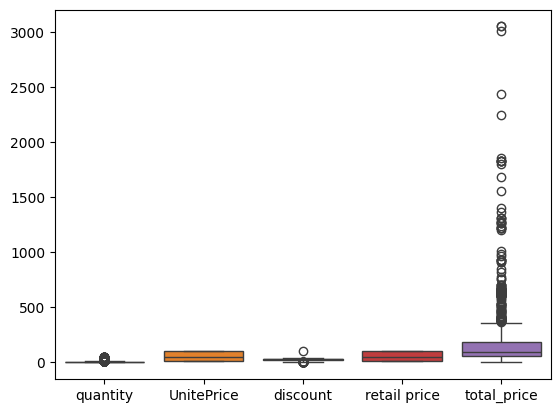

In [417]:
sns.boxplot(data=df_filtered)

##Univariate Analysis

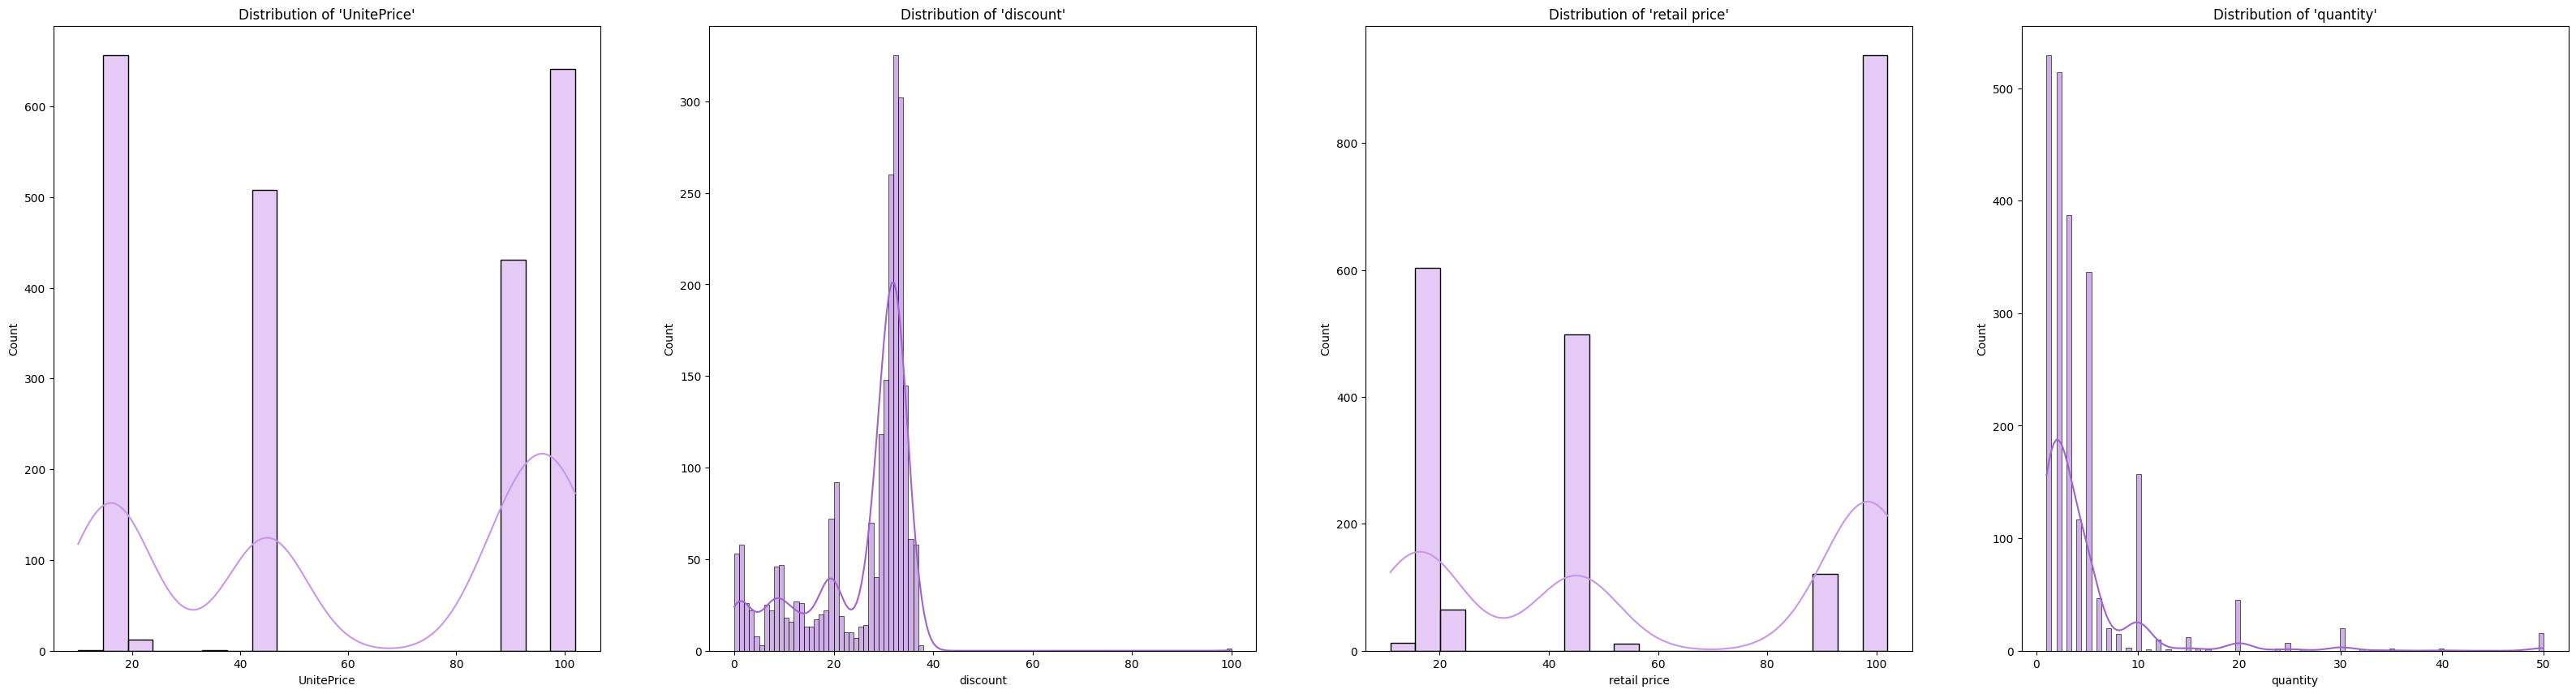

In [418]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df_filtered["UnitePrice"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df_filtered["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");
sns.histplot(ax = axes[2], x = df_filtered["retail price"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'retail price'");

sns.histplot(ax = axes[3], x = df_filtered["quantity"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'quantity'");


non of the columns looks normally distrbuted . this suggests min- max norlmaization at data scaling part .



<Axes: xlabel='date', ylabel='quantity'>

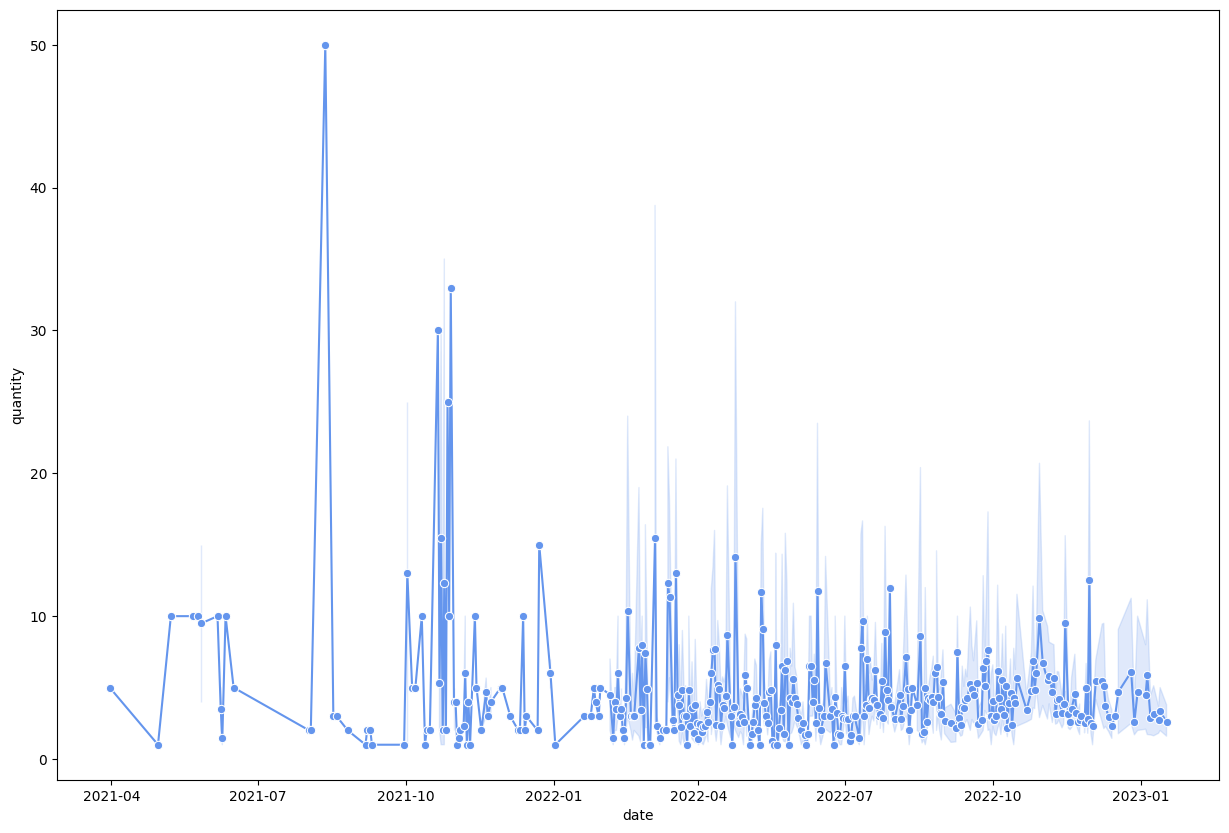

In [ ]:
### Visualize time series ###
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.lineplot(x=df_filtered.index, y=df_filtered["quantity"], color='cornflowerblue', marker='o')


## Multivariate Analysis


In [ ]:
# Create a pivot table to see data more clearly and make some relation between categorical data
pivot_df = df_filtered.pivot_table(
    index='date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount', 'retail price','total_price'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index to turn 'Date' back into a column if needed
pivot_df.reset_index(inplace=True)


In [ ]:
pivot_df

date  UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
0    2021-03-31                        102.0                         0.0   
1    2021-04-30                          0.0                         0.0   
2    2021-05-08                          0.0                         0.0   
3    2021-05-22                          0.0                         0.0   
4    2021-05-25                          0.0                         0.0   
..          ...                          ...                         ...   
336  2023-01-07                         99.0                       297.0   
337  2023-01-09                        297.0                       396.0   
338  2023-01-12                          0.0                        99.0   
339  2023-01-13                          0.0                        99.0   
340  2023-01-17                          0.0                        99.0   

     UnitePrice_product x _North  UnitePrice_product y_Cairo  \
0                            0.0                         0.0   
1                            0.0                        16.0   
2                            0.0                        16.0   
3                            0.0                         0.0   
4                            0.0                         0.0   
..                           ...                         ...   
336                        693.0                         0.0   
337                          0.0                         0.0   
338                        396.0                        16.0   
339                        198.0                         0.0   
340                        396.0                         0.0   

     UnitePrice_product y_Giza  UnitePrice_product y_North  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                        16.0   
4                          0.0                        16.0   
..                         ...                         ...   
336                       32.0                         0.0   
337                        0.0                        16.0   
338                        0.0                        16.0   
339                        0.0                         0.0   
340                        0.0                         0.0   

     UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                          45.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   
..                          ...                        ...   
336                         0.0                        0.0   
337                         0.0                        0.0   
338                        45.0                        0.0   
339                         0.0                        0.0   
340                         0.0                        0.0   

     UnitePrice_product z_North  ...  retail price_product z_North  \
0                           0.0  ...                           0.0   
1                           0.0  ...                           0.0   
2                           0.0  ...                           0.0   
3                           0.0  ...                           0.0   
4                           0.0  ...                           0.0   
..                          ...  ...                           ...   
336                       135.0  ...                         135.0   
337                         0.0  ...                           0.0   
338                        90.0  ...                          90.0   
339                         0.0  ...                           0.0   
340                         0.0  ...                           0.0   

sparsity in data will make model lazy to learn .

### Correlation map


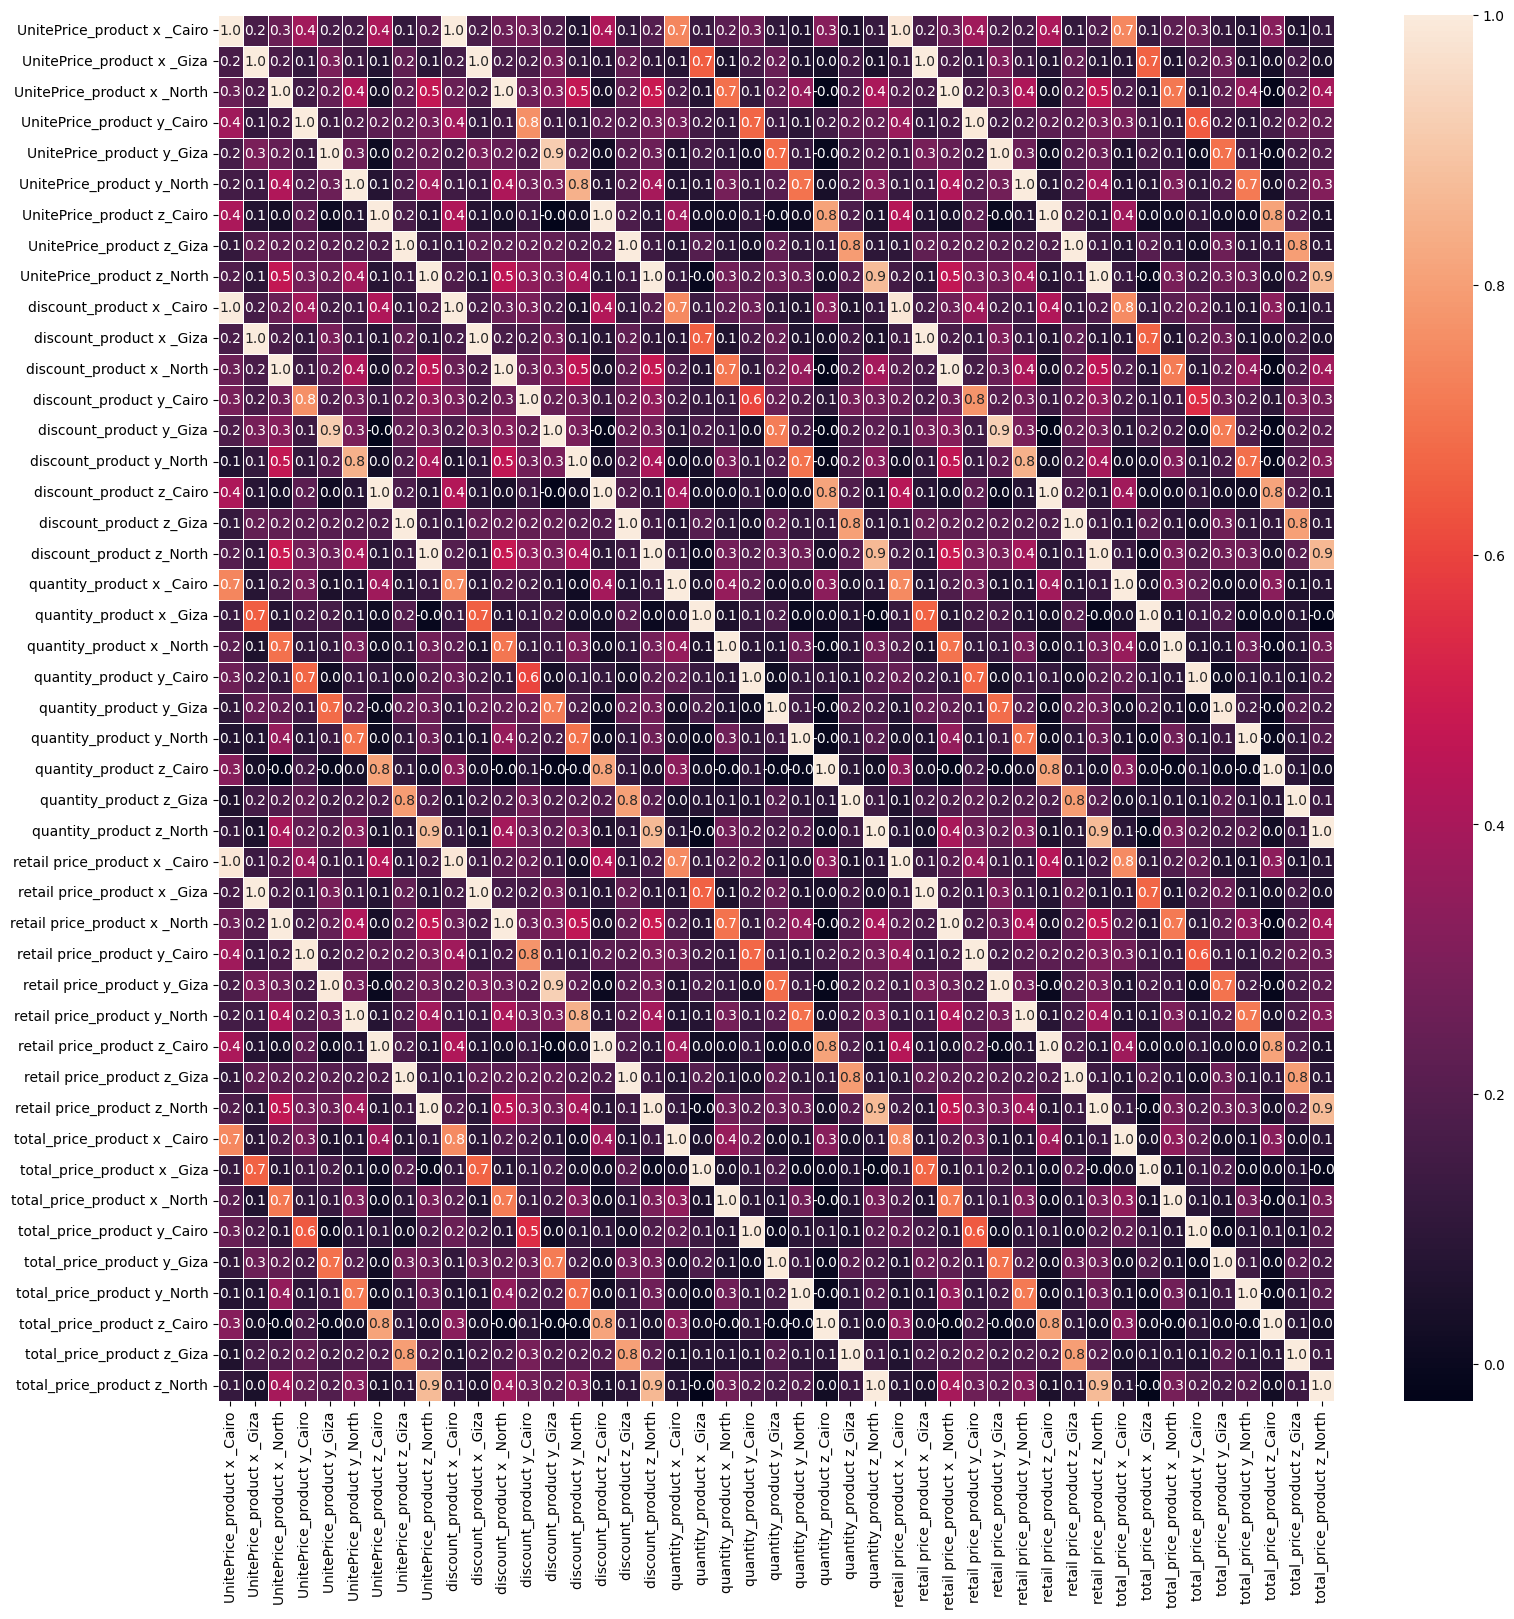

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pivot_df.drop(columns=['date']).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

no significant correlations out of diagonal except for (retail , unit prices).



### Pair plot

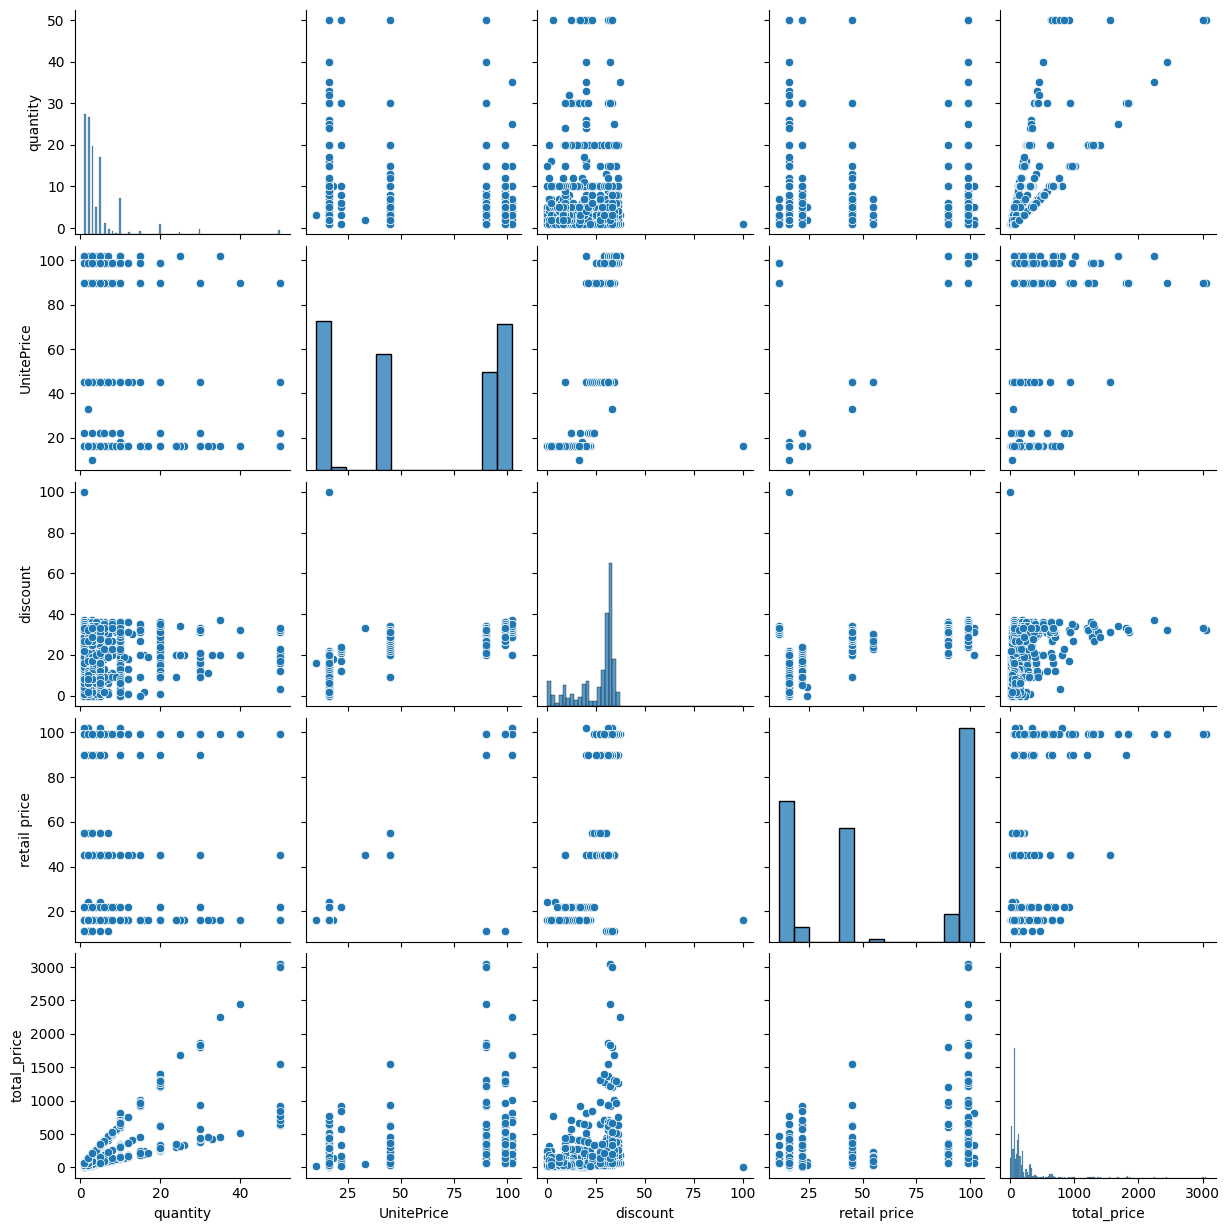

In [ ]:
sns.pairplot(df_filtered)


features relations is't clear and outilers are obvious .

### lineplot

In [ ]:
# Select specific columns from pivot DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
          'quantity_product x _North', 'quantity_product y_Cairo',
          'quantity_product y_Giza'  , 'quantity_product y_North',
          'quantity_product z_Cairo' , 'quantity_product z_Giza',
          'quantity_product z_North']

In [ ]:
#strip white spaces in columns names
pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

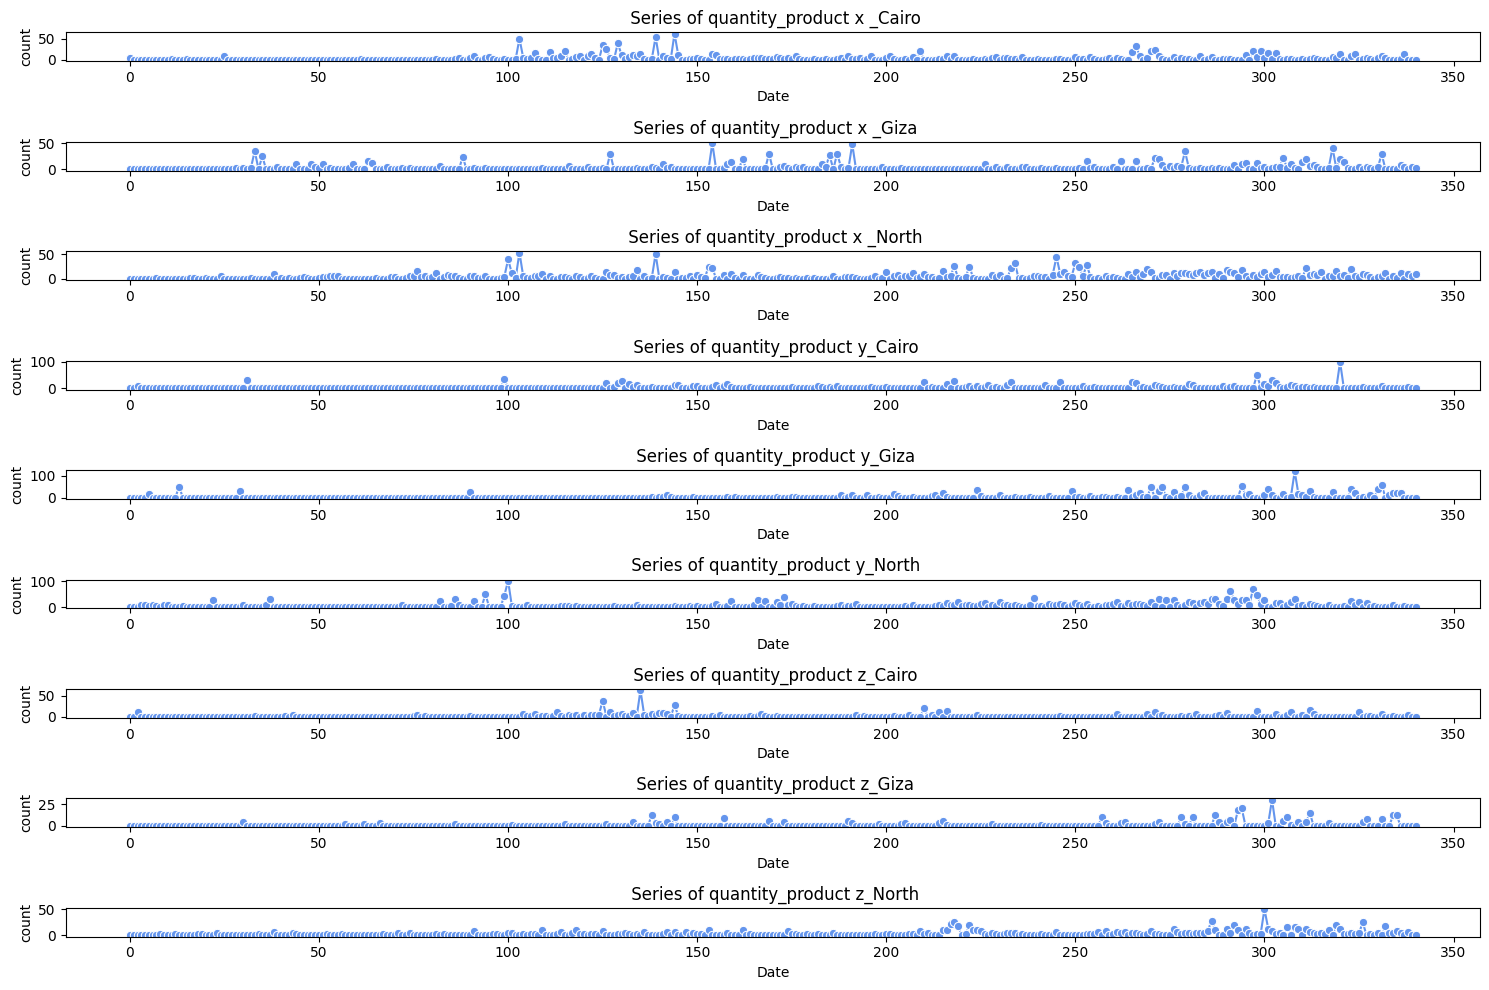

In [ ]:
# Create a figure with as many subplots as the number of out_cols
fig, ax = plt.subplots(nrows=len(out_cols), ncols=1, figsize=(15, 10))
# Loop over your target columns (out_cols) and create one plot for each
for i in range(len(out_cols)):
    sns.lineplot(x=pivot_df.index, y=pivot_df[out_cols[i]], ax=ax[i], color='cornflowerblue', marker='o')
    ax[i].set_title(f" Series of {out_cols[i]}")
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel("count")

# Adjust layout to ensure plots are spaced properly
plt.tight_layout()

# Display the plot
plt.show()


## Time Series Analysis

In [ ]:
# import libararies for Time series forecasting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler


our data isn't uniformaly spaced so i will resample it as a daily frequency to check for stationarity , seasonality and trend patterns .

### Data resampling

i will resample data at daily frequency since i will predict 10 days in advance.

In [ ]:
pivot_df_resampled=pivot_df.copy()
pivot_df_resampled['date'] = pd.to_datetime(pivot_df_resampled['date'])
pivot_df_resampled.set_index('date', inplace=True)

# Resample to daily frequency
pivot_df_resampled = pivot_df_resampled.resample('D').mean()

# Handle missing values by interpolation
pivot_df_resampled.interpolate(method='linear', inplace=True)
# i have tried second degree interpolation and make bad results .

In [419]:
pivot_df_resampled.describe()

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
count                   658.000000                  658.000000   
mean                     61.991831                   45.726254   
std                      93.875450                   89.558994   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      89.750000                   89.750000   
max                     718.000000                  792.000000   

       UnitePrice_product x _North  UnitePrice_product y_Cairo  \
count                   658.000000                  658.000000   
mean                    119.275076                    5.270517   
std                     167.862864                   10.655434   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                      68.000000                    0.000000   
75%                     179.500000                    7.333333   
max                     990.000000                   80.000000   

       UnitePrice_product y_Giza  UnitePrice_product y_North  \
count                 658.000000                  658.000000   
mean                    5.123100                   15.237082   
std                    12.363855                   21.684800   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    6.604255   
75%                     0.000000                   19.200000   
max                   118.000000                  112.000000   

       UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
count                  658.000000                 658.000000   
mean                    10.684650                   8.548632   
std                     28.161487                  21.888234   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                    270.000000                 180.000000   

       UnitePrice_product z_North  discount_product x _Cairo  ...  \
count                  658.000000                 658.000000  ...   
mean                    31.971884                  21.002158  ...   
std                     51.676622                  32.480806  ...   
min                      0.000000                   0.000000  ...   
25%                      0.000000                   0.000000  ...   
50%                      0.000000                   0.000000  ...   
75%                     45.000000                  31.648936  ...   
max                    315.000000                 256.000000  ...   

       retail price_product z_North  total_price_product x _Cairo  \
count                    658.000000                    658.000000   
mean                      32.199848                    161.941732   
std                       52.072434                    362.134901   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                       45.000000                    181.779375   
max                      315.000000                   3783.860000   

       total_price_product x _Giza  total_price_product x _North  \
count                   658.000000                    658.000000   
mean                    154.667828                    216.421717   
std                     379.632774                    387.998668   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%        

#### Removing outliers using IsolationForest

In [465]:
pivot_df_resampled_filtered=pivot_df_resampled.copy()
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.4)
outliers = model.fit_predict(pivot_df_resampled)
mask = outliers != -1
pivot_df_resampled_filtered = pivot_df_resampled[mask]

pivot_df_resampled_filtered.describe()

UnitePrice_product x _Cairo  UnitePrice_product x _Giza  \
count                   395.000000                  395.000000   
mean                     23.528165                   16.792342   
std                      41.948352                   39.271562   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      38.231915                    0.000000   
max                     269.250000                  204.000000   

       UnitePrice_product x _North  UnitePrice_product y_Cairo  \
count                   395.000000                  395.000000   
mean                     41.085021                    1.439904   
std                      62.843177                    4.040138   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                      89.750000                    0.000000   
max                     396.000000                   16.000000   

       UnitePrice_product y_Giza  UnitePrice_product y_North  \
count                 395.000000                  395.000000   
mean                    0.644051                    6.443978   
std                     2.571302                    9.434896   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                   14.006079   
max                    16.000000                   48.000000   

       UnitePrice_product z_Cairo  UnitePrice_product z_Giza  \
count                  395.000000                 395.000000   
mean                     2.630425                   2.050633   
std                      9.741480                   7.579164   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                     45.000000                  45.000000   

       UnitePrice_product z_North  discount_product x _Cairo  ...  \
count                  395.000000                 395.000000  ...   
mean                    10.594937                   7.698734  ...   
std                     20.167580                  13.925142  ...   
min                      0.000000                   0.000000  ...   
25%                      0.000000                   0.000000  ...   
50%                      0.000000                   0.000000  ...   
75%                     15.000000                  11.585106  ...   
max                    135.000000                  91.000000  ...   

       retail price_product z_North  total_price_product x _Cairo  \
count                    395.000000                    395.000000   
mean                      10.603376                     50.180168   
std                       20.188991                    103.516770   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                       15.000000                     61.927500   
max                      135.000000                    816.000000   

       total_price_product x _Giza  total_price_product x _North  \
count                   395.000000                    395.000000   
mean                     61.770994                     68.078865   
std                     186.926617                    133.428047   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%        

here i choosed to try isolation forest since data is multivariant and nonlinear.

In [466]:
pivot_df_resampled_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 395 entries, 2021-03-31 to 2023-01-17
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UnitePrice_product x _Cairo    395 non-null    float64
 1   UnitePrice_product x _Giza     395 non-null    float64
 2   UnitePrice_product x _North    395 non-null    float64
 3   UnitePrice_product y_Cairo     395 non-null    float64
 4   UnitePrice_product y_Giza      395 non-null    float64
 5   UnitePrice_product y_North     395 non-null    float64
 6   UnitePrice_product z_Cairo     395 non-null    float64
 7   UnitePrice_product z_Giza      395 non-null    float64
 8   UnitePrice_product z_North     395 non-null    float64
 9   discount_product x _Cairo      395 non-null    float64
 10  discount_product x _Giza       395 non-null    float64
 11  discount_product x _North      395 non-null    float64
 12  discount_product y_Cairo       

<Axes: >

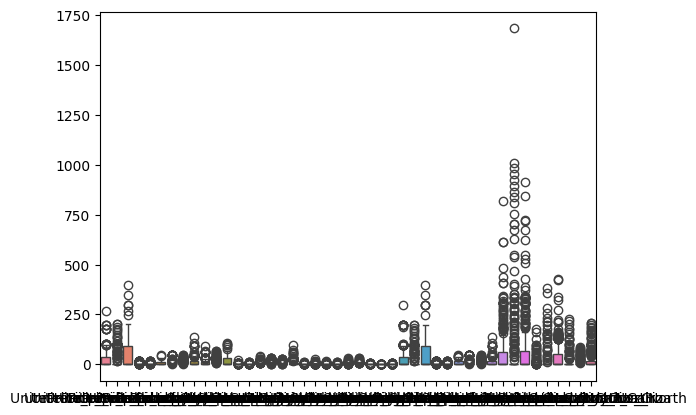

In [467]:
sns.boxplot(data=pivot_df_resampled_filtered)

### Stationarity check

First we will check for stationarity using Augmented Dicky fuller test .

In [ ]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Test for stationarity on each column (assuming each column is a time series)
for column in pivot_df[out_cols]:
    print(f"Testing stationarity for {column}")
    test_stationarity(pivot_df_resampled[column])


Testing stationarity for quantity_product x _Cairo
p-value: 0.014438554447571177
Series is stationary
Testing stationarity for quantity_product x _Giza
p-value: 1.2567657403757116e-07
Series is stationary
Testing stationarity for quantity_product x _North
p-value: 0.03721271375683711
Series is stationary
Testing stationarity for quantity_product y_Cairo
p-value: 3.968783399366232e-08
Series is stationary
Testing stationarity for quantity_product y_Giza
p-value: 0.005845923216830627
Series is stationary
Testing stationarity for quantity_product y_North
p-value: 0.03666767943975384
Series is stationary
Testing stationarity for quantity_product z_Cairo
p-value: 0.0012709116234397727
Series is stationary
Testing stationarity for quantity_product z_Giza
p-value: 0.004849455973492372
Series is stationary
Testing stationarity for quantity_product z_North
p-value: 0.11321906128290937
Series is not stationary


### Seasonality , trend and residuals

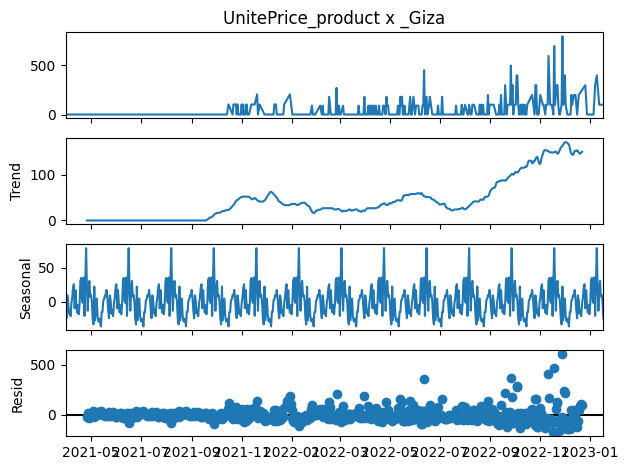

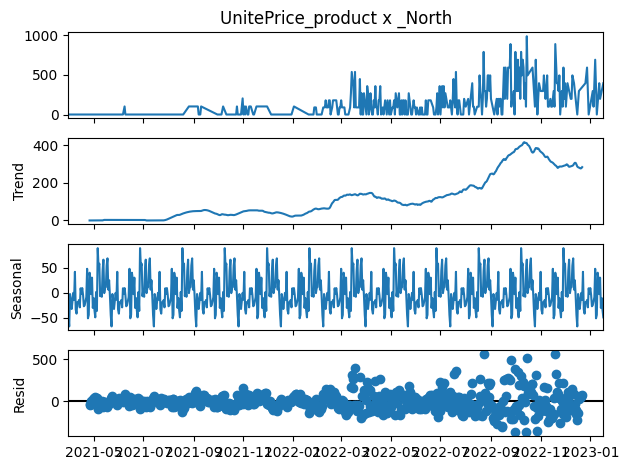

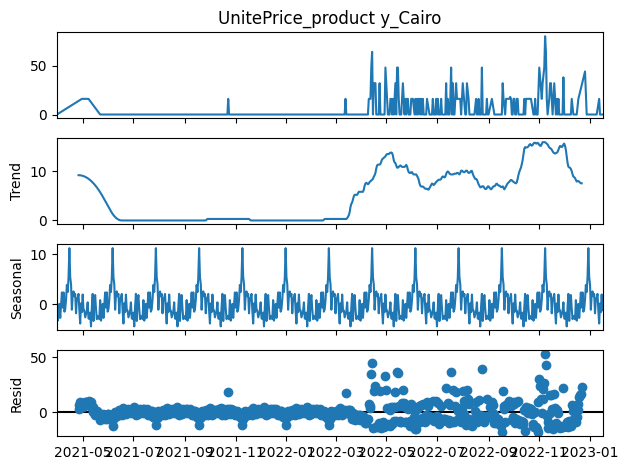

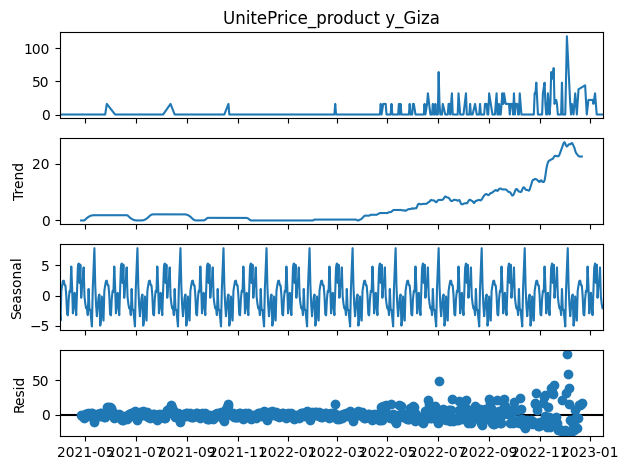

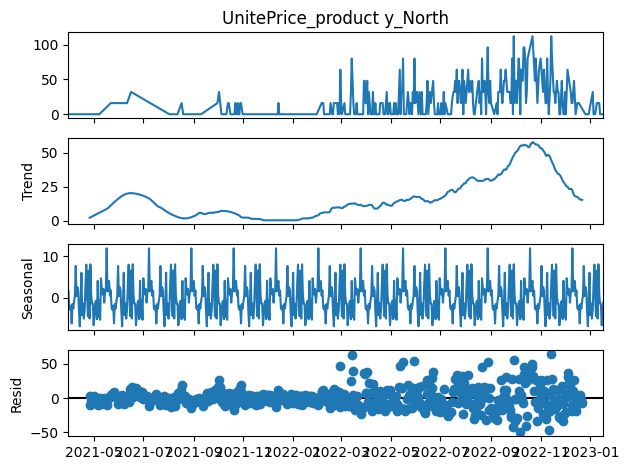

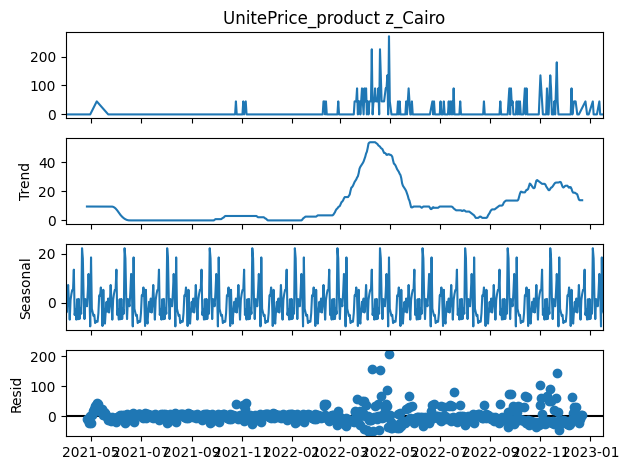

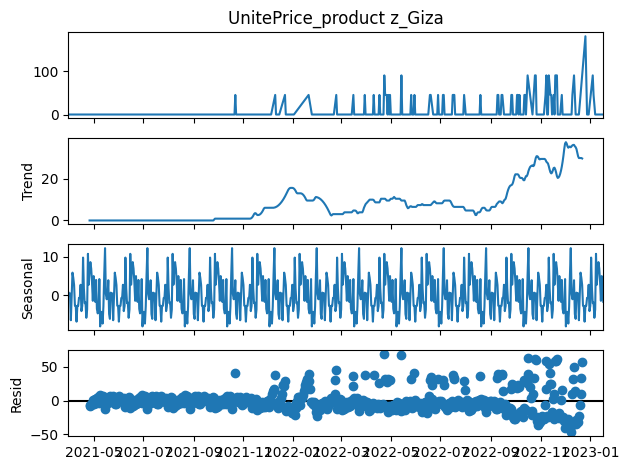

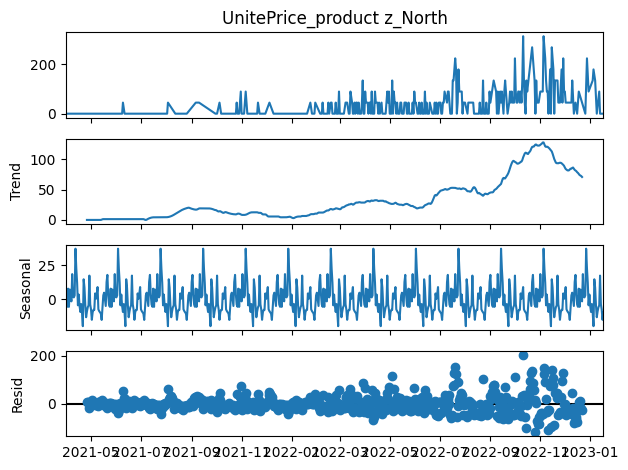

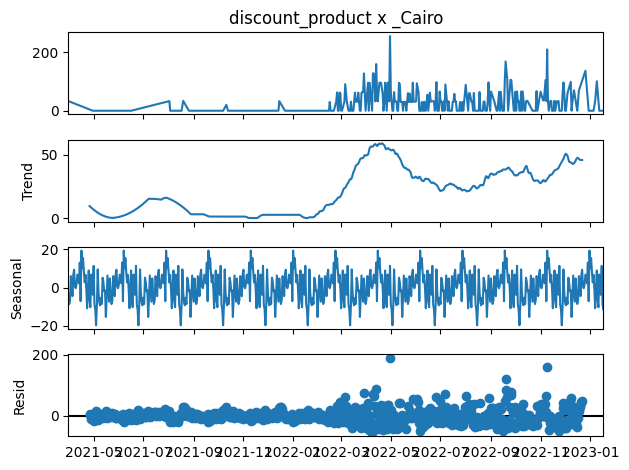

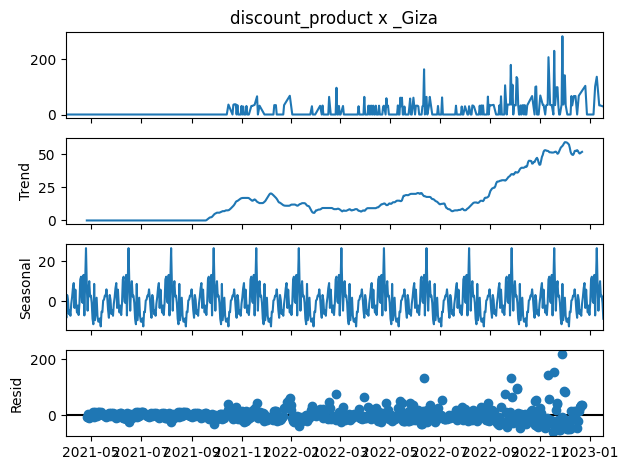

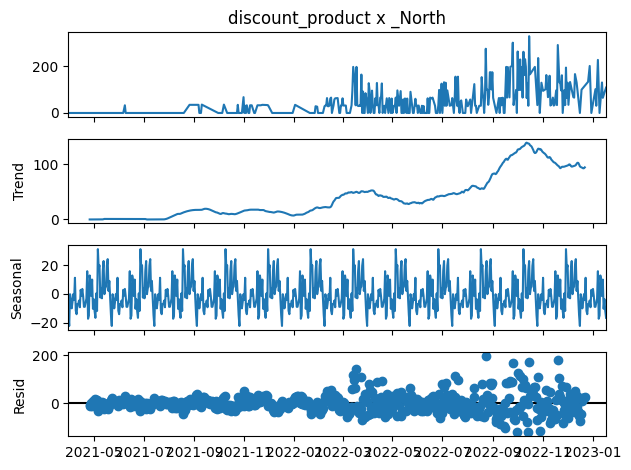

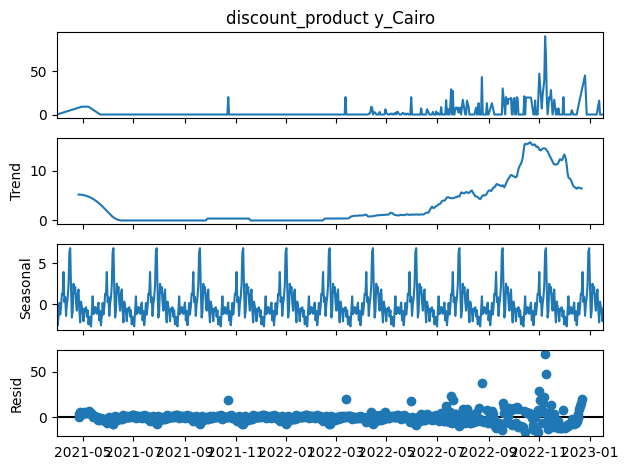

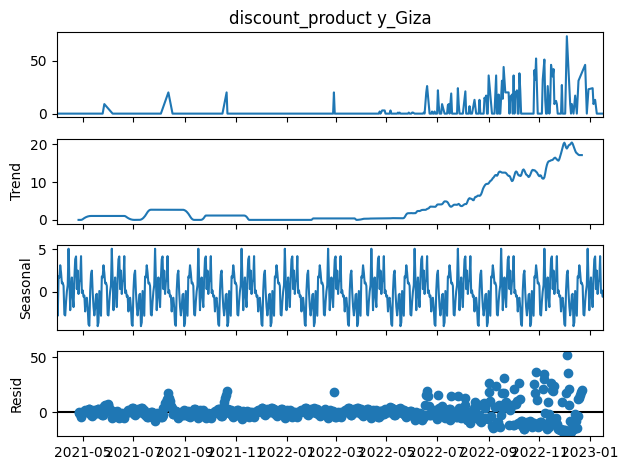

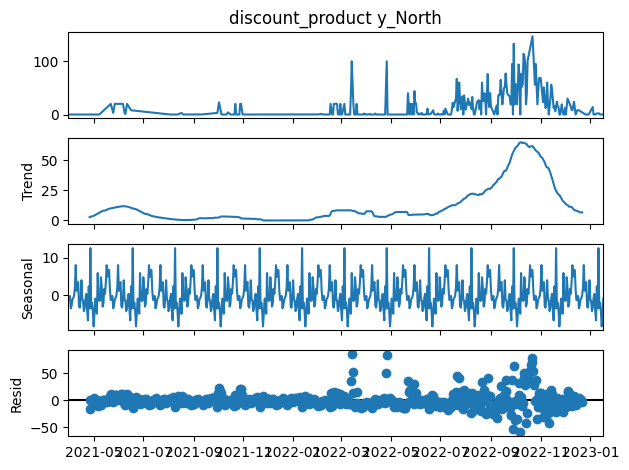

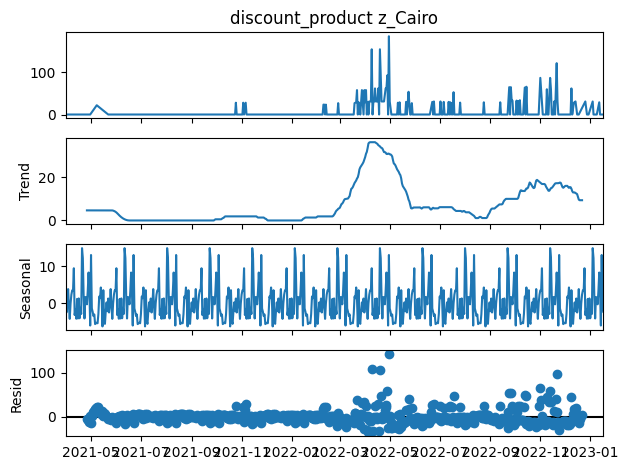

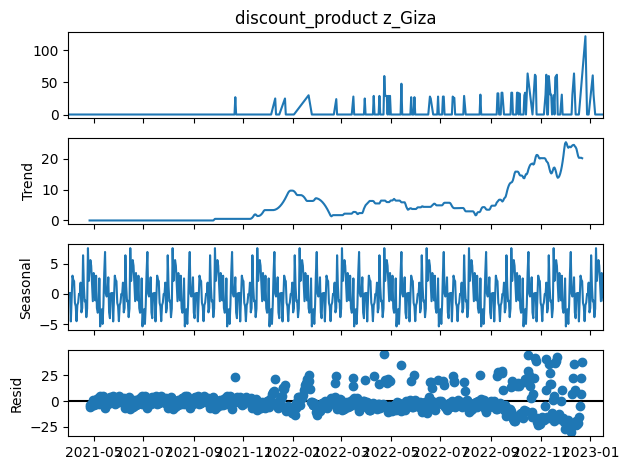

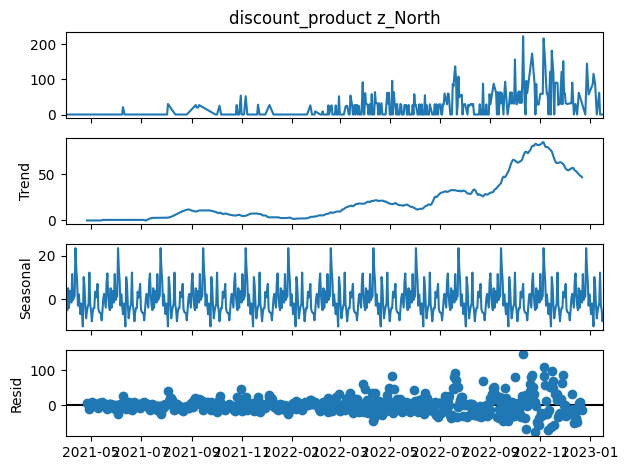

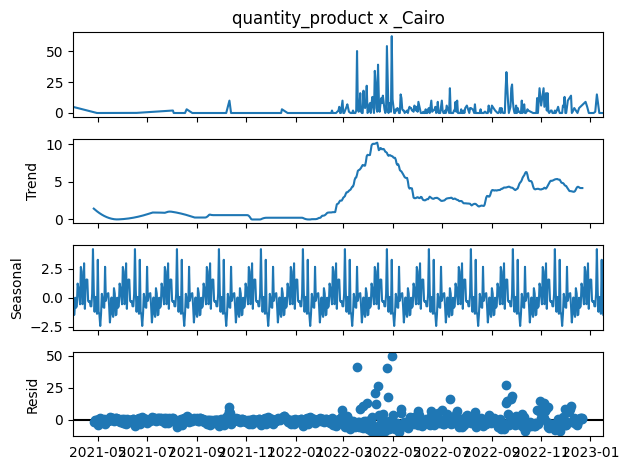

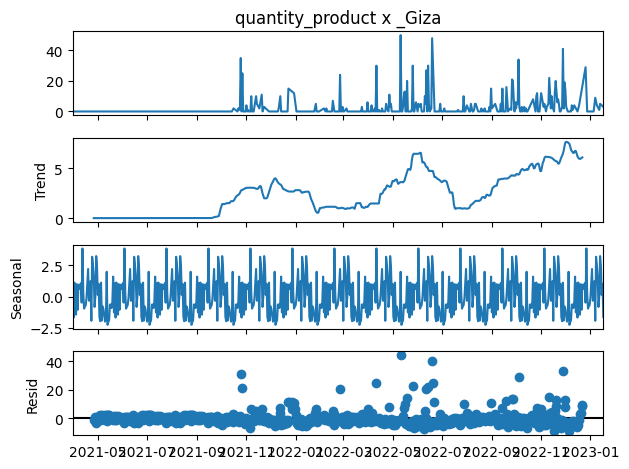

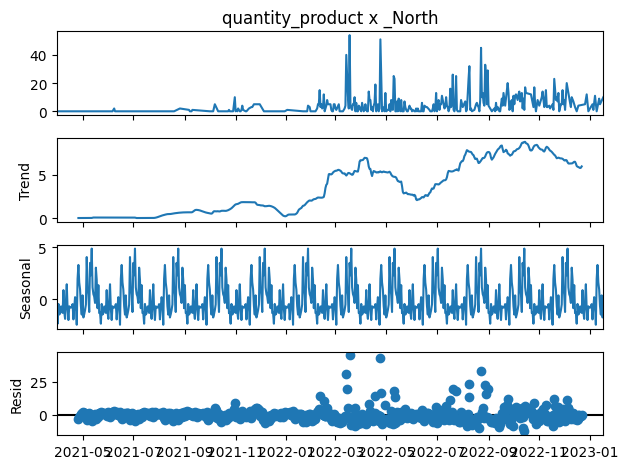

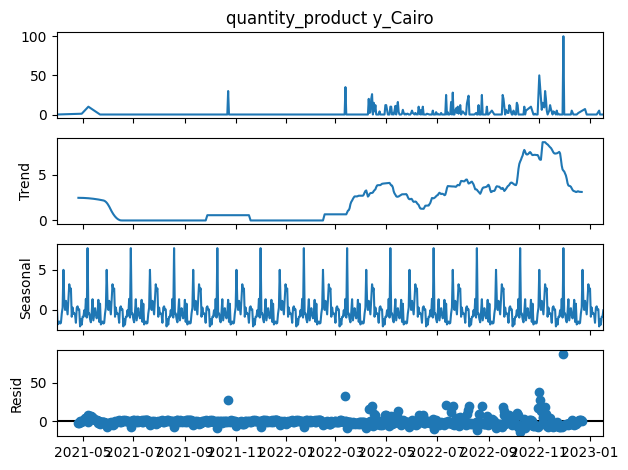

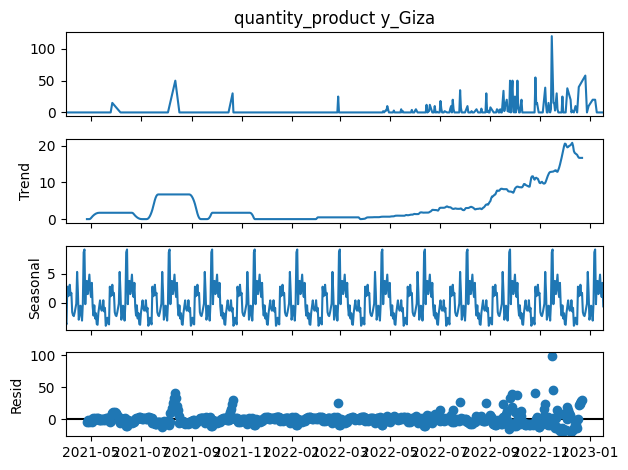

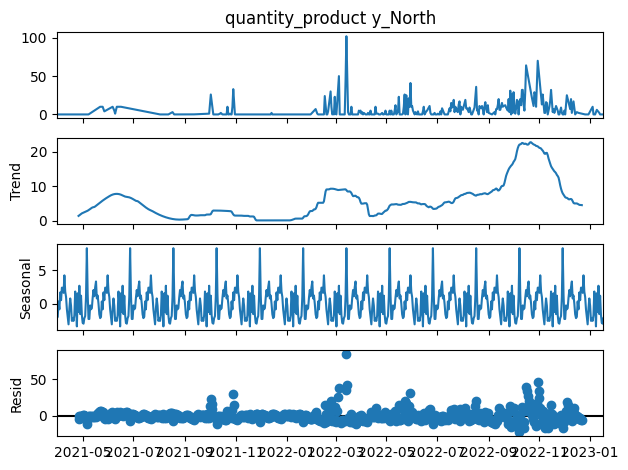

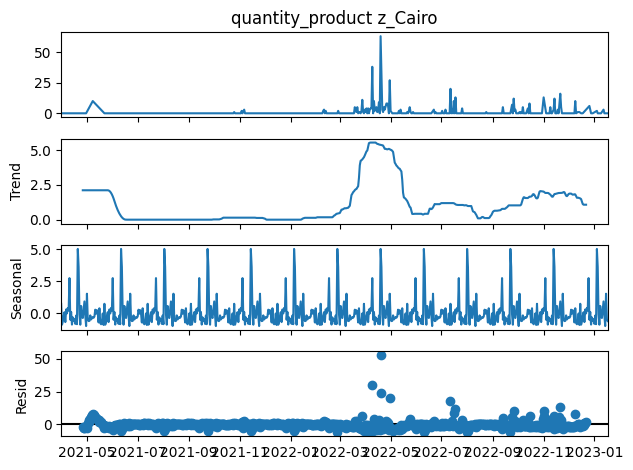

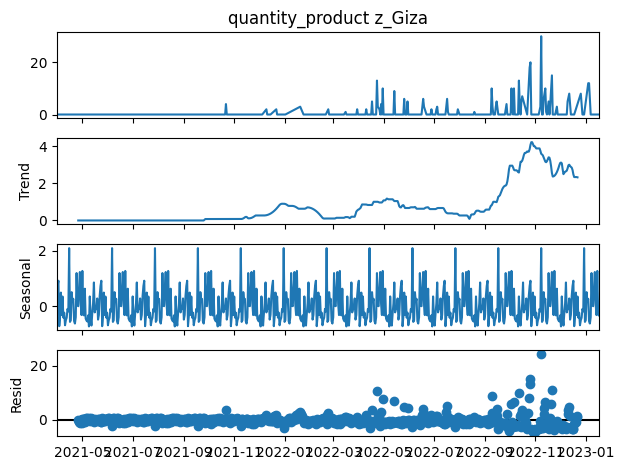

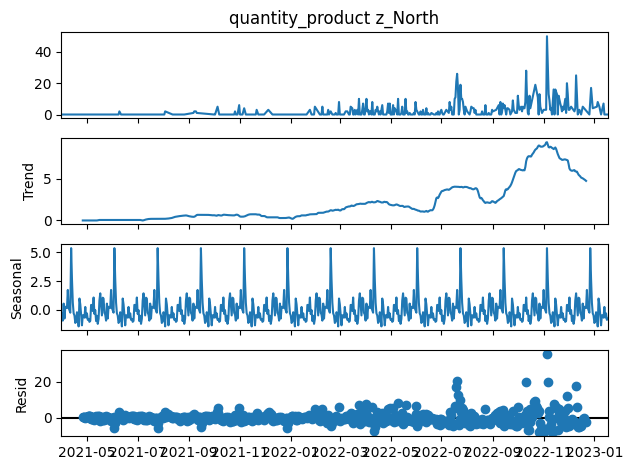

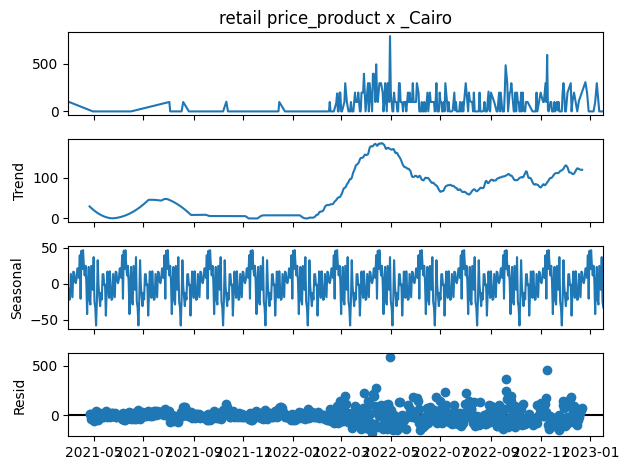

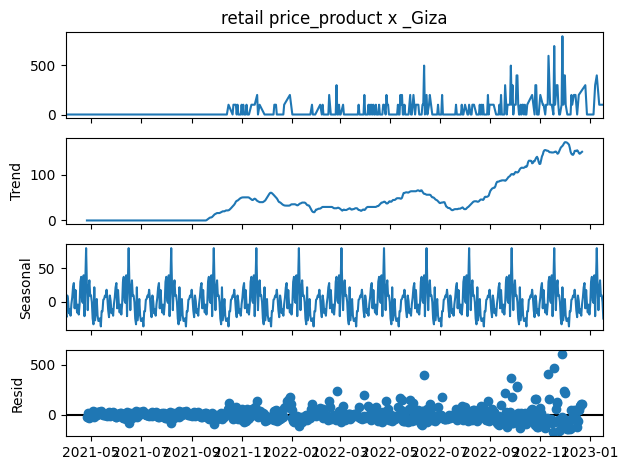

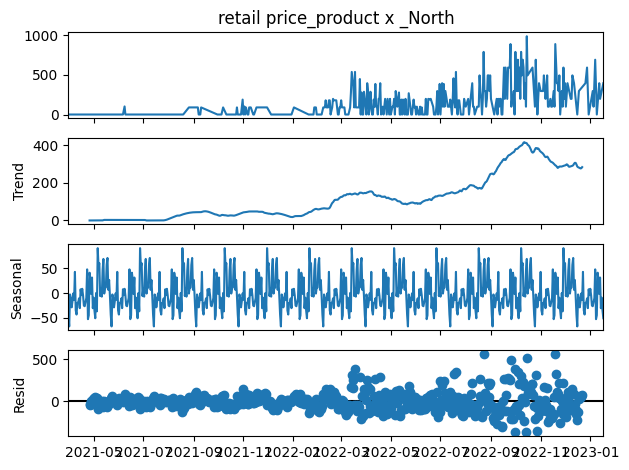

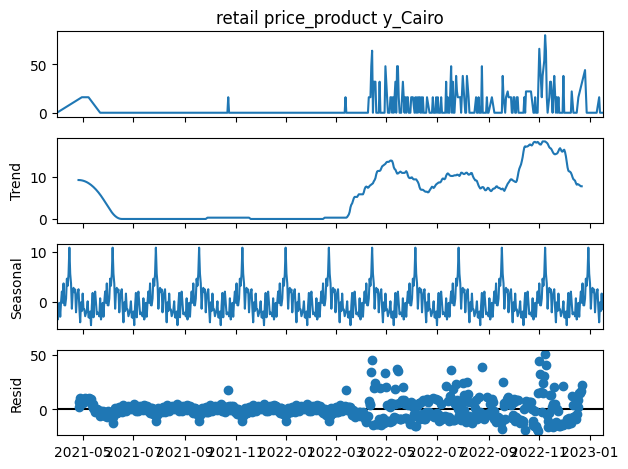

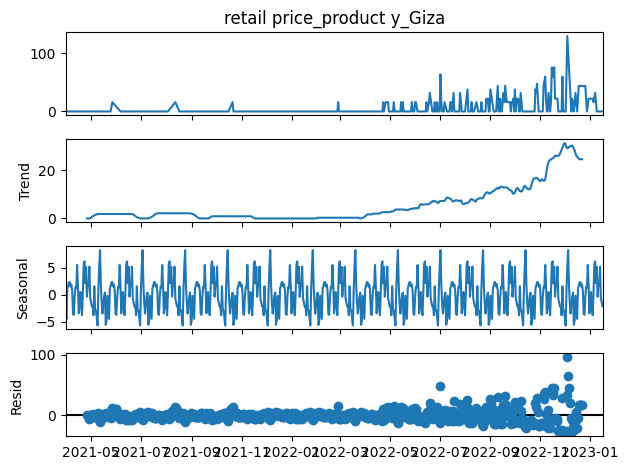

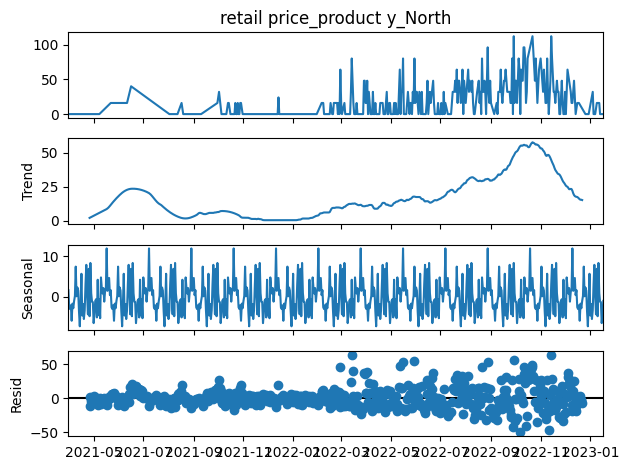

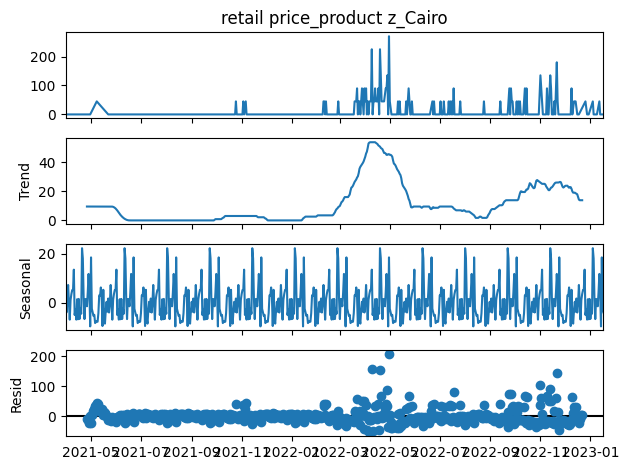

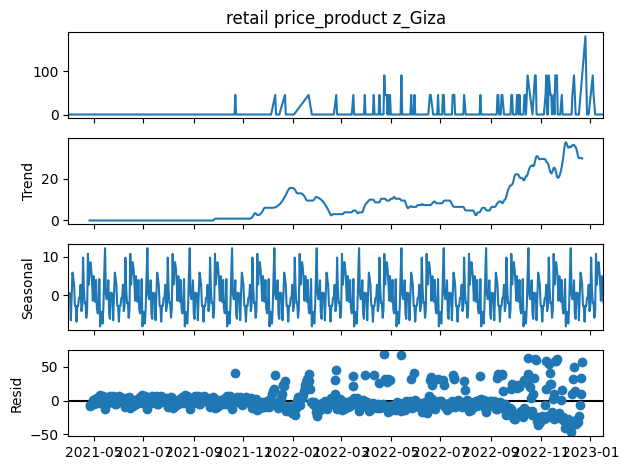

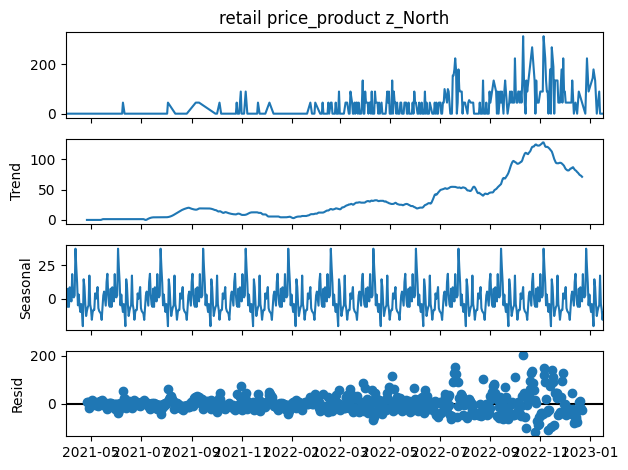

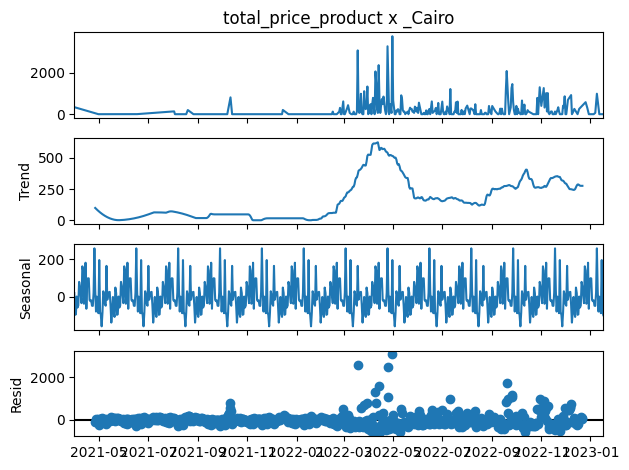

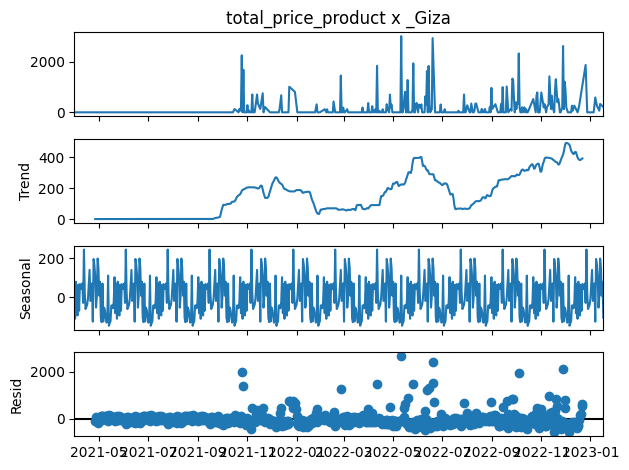

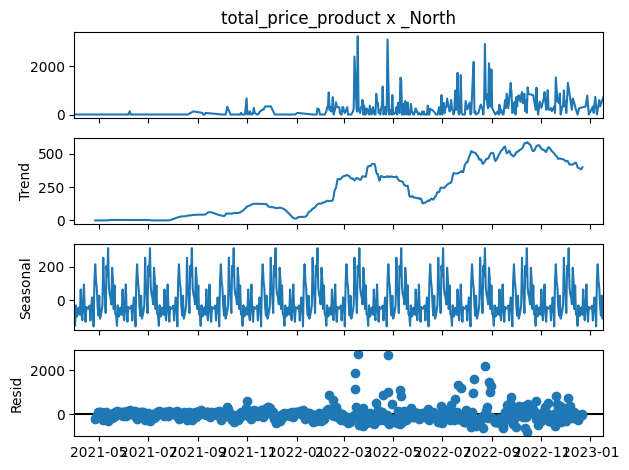

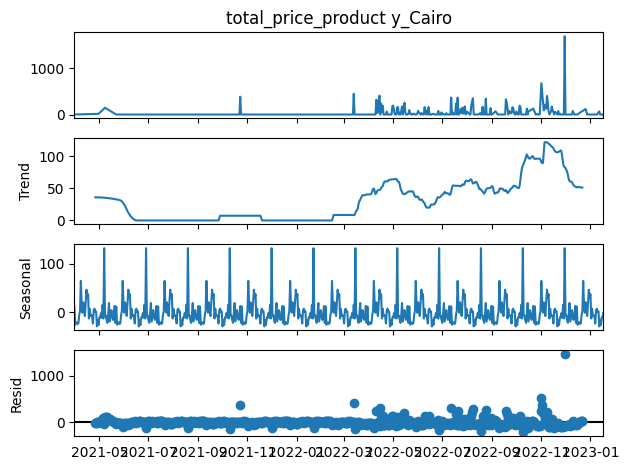

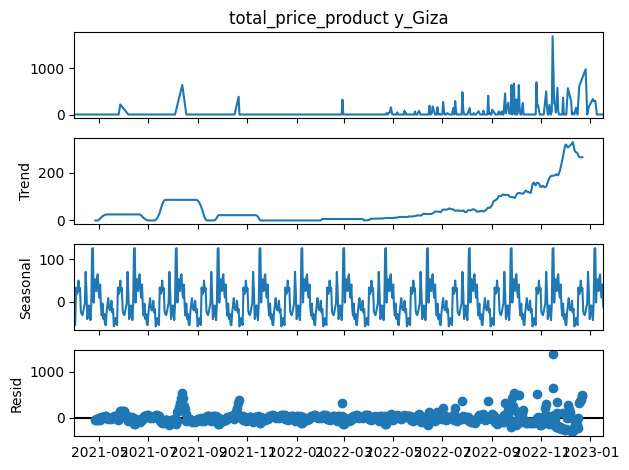

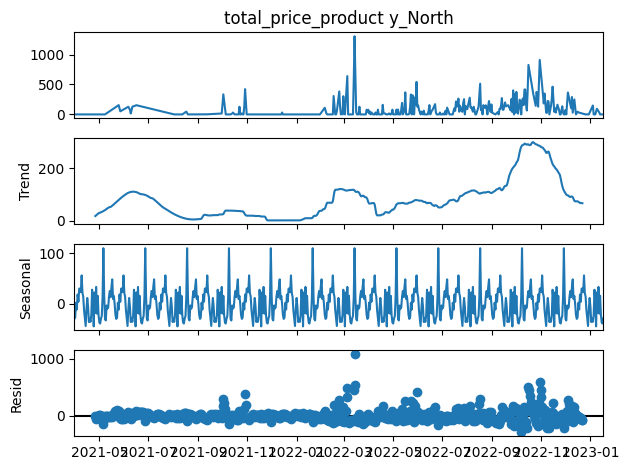

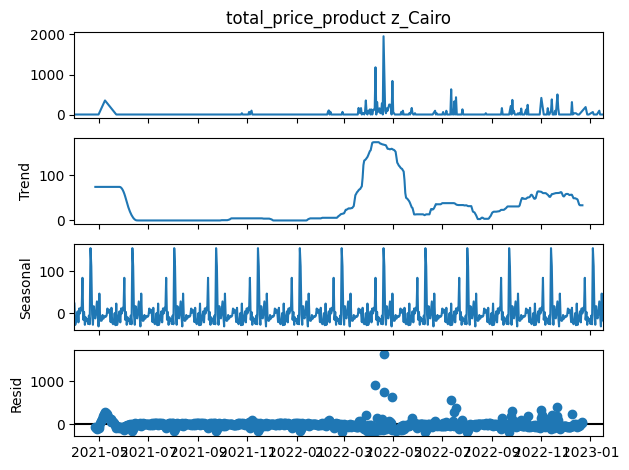

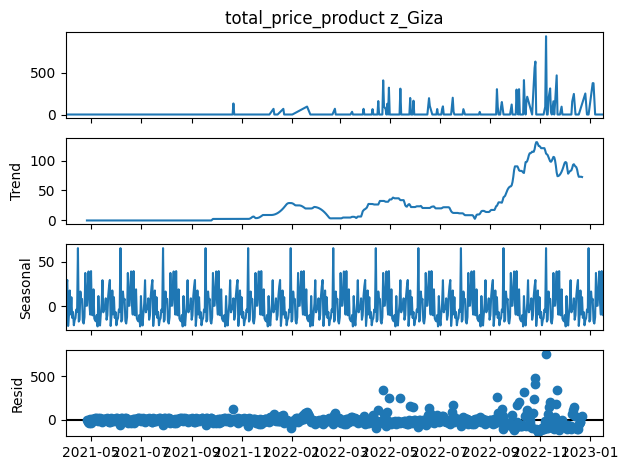

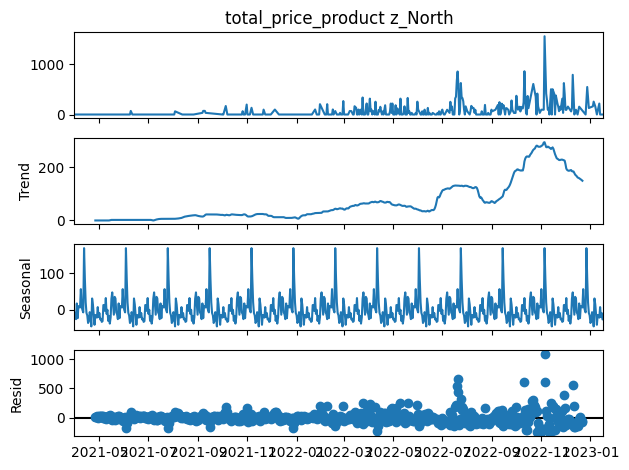

In [ ]:
# I will use additive approch where yt= seasonal component + trend + residuals
def decompose_time_series(series):
  # i will check for weekly seasonal component period = 52 week
    decomposition = seasonal_decompose(series, model='additive', period=52)
    decomposition.plot()
    plt.show()

# Decompose output c to visualize seasonality
for i in range (1 , len(pivot_df_resampled.columns)) :
  decompose_time_series(pivot_df_resampled.iloc[:, i])


*  although data has no obvious pattern but decomposition leads to seasonality
(seasonal fluctuations are constant over time) .





### ACF & PACF

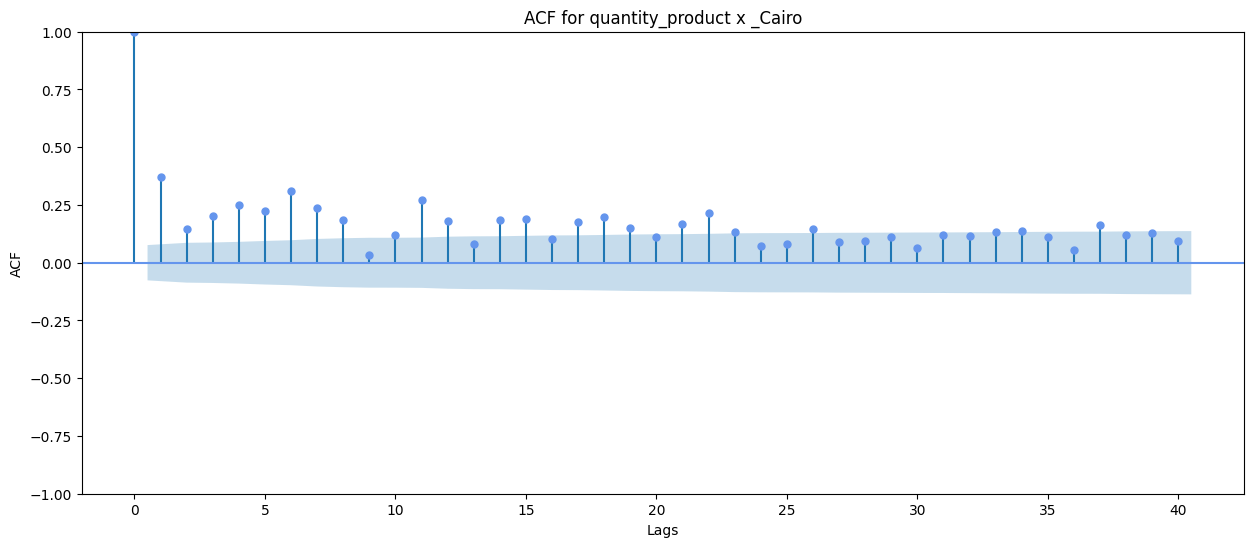

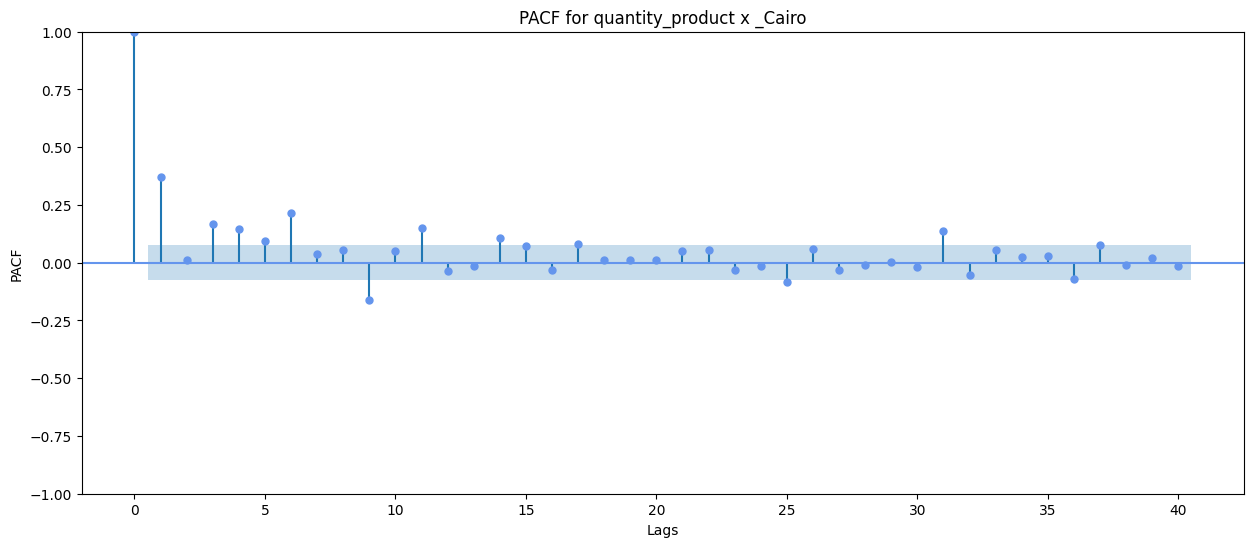

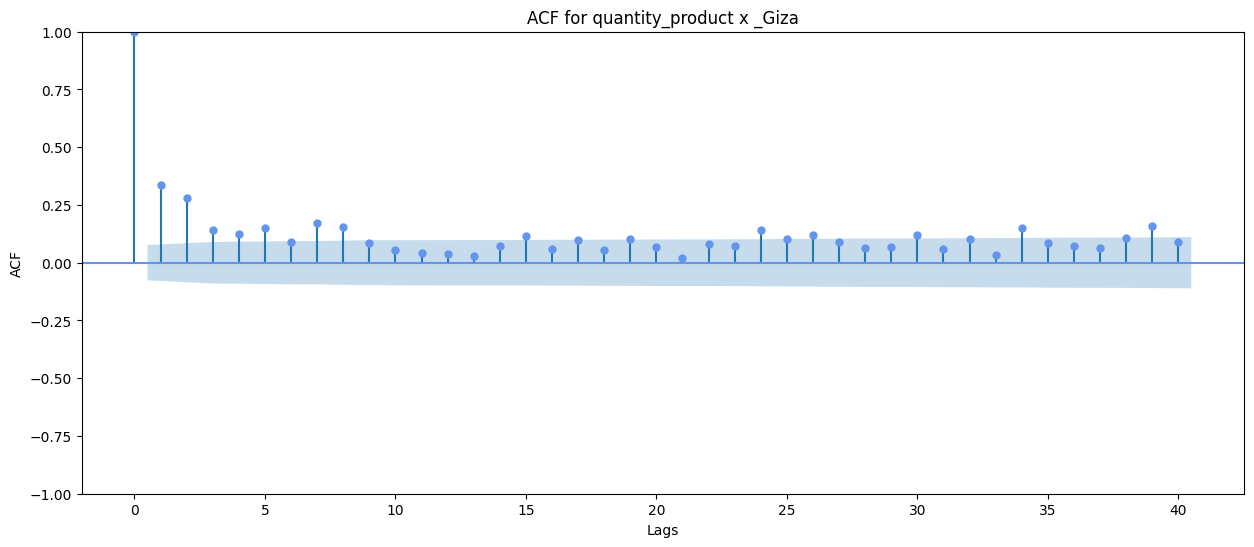

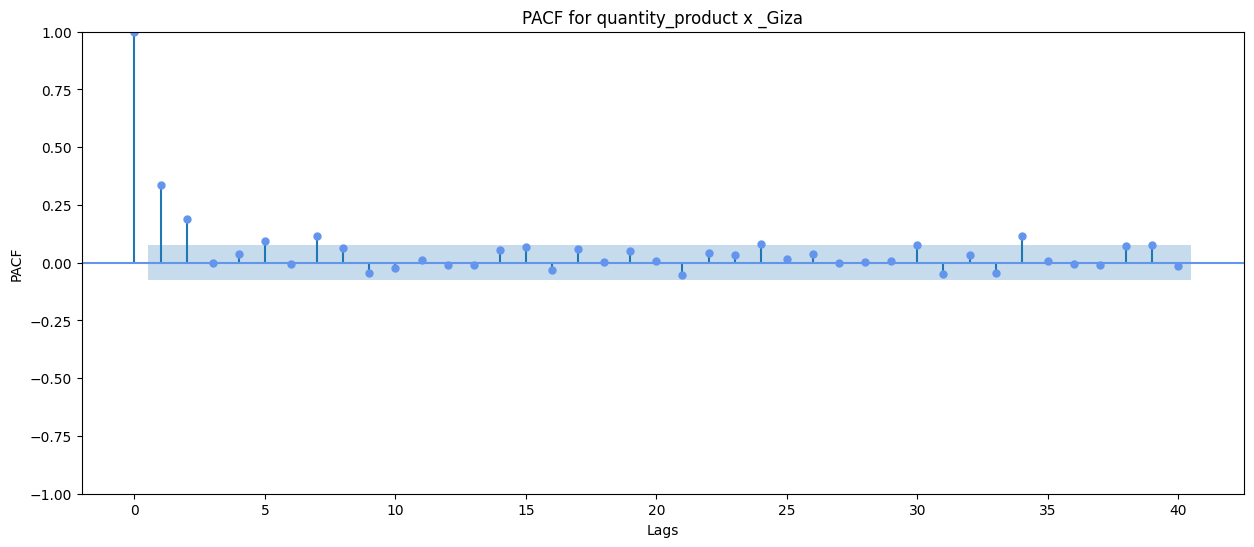

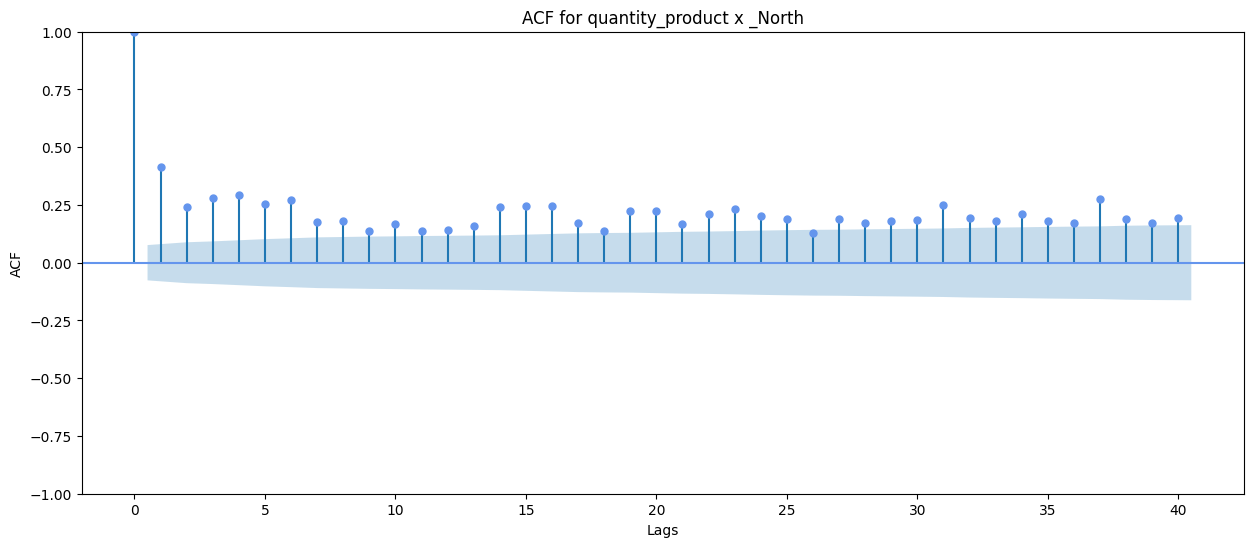

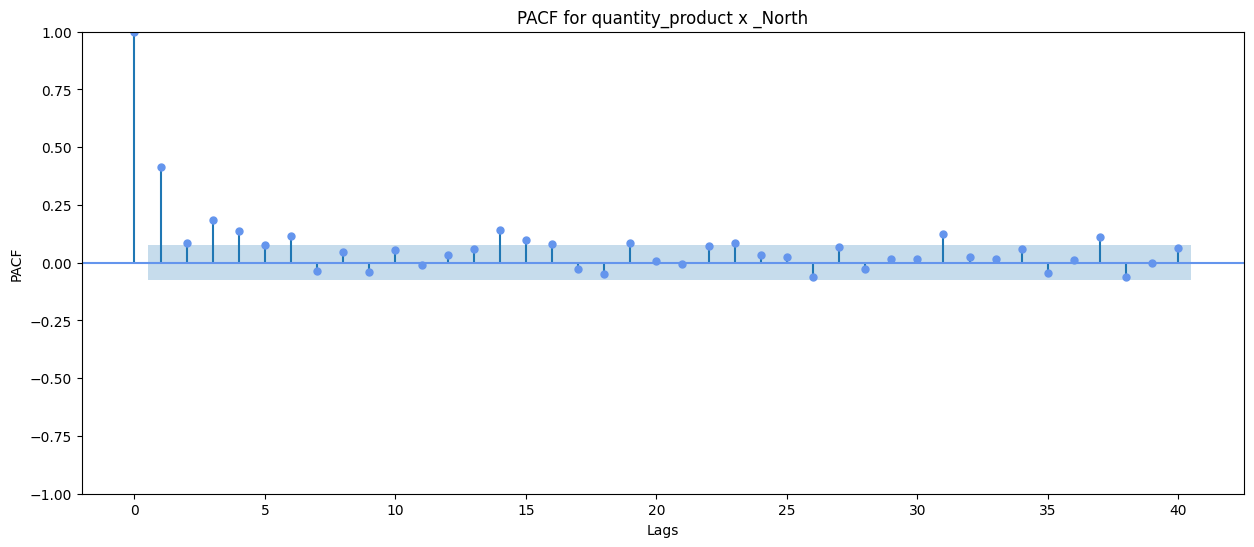

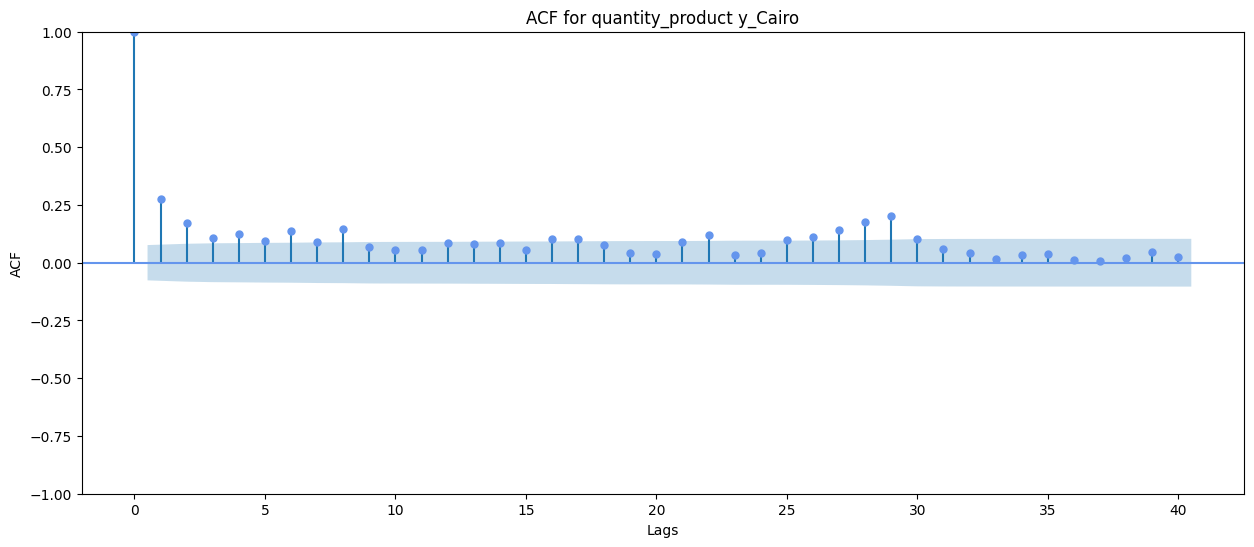

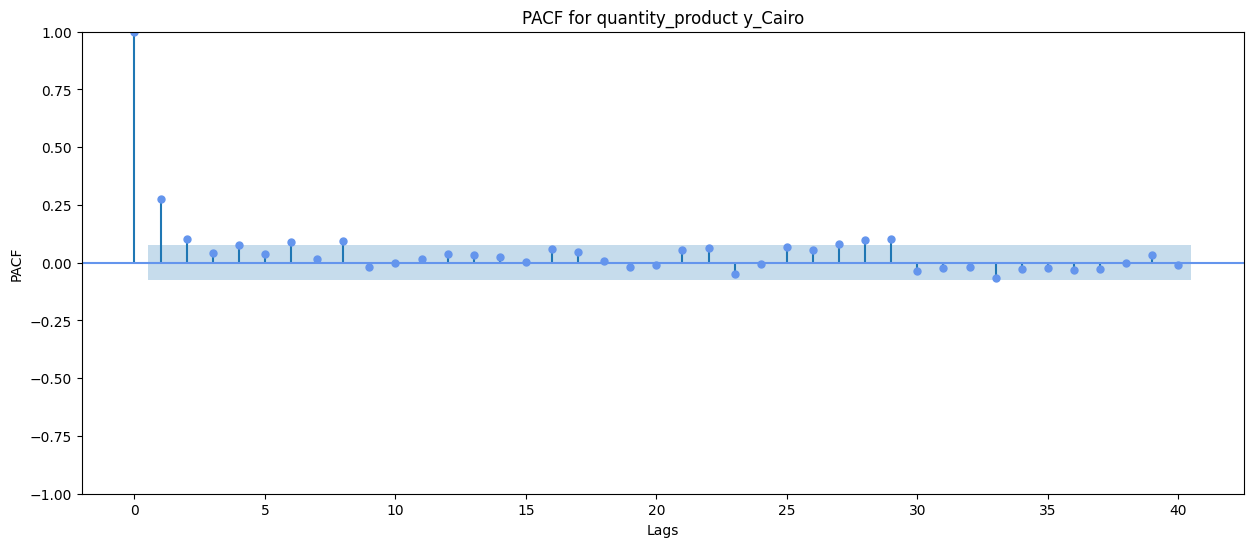

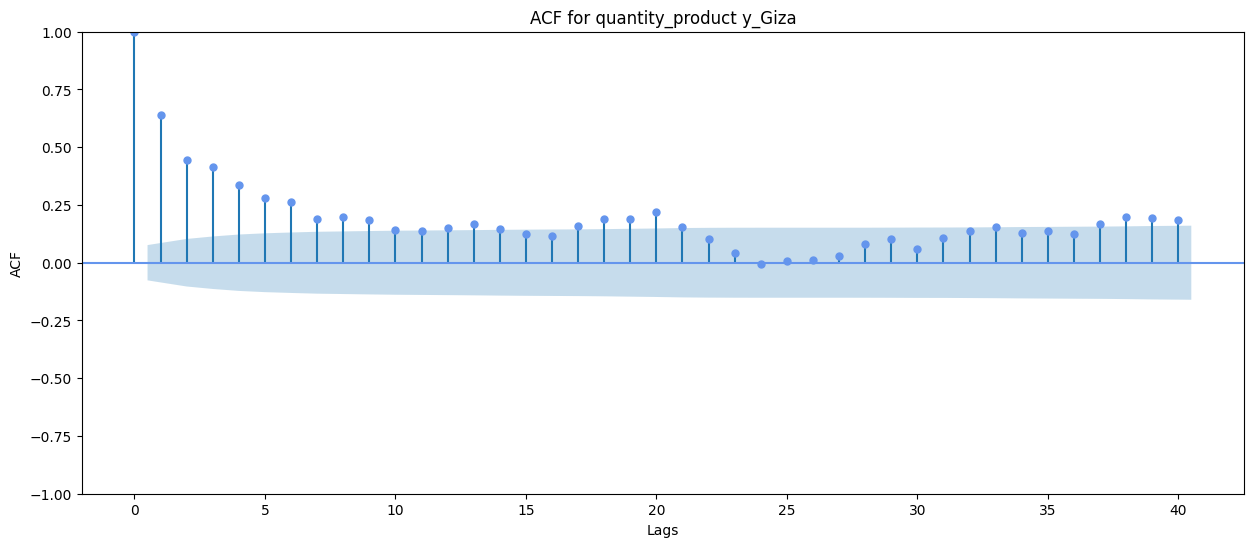

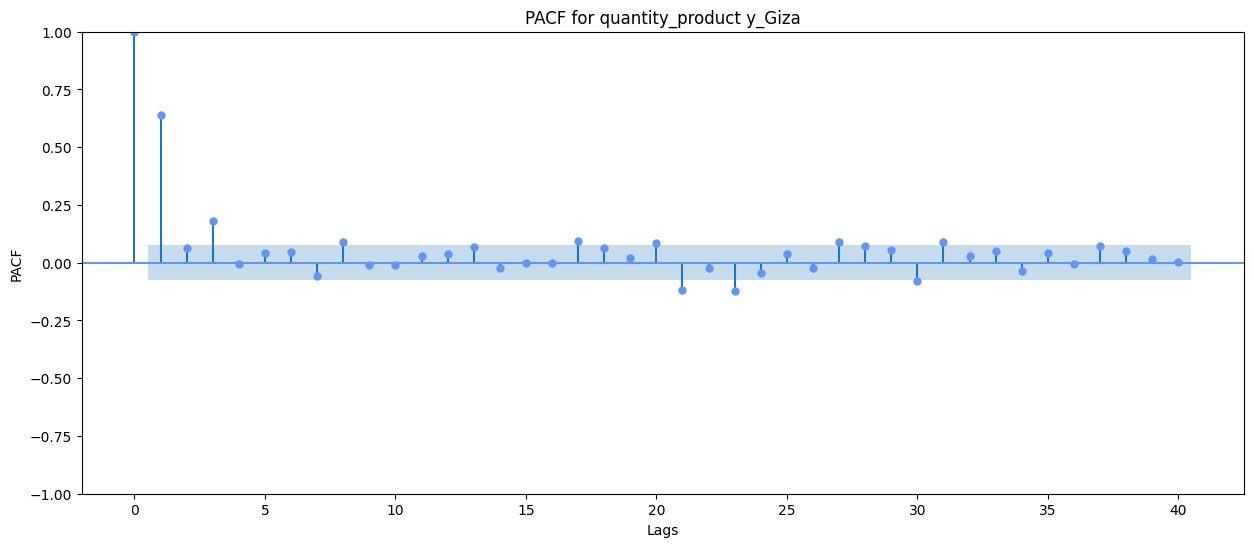

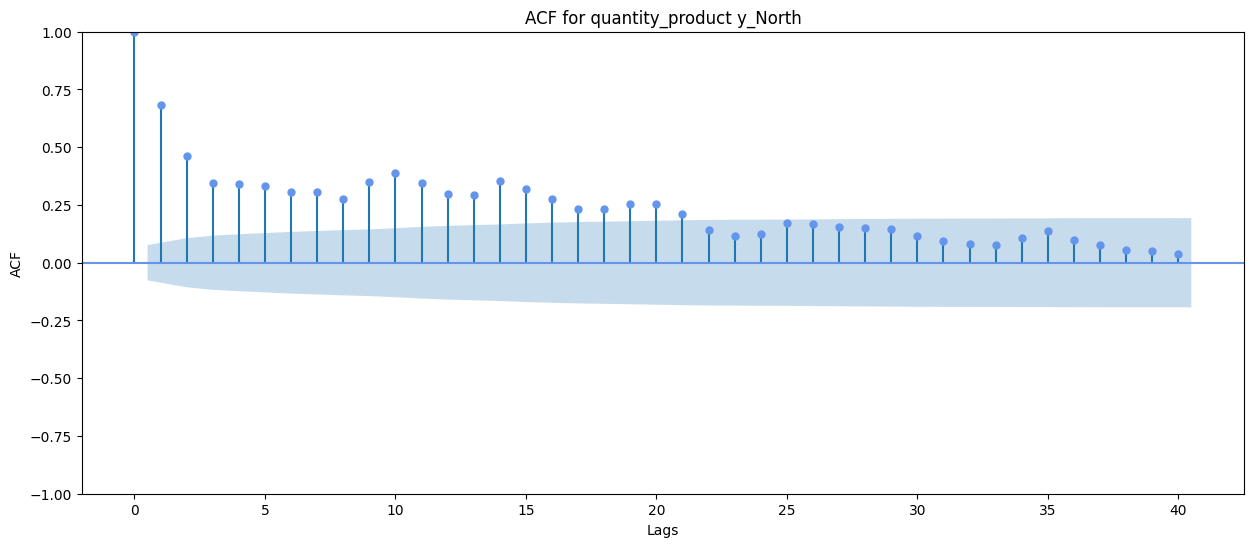

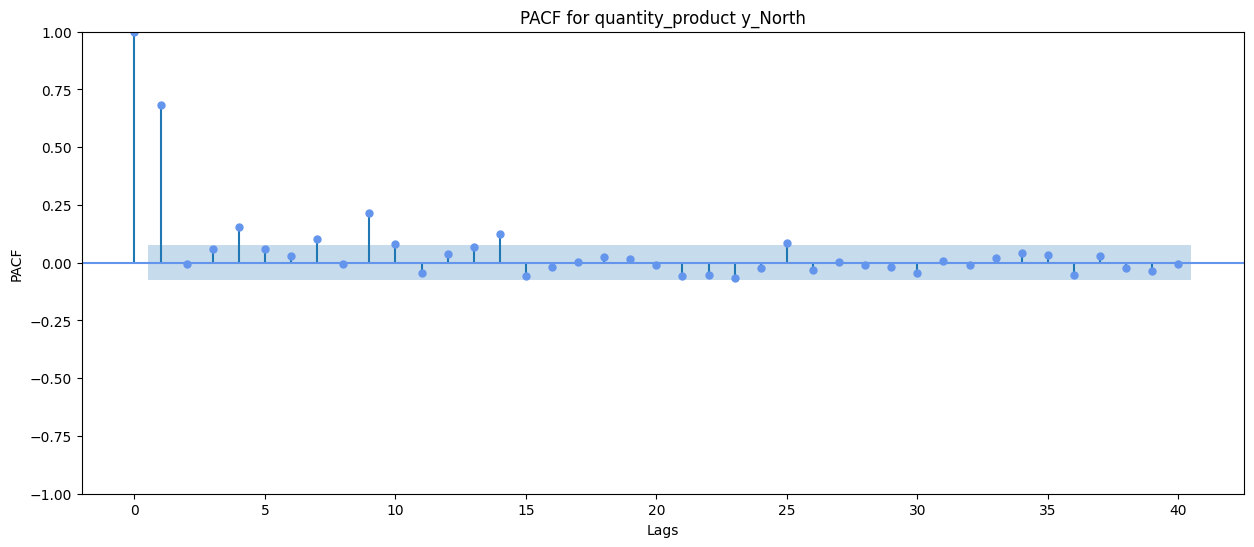

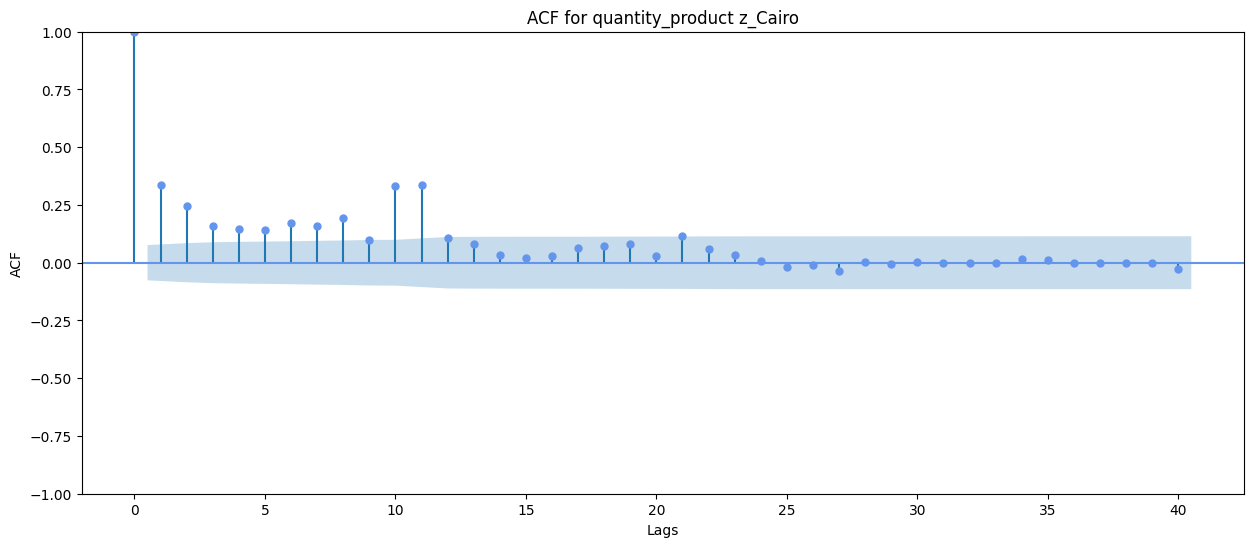

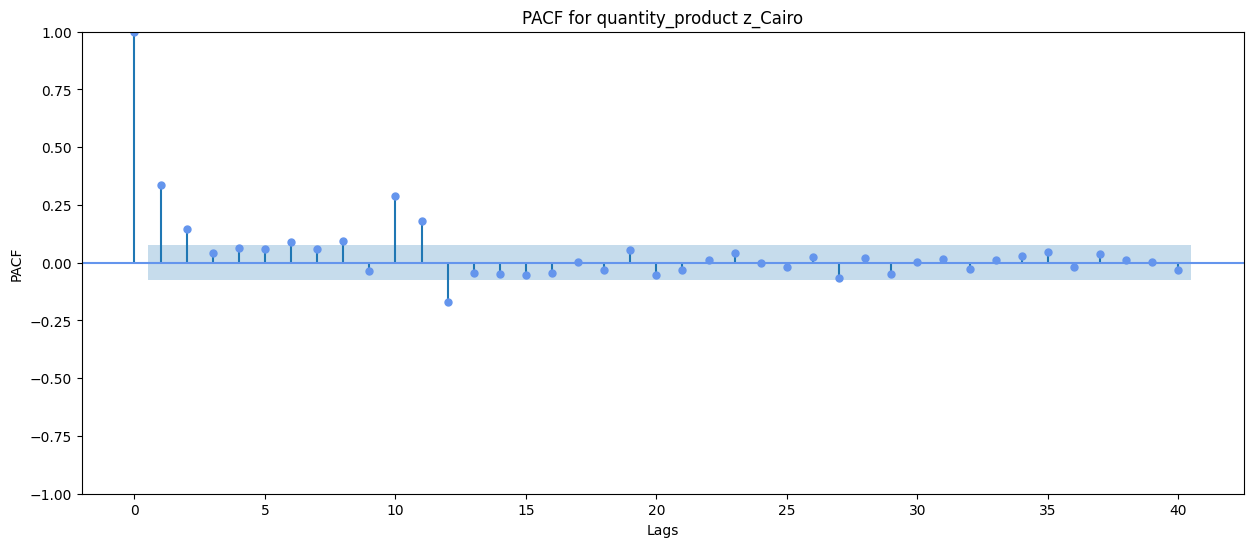

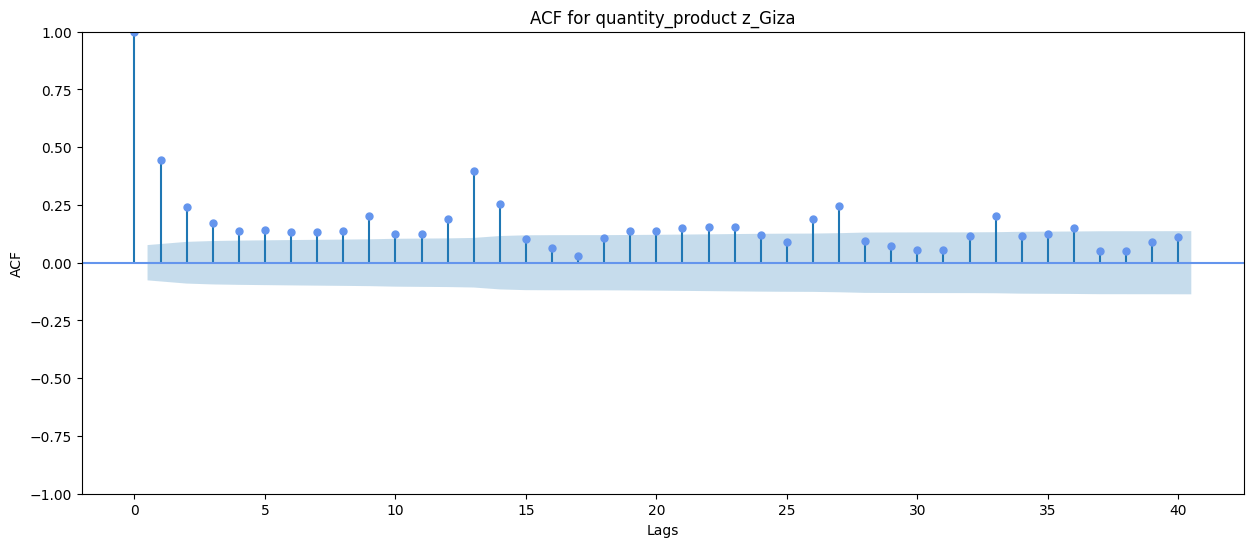

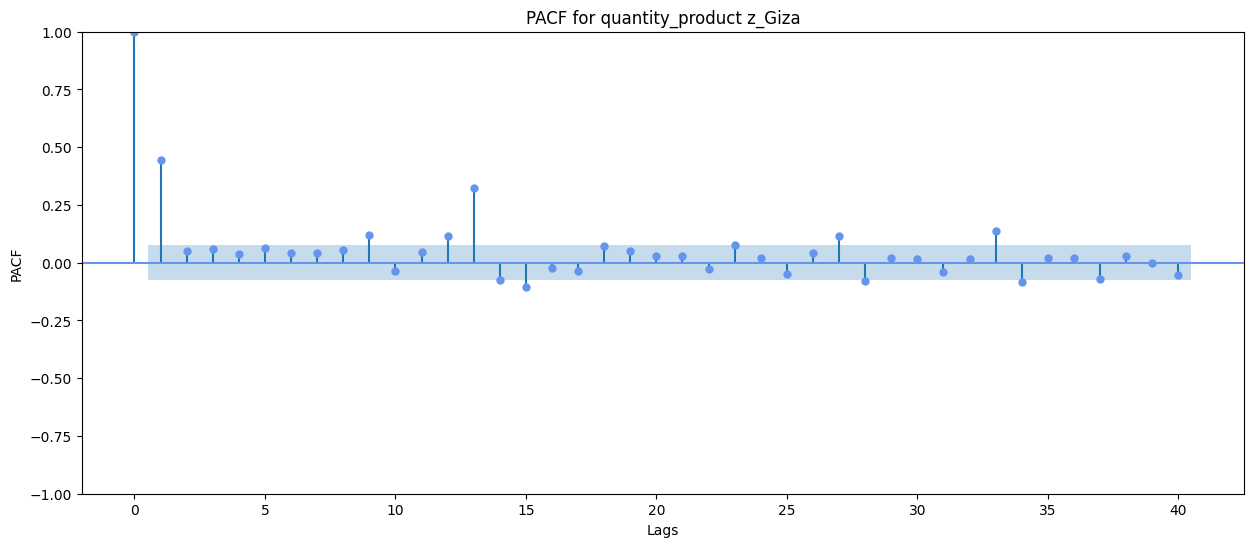

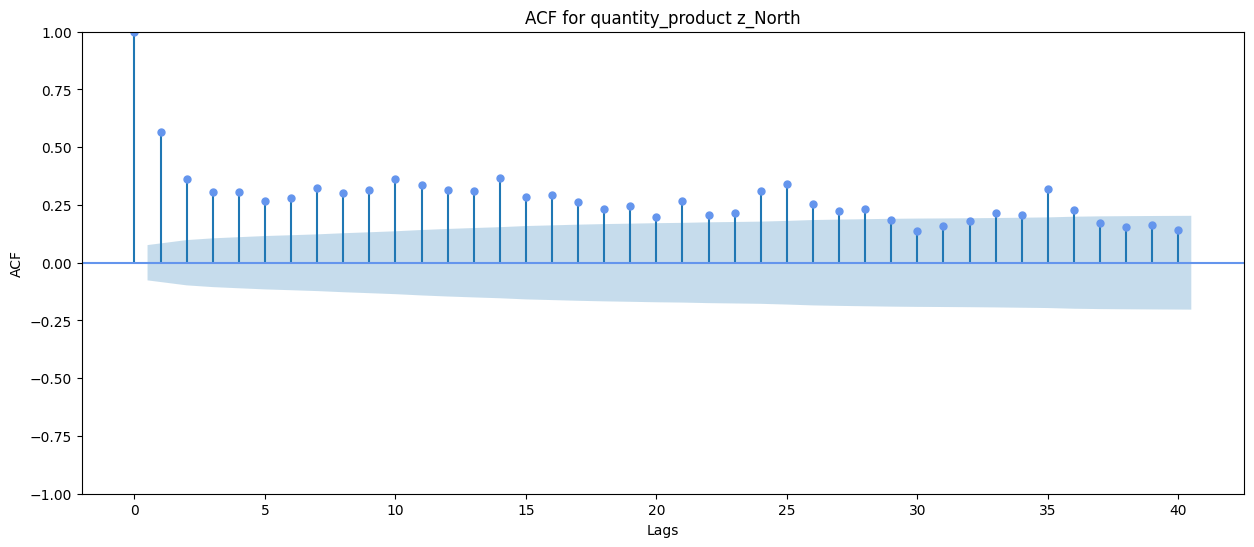

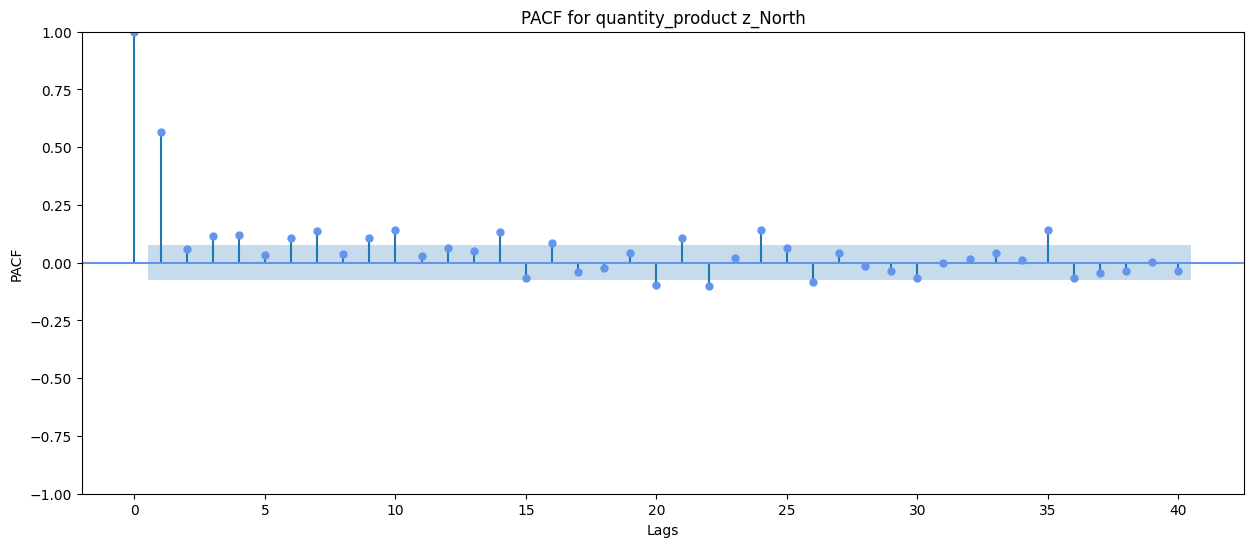

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Loop through your target columns and plot ACF and PACF
for col in out_cols:
    # Plot ACF
    plt.figure(figsize=(15, 6))
    plot_acf(pivot_df_resampled[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'ACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(15, 6))
    plot_pacf(pivot_df_resampled[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'PACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.show()


### Conclusion

series is non stationary and have seasonal component which leads us to use LightGBM algorithm .

# Model

## Traditional model ( LightGBM )

### Why


*   since our series is multivariant and non stationary and has seasonal component .

*   we have alot of features (dimensions) .

*   28 input features (exogenous) + 9 output targets (endogenous) .

**so i decided to use LightGBM .**

NOTE : another alternative to use 9 SARIMAX models .

### Data Preparation

In [ ]:
y = pivot_df_resampled[out_cols].diff().dropna()
X = pivot_df_resampled.drop(out_cols, axis=1)

### Feature Engineering

In [ ]:
pivot_df_diff = pivot_df_resampled.copy()
# For each target (e.g., quantity_x_cairo)
for target in out_cols:
    # Lagged targets
    for lag in [1, 7, 14]:
        pivot_df_diff[f'{target}_lag{lag}'] = pivot_df_diff[target].shift(lag)

    # Rolling stats
    pivot_df_diff[f'{target}_rolling7'] = pivot_df_diff[target].rolling(7).mean()

# For key exogenous features (e.g., price_x)
exogenous_features = X.columns

for feature in exogenous_features:
    # Lagged exogenous features
    for lag in [1, 7]:
        pivot_df_diff[f'{feature}_lag{lag}'] = pivot_df_diff[feature].shift(lag)

<ipython-input-347-c899b8eee507>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_diff[f'{feature}_lag{lag}'] = pivot_df_diff[feature].shift(lag)
<ipython-input-347-c899b8eee507>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_diff[f'{feature}_lag{lag}'] = pivot_df_diff[feature].shift(lag)
<ipython-input-347-c899b8eee507>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

adding lagged versions LightGBM (like most tree-based models) does not inherently understand temporal pattern we must explicitly create features to capture:Trends,Seasonality and Lag Effects .

In [ ]:
y = pivot_df_diff[out_cols]
X = pivot_df_diff.drop(out_cols, axis=1)

### Train , Test split

In [ ]:
X_test= X[:10]
y_test= y[:10]
X = X[10:]
y = y[10:]
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Model Training with LightGBM


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize LightGBM model
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,   # L1 regularization
    reg_lambda=0.1   # L2 regularization
)

# Wrap for multi-output regression
model = MultiOutputRegressor(lgbm)

# Train
model.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.8,
                                             learning_rate=0.05, max_depth=7,
                                             n_estimators=1000,
                                             objective='regression',
                                             reg_alpha=0.1, reg_lambda=0.1,
                                             subsample=0.8))

### Hyperparameter Tuning (Randomized Search)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__n_estimators': [500, 1000, 1500],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [5, 7, 9],
    'estimator__subsample': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2
)
# search.fit(X_train, y_train)
# best_model = search.best_estimator_

###Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_model.predict(X_test)

for i, target in enumerate(y.columns):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print(f"{target}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

### Interpretation

MAE about 2 in averge which means predictions is off by 2 units and RMSE about 6 in average so RMSE > MAE means Model predicts zeros well but struggles with sales spikes.


### Concolusion

We need alot of hand crafted feature engineering .

## Deep learning model ( LSTM )

 -----------------------------------------------------------------------------------------------------------------------------

In [ ]:
from numpy import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Flatten , Input,Masking ,TimeDistributed,RepeatVector ,LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

### Data Preparation


In [468]:
n_steps = 20           # used instances to make prediction
n_features_out=9       # output features
forecast_horizon = 10  # Predict 10 days ahead

In [469]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features (data leakage)
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [470]:
y = pivot_df_resampled_filtered[out_cols]
X = pivot_df_resampled_filtered.drop(out_cols, axis=1)

In [471]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [472]:
dataset = hstack((X_scaled,y))
# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)

n_features_in = X.shape[2]

In [473]:
import datetime
# Define  reference date
reference_date = np.datetime64('2021-03-31')
# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

In [474]:
X = X.astype('float32')
y = y.astype('float32')
X_test= X[:10]
y_test= y[:10]
X = X[10:]
y = y[10:]
test_size = 0.1  # 20% of the data for testing/'/'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (320, 20, 36), y_train shape: (320, 10, 9)
X_test shape: (10, 20, 36), y_test shape: (10, 10, 9)


In [475]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (356, 20, 36)
y shape: (356, 10, 9)


### over sampling

In [476]:
high_sales_mask = (y_train >= 5).any(axis=(1, 2))

X_high = X_train[high_sales_mask]
y_high = y_train[high_sales_mask]

# Combine with original data
X_combined = np.vstack([X_train, X_high])
y_combined = np.vstack([y_train, y_high])

# Flatten y_combined
y_combined = y_combined.reshape(y_combined.shape[0], -1)


In [477]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of high_sales_mask:", high_sales_mask.shape)
# Debug final shapes
print("Final X_combined shape:", X_combined.shape)  # Should match first dimension of y_combined
print("Final y_combined shape:", y_combined.shape)


Shape of X_train: (320, 20, 36)
Shape of y_train: (320, 10, 9)
Shape of high_sales_mask: (320,)
Final X_combined shape: (575, 20, 36)
Final y_combined shape: (575, 90)


Oversample high sales periods to reduce class imbalance .

### LSTM Model Architecture


In [494]:
input_shape = (n_steps, n_features_in)
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features_in)))
model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.85))
model.add(Dense(n_features_out * forecast_horizon,activation='relu'))  # Output layer
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'flatten_10' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_10 (Masking)                 │ (None, 20, 36)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 20, 100)             │          34,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 2000)                │           8,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 90)                  │         180,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,890 (870.66 KB)

 Trainable params: 218,890 (855.04 KB)

 Non-trainable params: 4,000 (15.62 KB)

In [495]:
# plot_model(model, show_shapes=True)

### Model parameters

#### Custom loss function

In [496]:
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

@register_keras_serializable()
def weighted_mae(y_true, y_pred):
    base_weights = tf.where(y_true == 0, 1.0,5.0)
    high_sales_mask = tf.cast(y_true >= 5, tf.float32)
    weights = base_weights + 5.0 * high_sales_mask  # Total weights: 1, 5, or 10
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

Custom loss function penalize zero predictions and highly wights predictions on big values > 5

#### Model training

In [497]:
# Define the optimizer with a custom exponentially decaying learning rate
optimizer = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(optimizer=optimizer, loss=weighted_mae)

In [498]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/NLP/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

adding early stoping to prevent overfitting and callback to save best model .


In [499]:
# Train the model
history = model.fit(X_combined, y_combined,
                    epochs=200,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.8699
Epoch 1: val_loss improved from inf to 7.54533, saving model to /content/drive/MyDrive/NLP/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 7.8387 - val_loss: 7.5453
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.3474
Epoch 2: val_loss improved from 7.54533 to 7.37365, saving model to /content/drive/MyDrive/NLP/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.3560 - val_loss: 7.3736
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.0433
Epoch 3: val_loss improved from 7.37365 to 7.22947, saving model to /content/drive/MyDrive/NLP/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.0632 - val_loss: 7.2295
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.4272
Epoch 4: val_loss improved from 7.22947 to 7.14505, saving model to /content/drive/MyDrive/NLP/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.4268 - val_loss:

#### Visualization

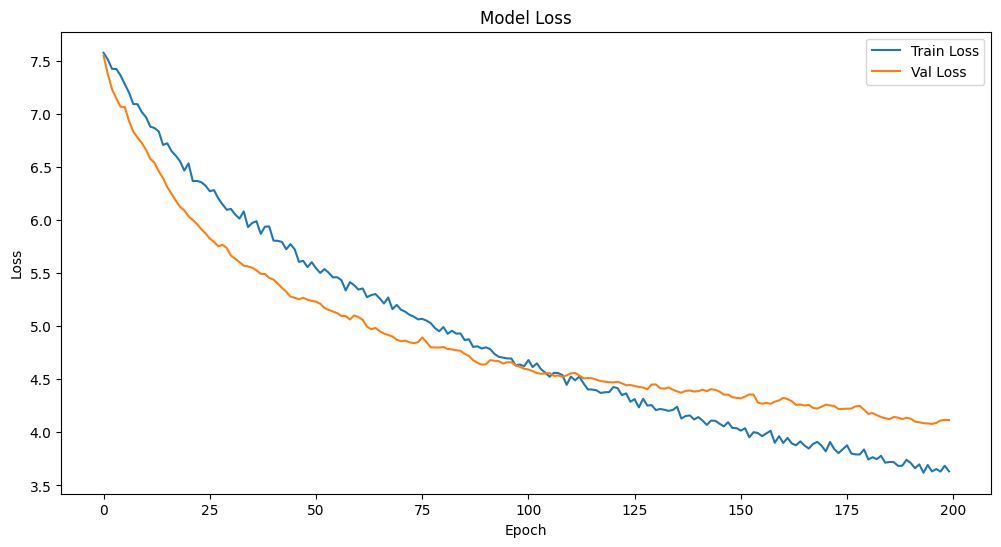

In [500]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Evaluation

In [501]:
from tensorflow.keras.models import load_model
# Load best model
best_model = load_model('/content/drive/MyDrive/NLP/best_model.keras',
                          custom_objects={'weighted_mae': weighted_mae} )

In [502]:
  # Making a prediction
y_pred = best_model.predict(X_test, verbose=0)  # Predict future sequences
y_pred = y_pred.reshape(y_pred.shape[0], forecast_horizon, n_features_out)
y_pred = y_pred.astype('int')
y_test = y_test.astype('int')

Combined shape: (10, 10, 18)
Root Mean Squared Error: 1.6603212540549697
Mean Absolute Error: 0.8433333333333333

Visualizing results for Day 1 of 10


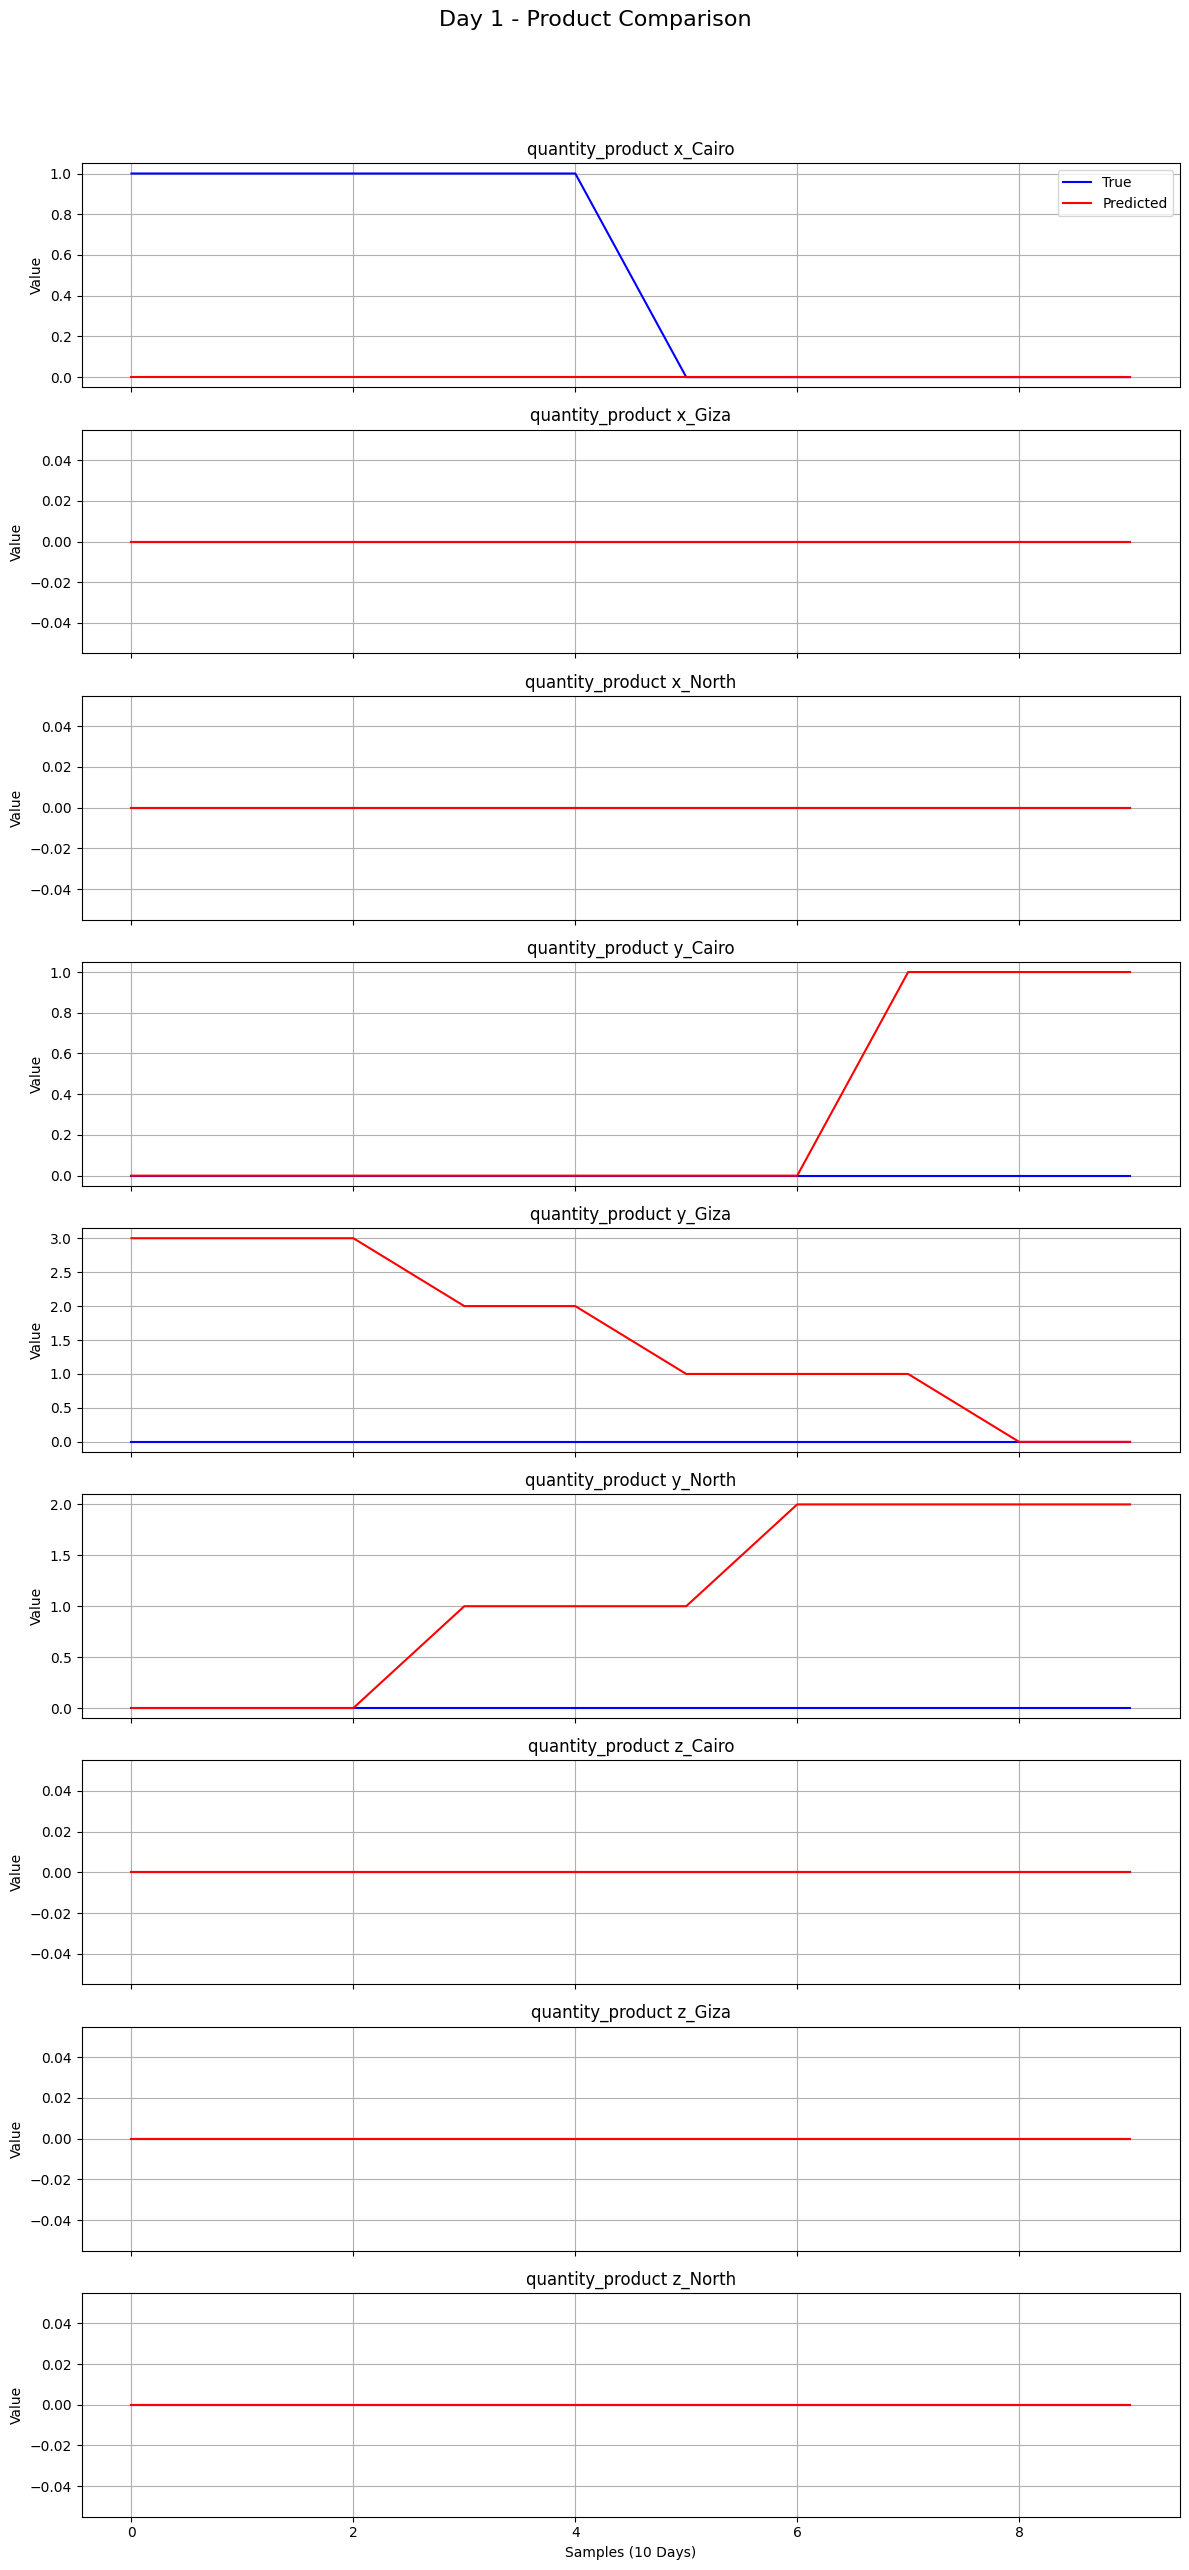


Visualizing results for Day 2 of 10


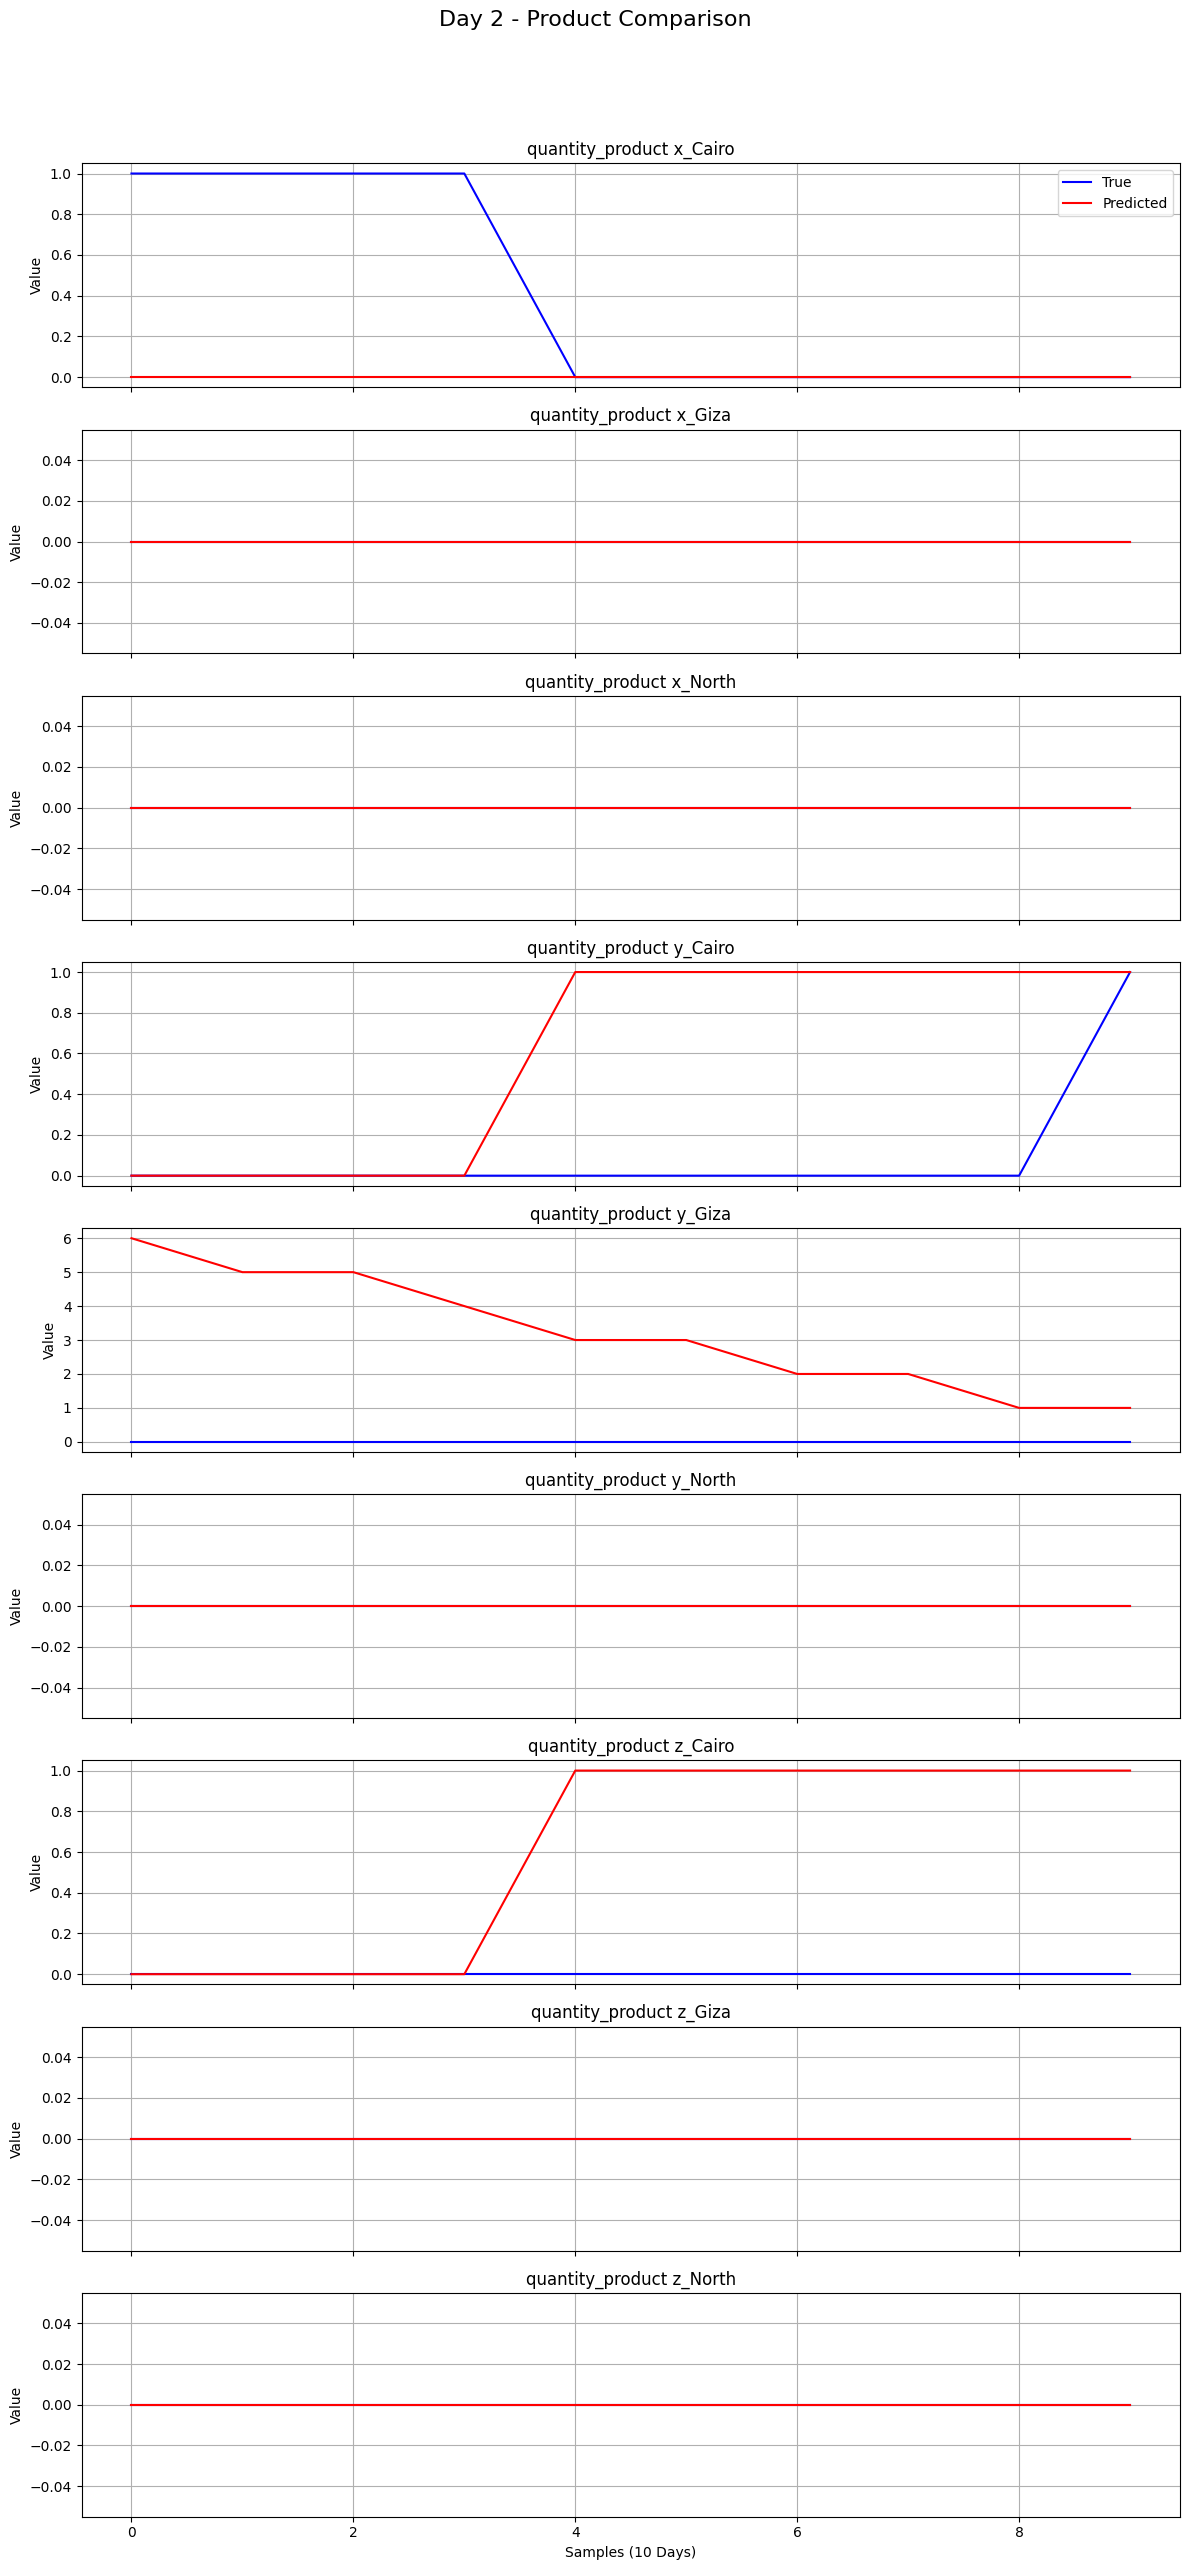


Visualizing results for Day 3 of 10


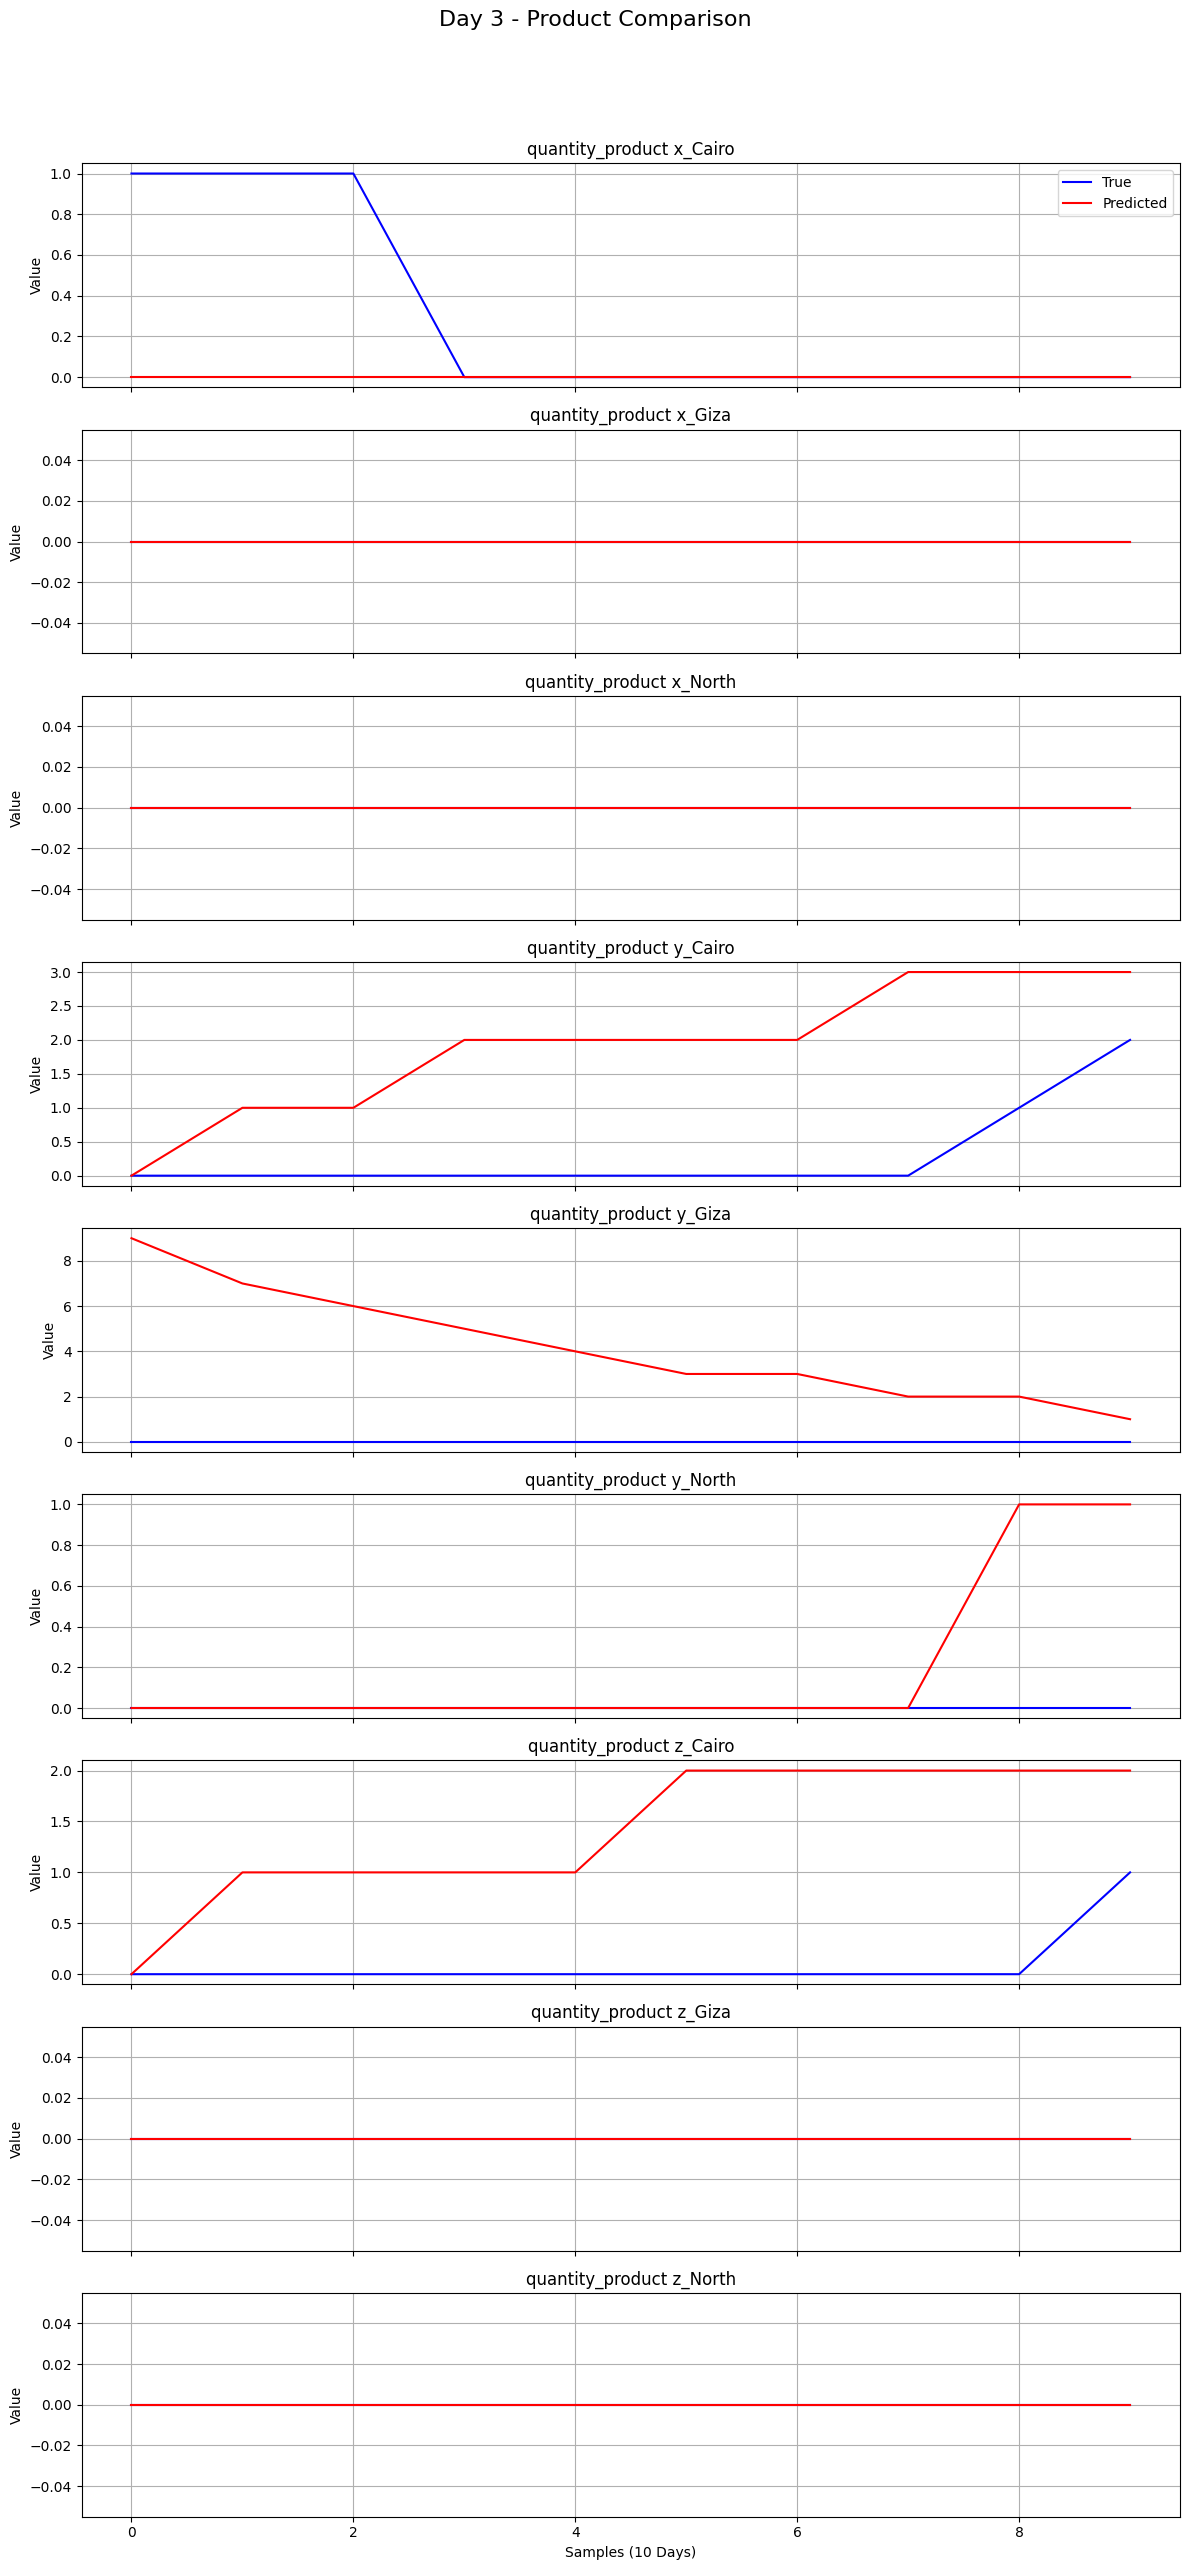


Visualizing results for Day 4 of 10


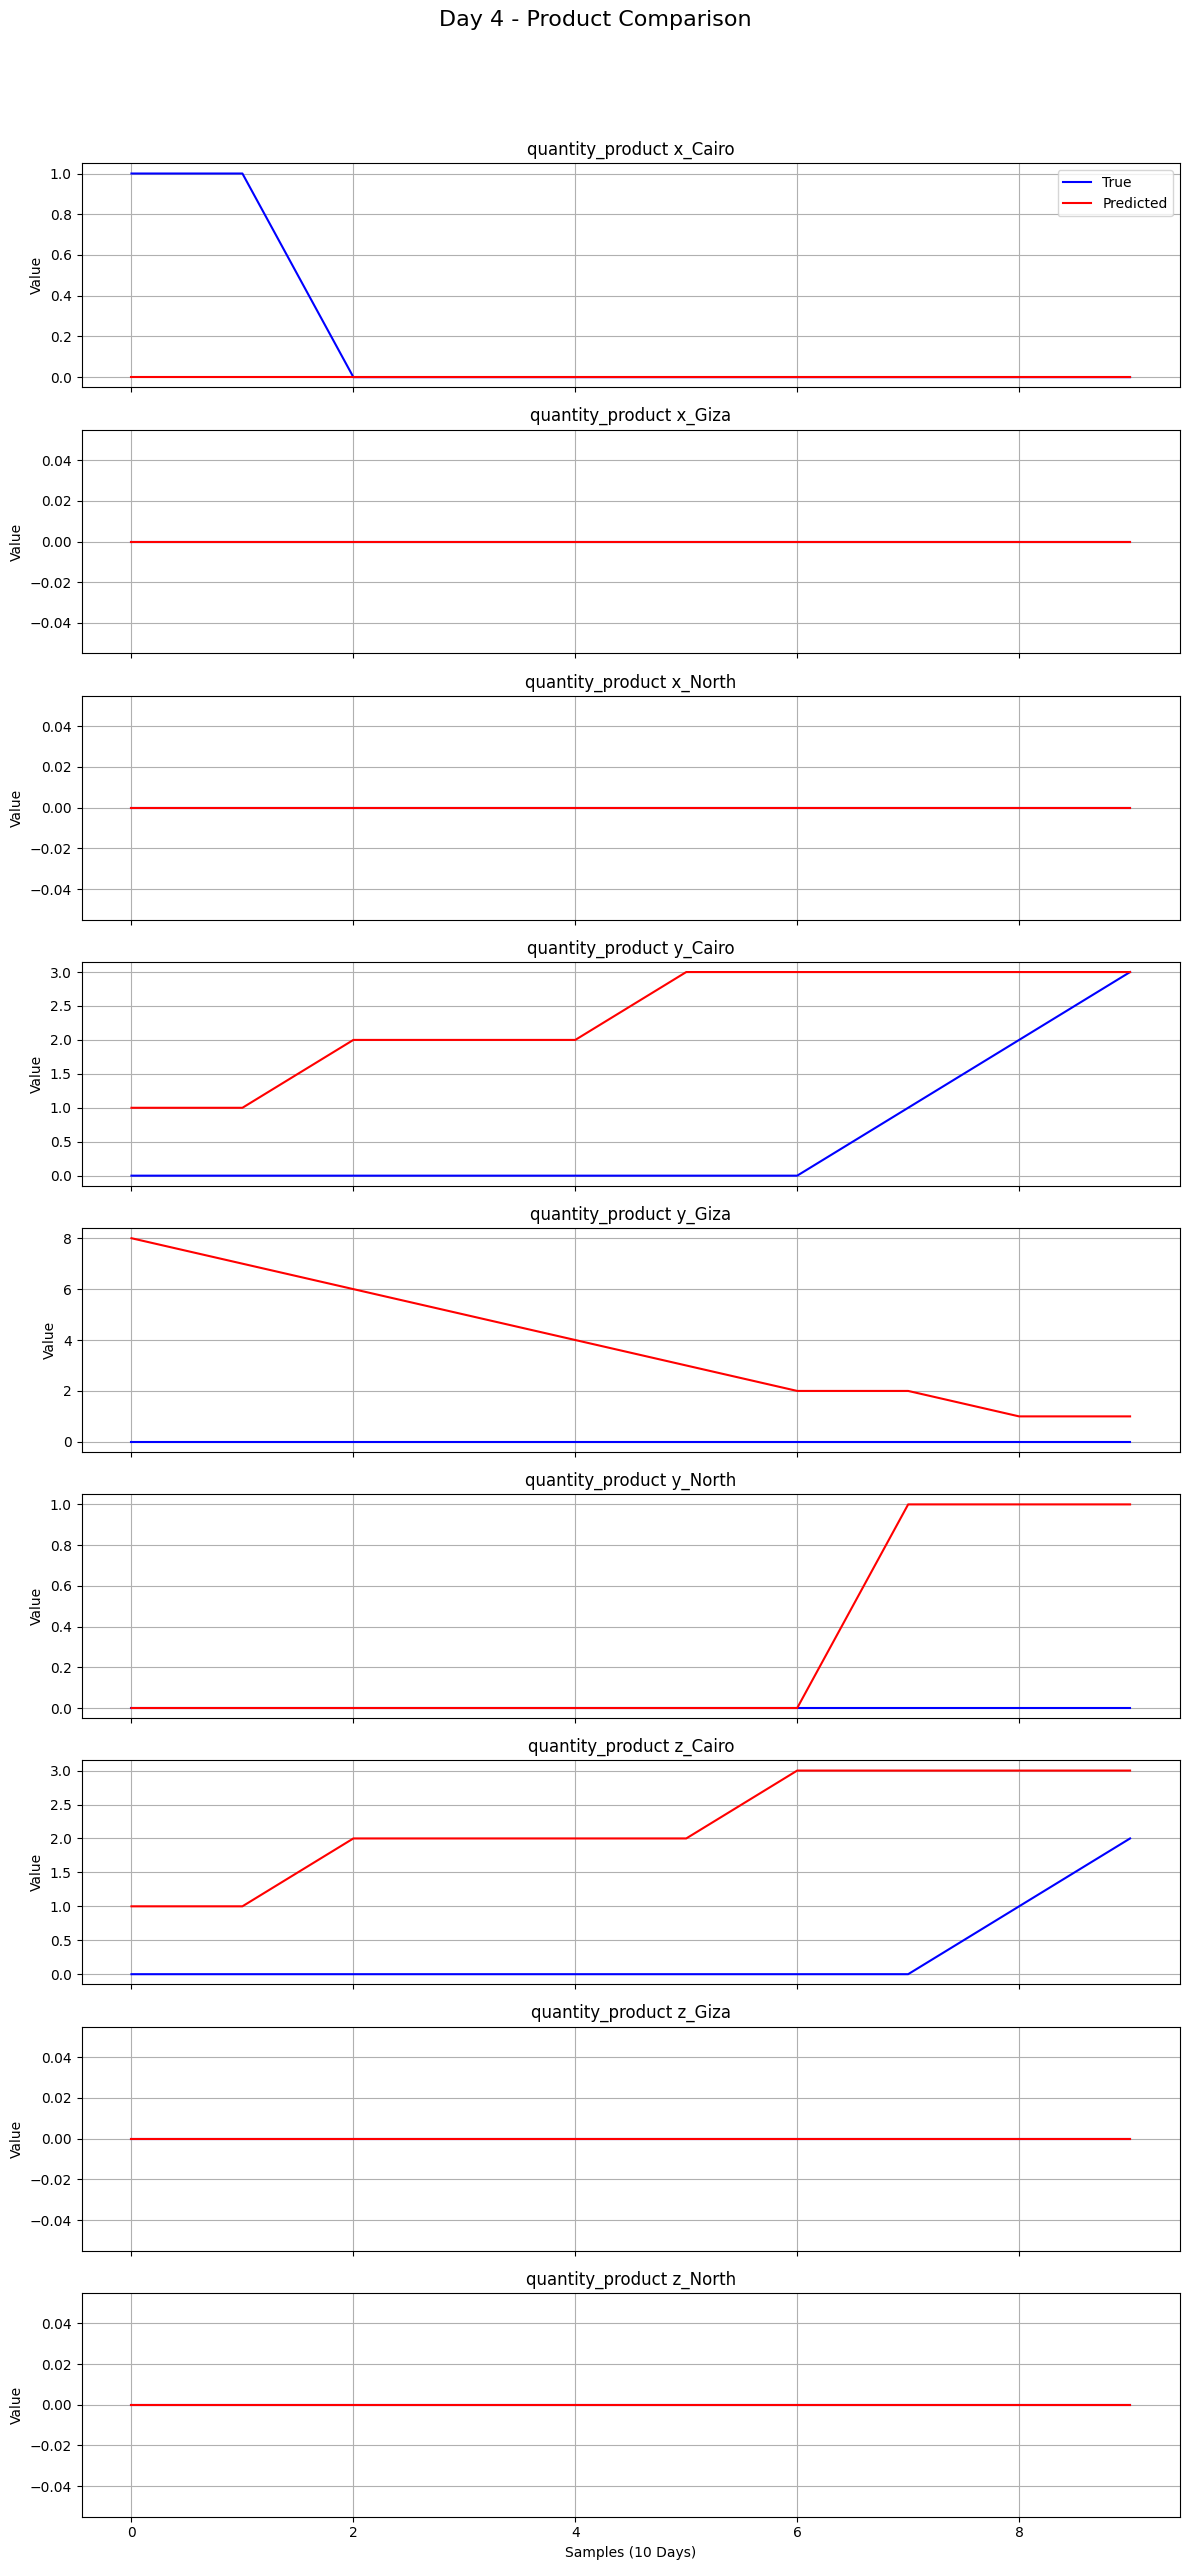


Visualizing results for Day 5 of 10


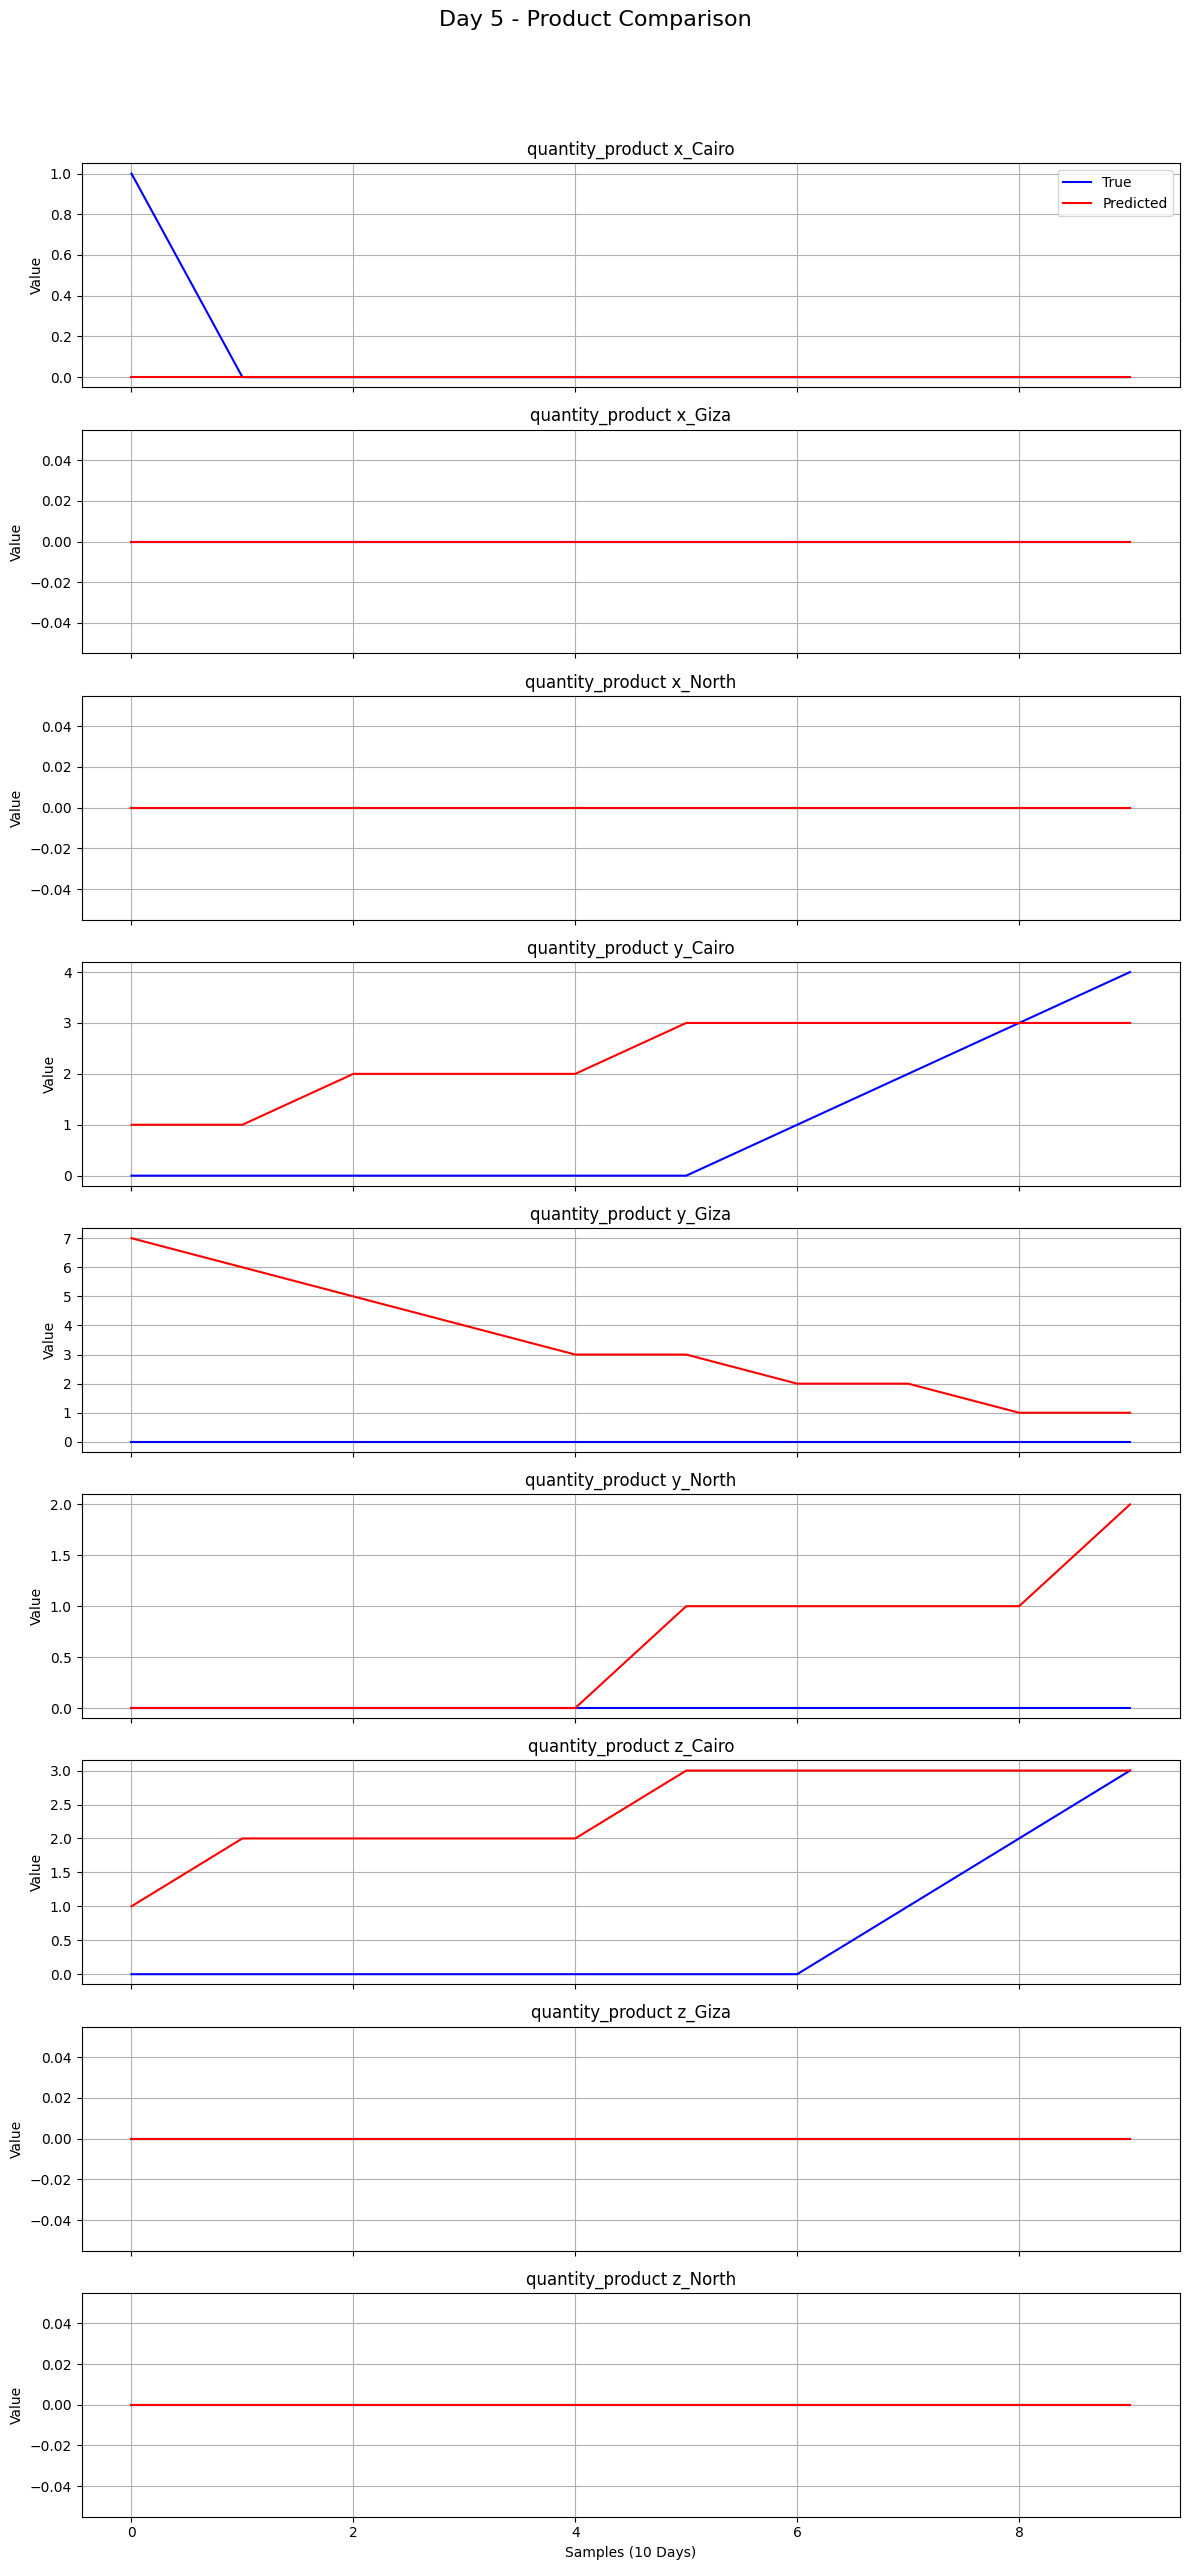


Visualizing results for Day 6 of 10


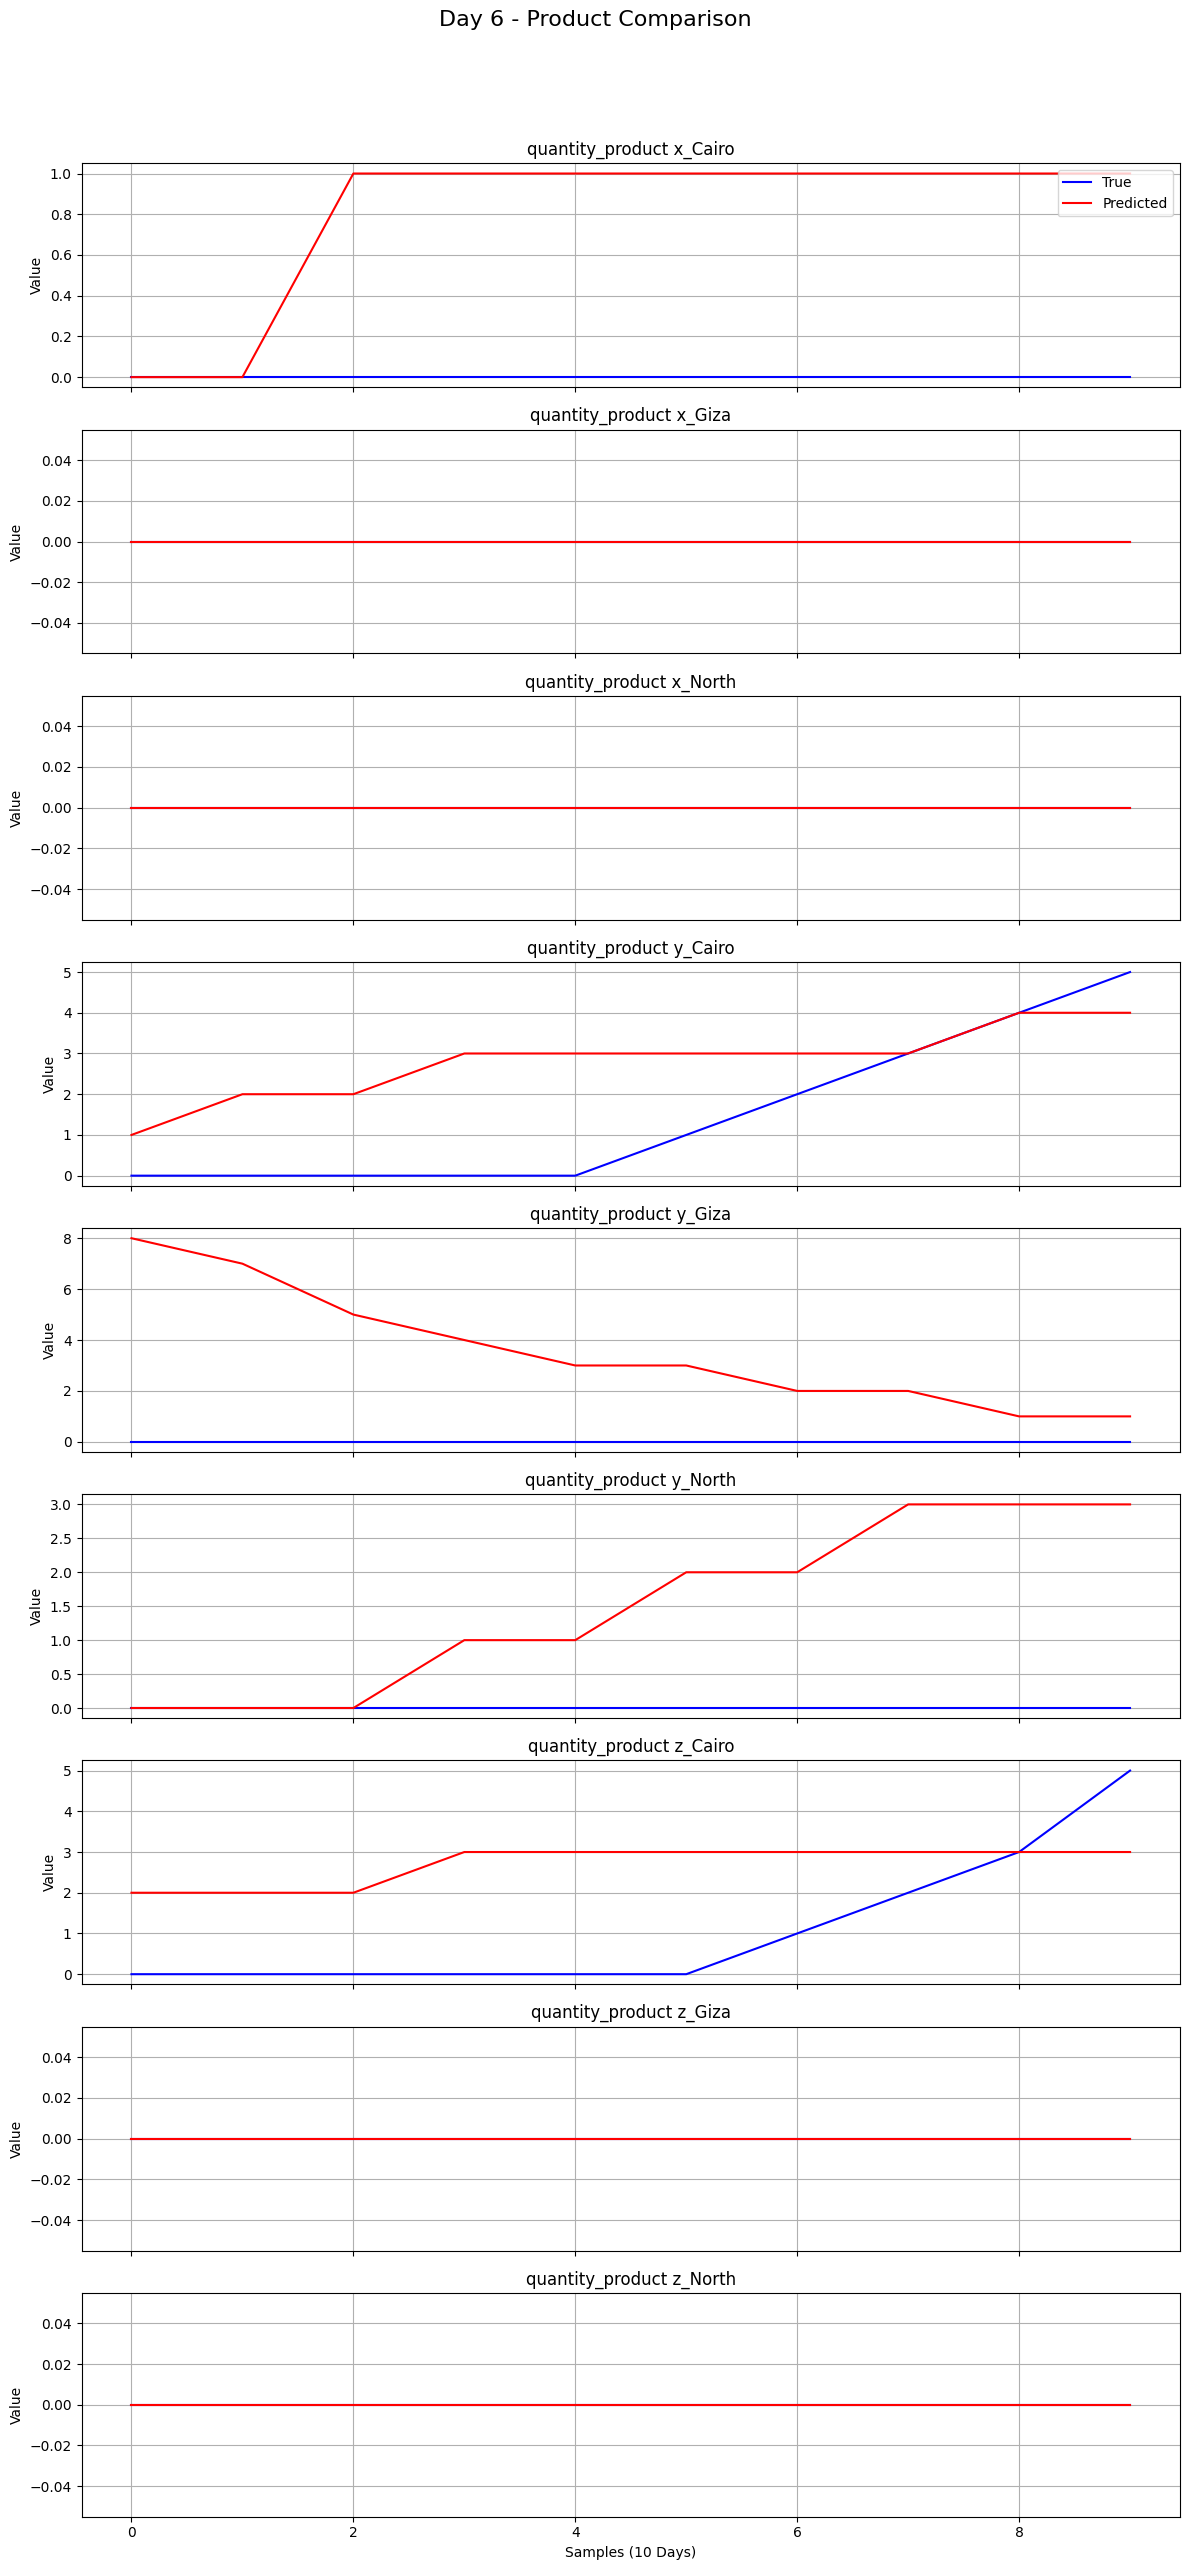


Visualizing results for Day 7 of 10


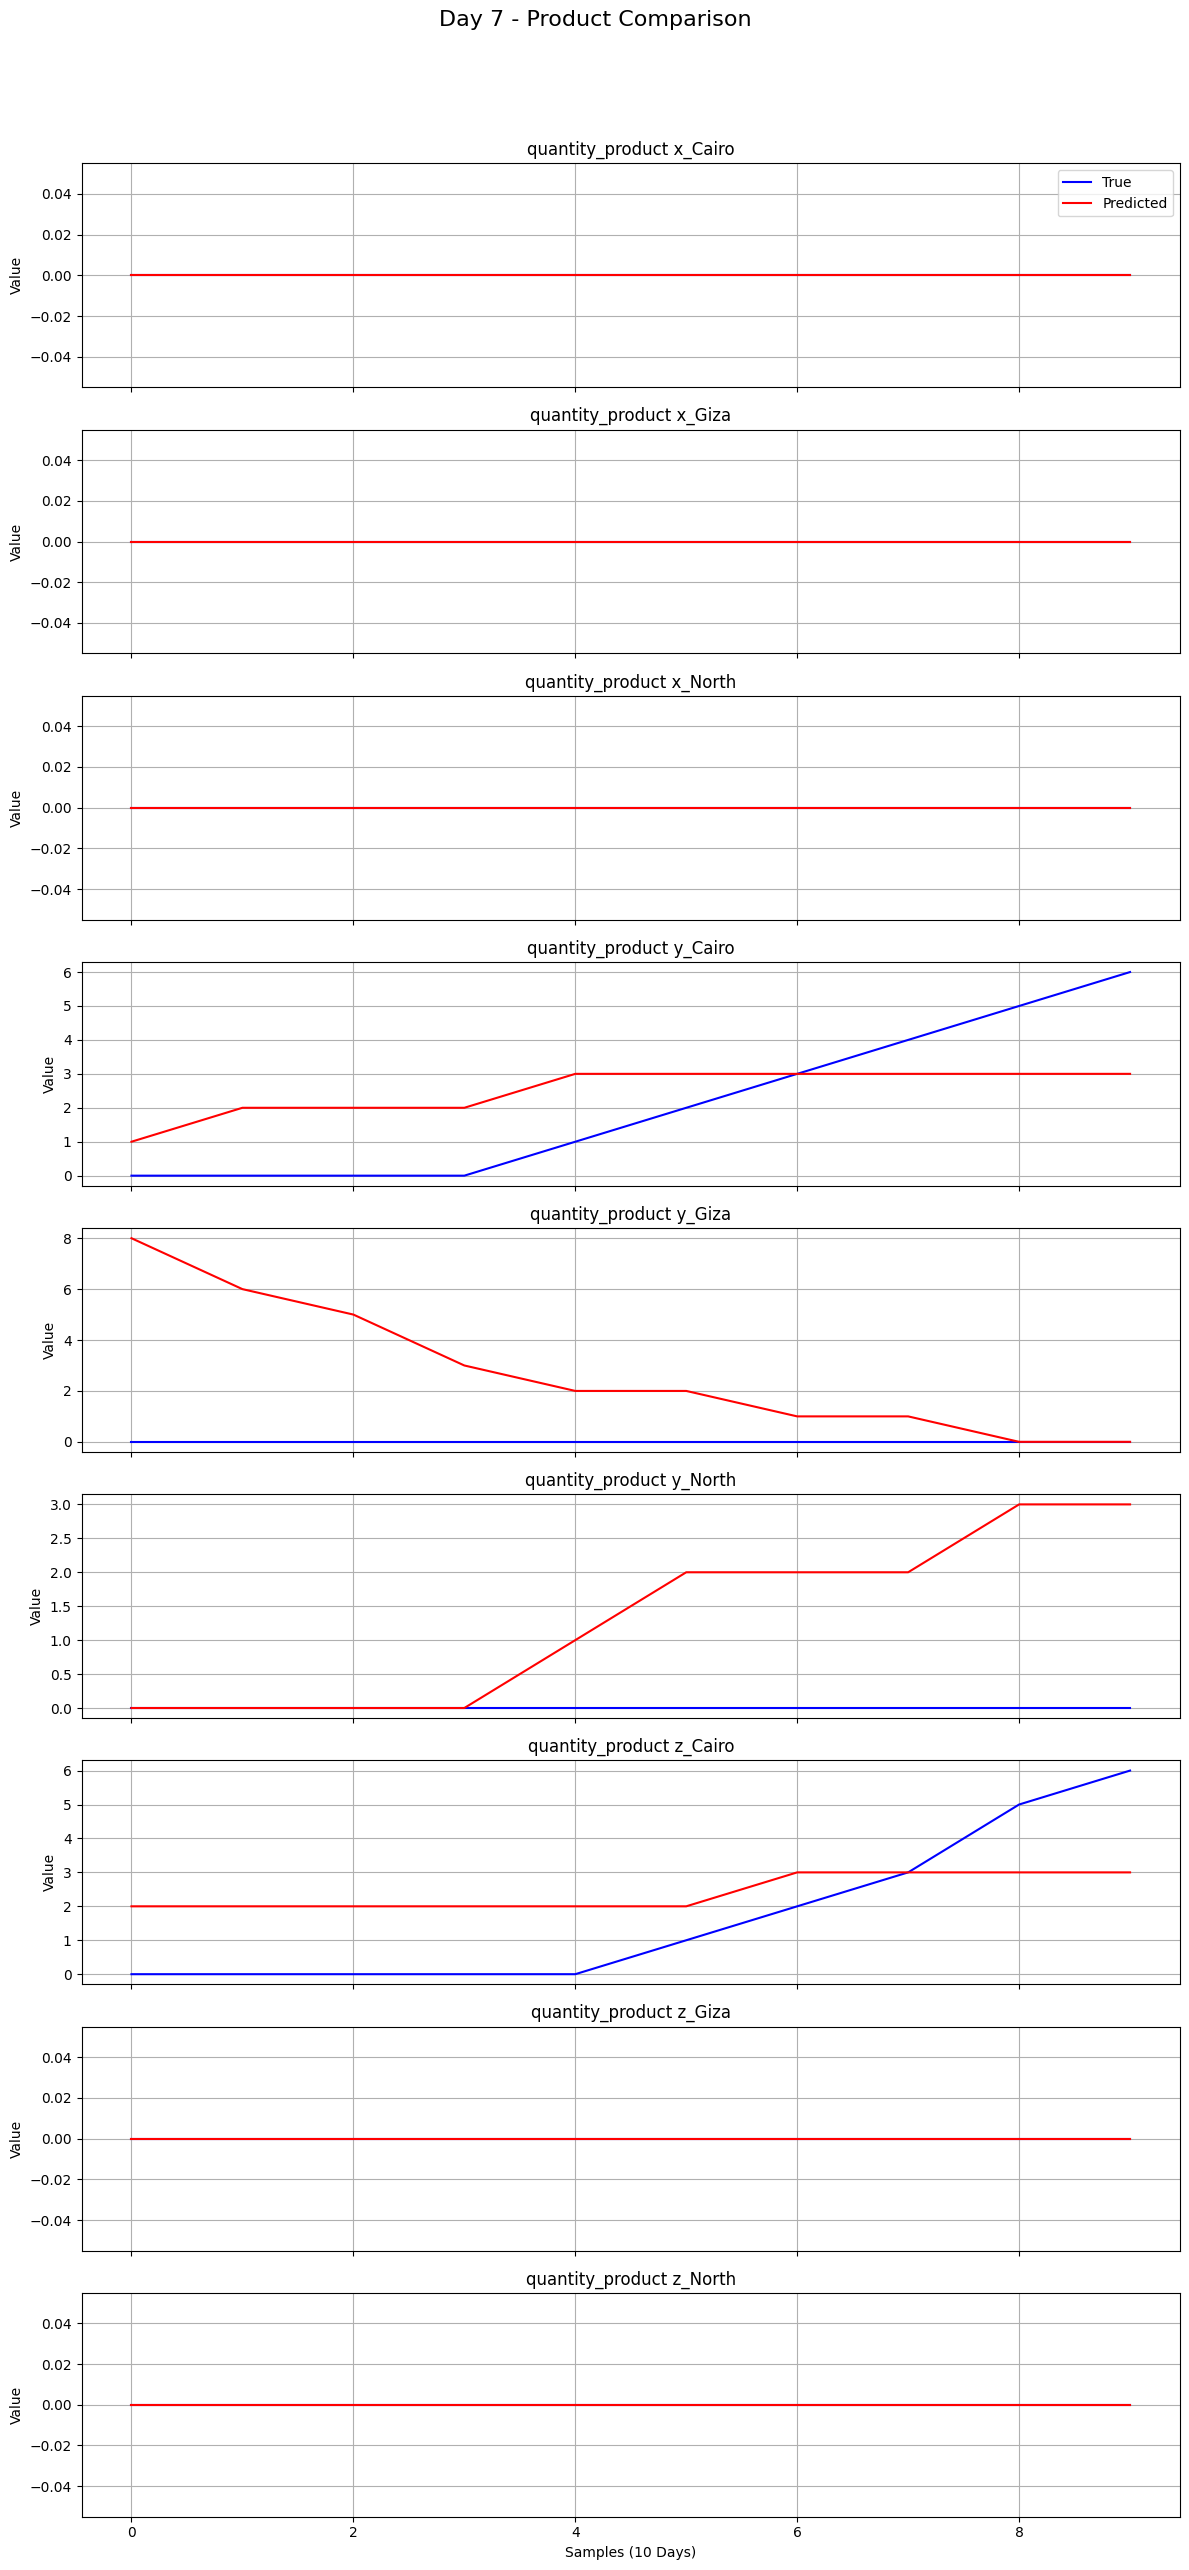


Visualizing results for Day 8 of 10


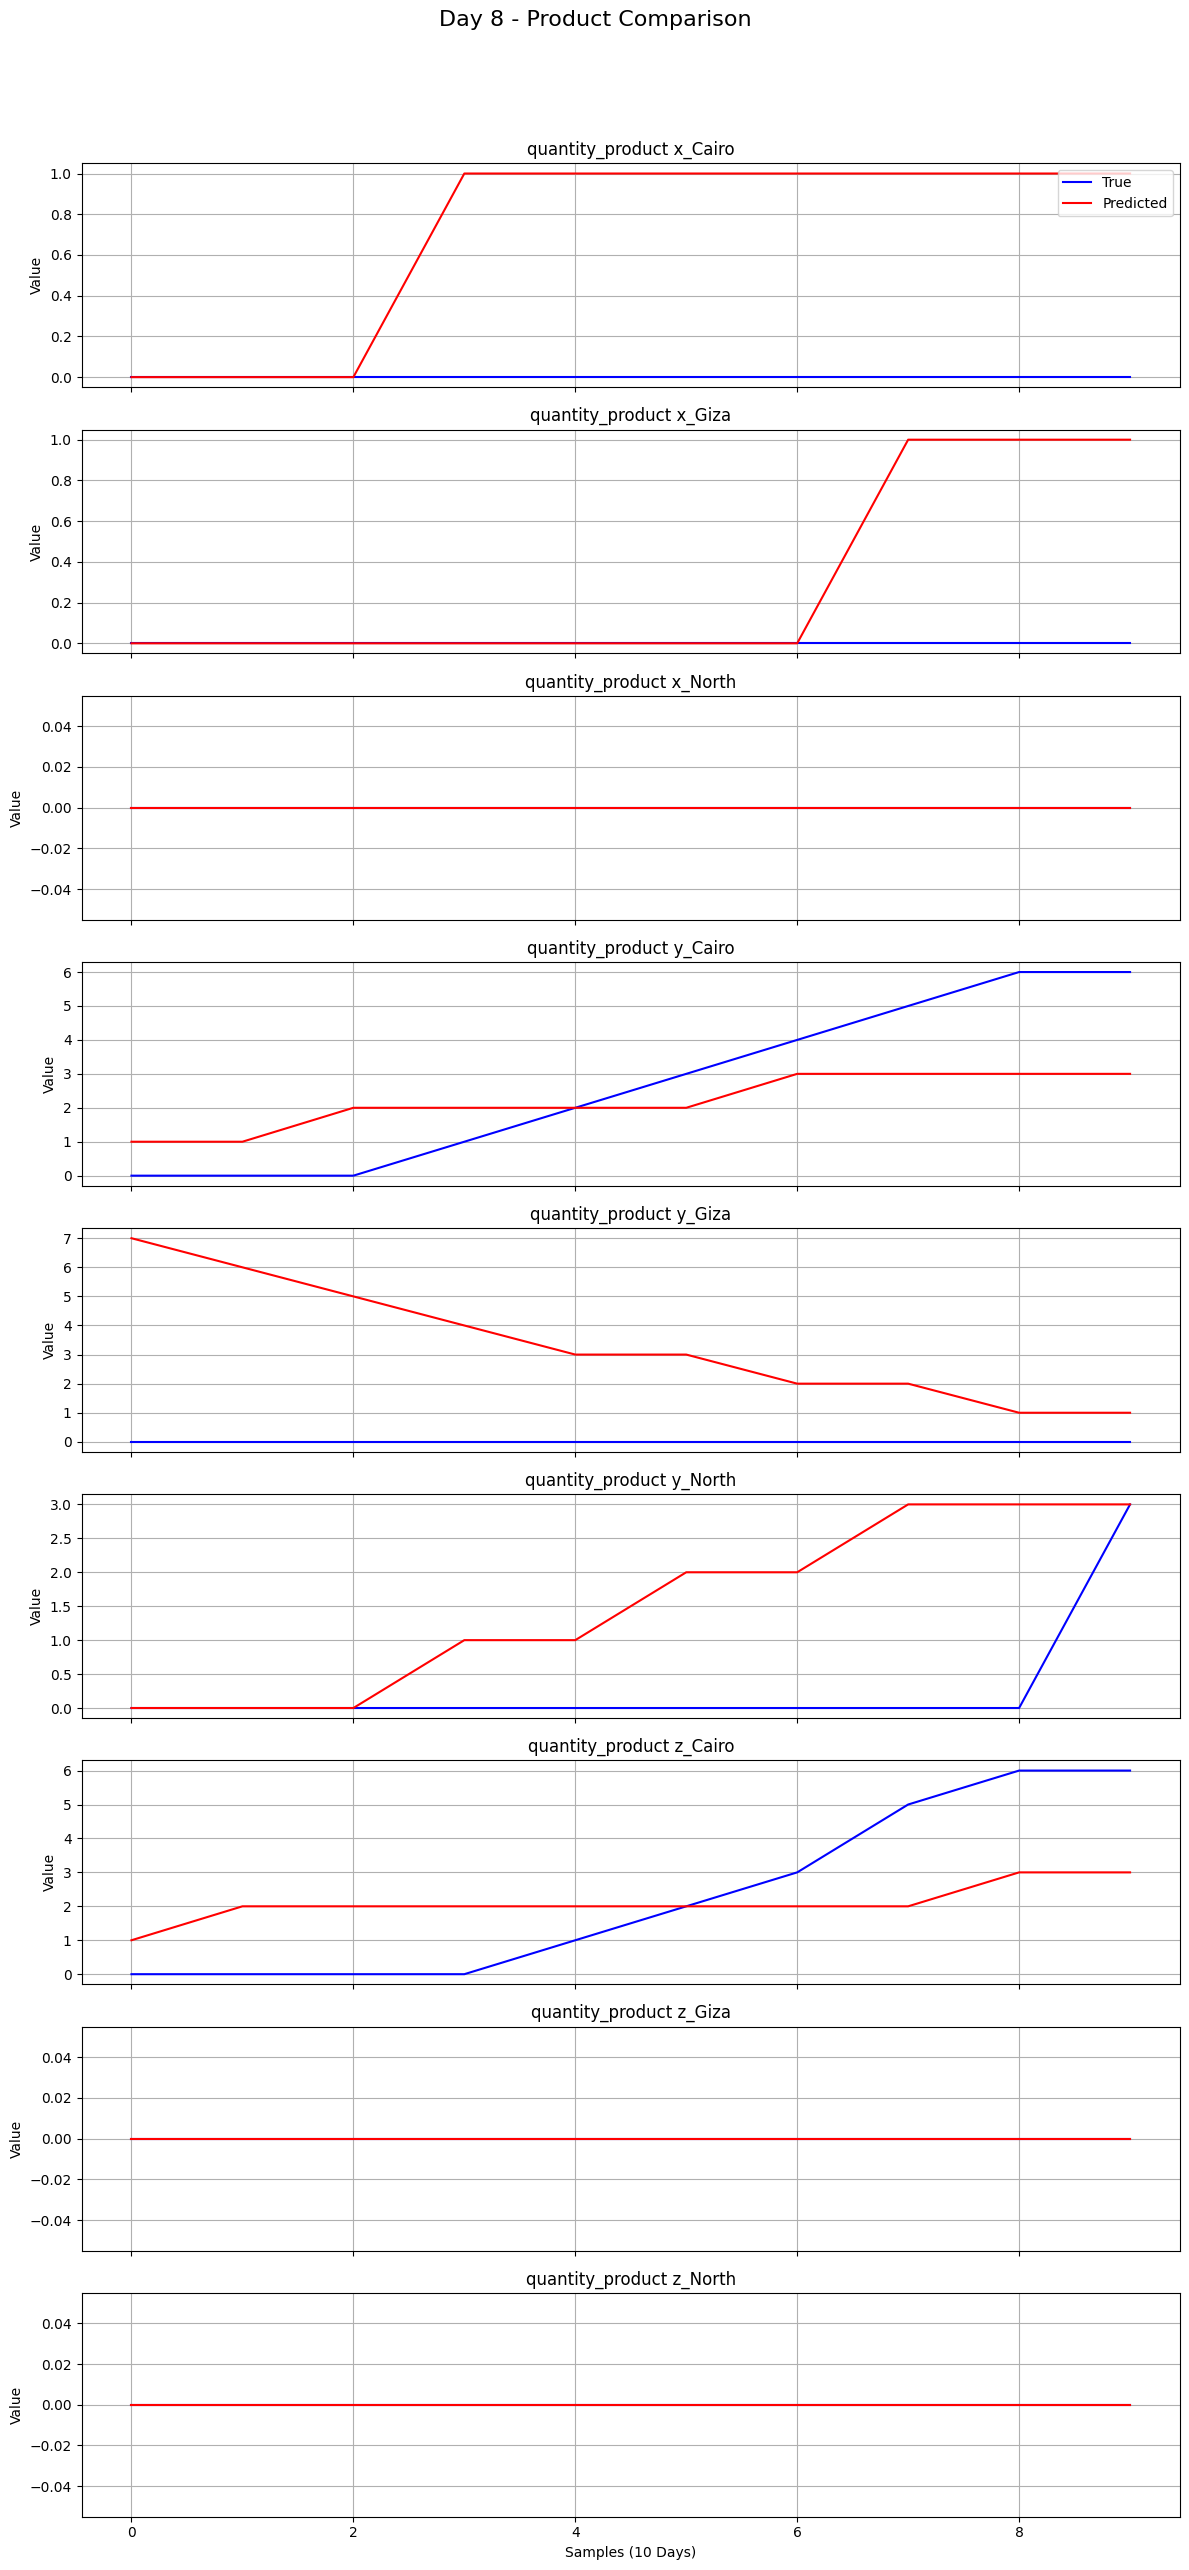


Visualizing results for Day 9 of 10


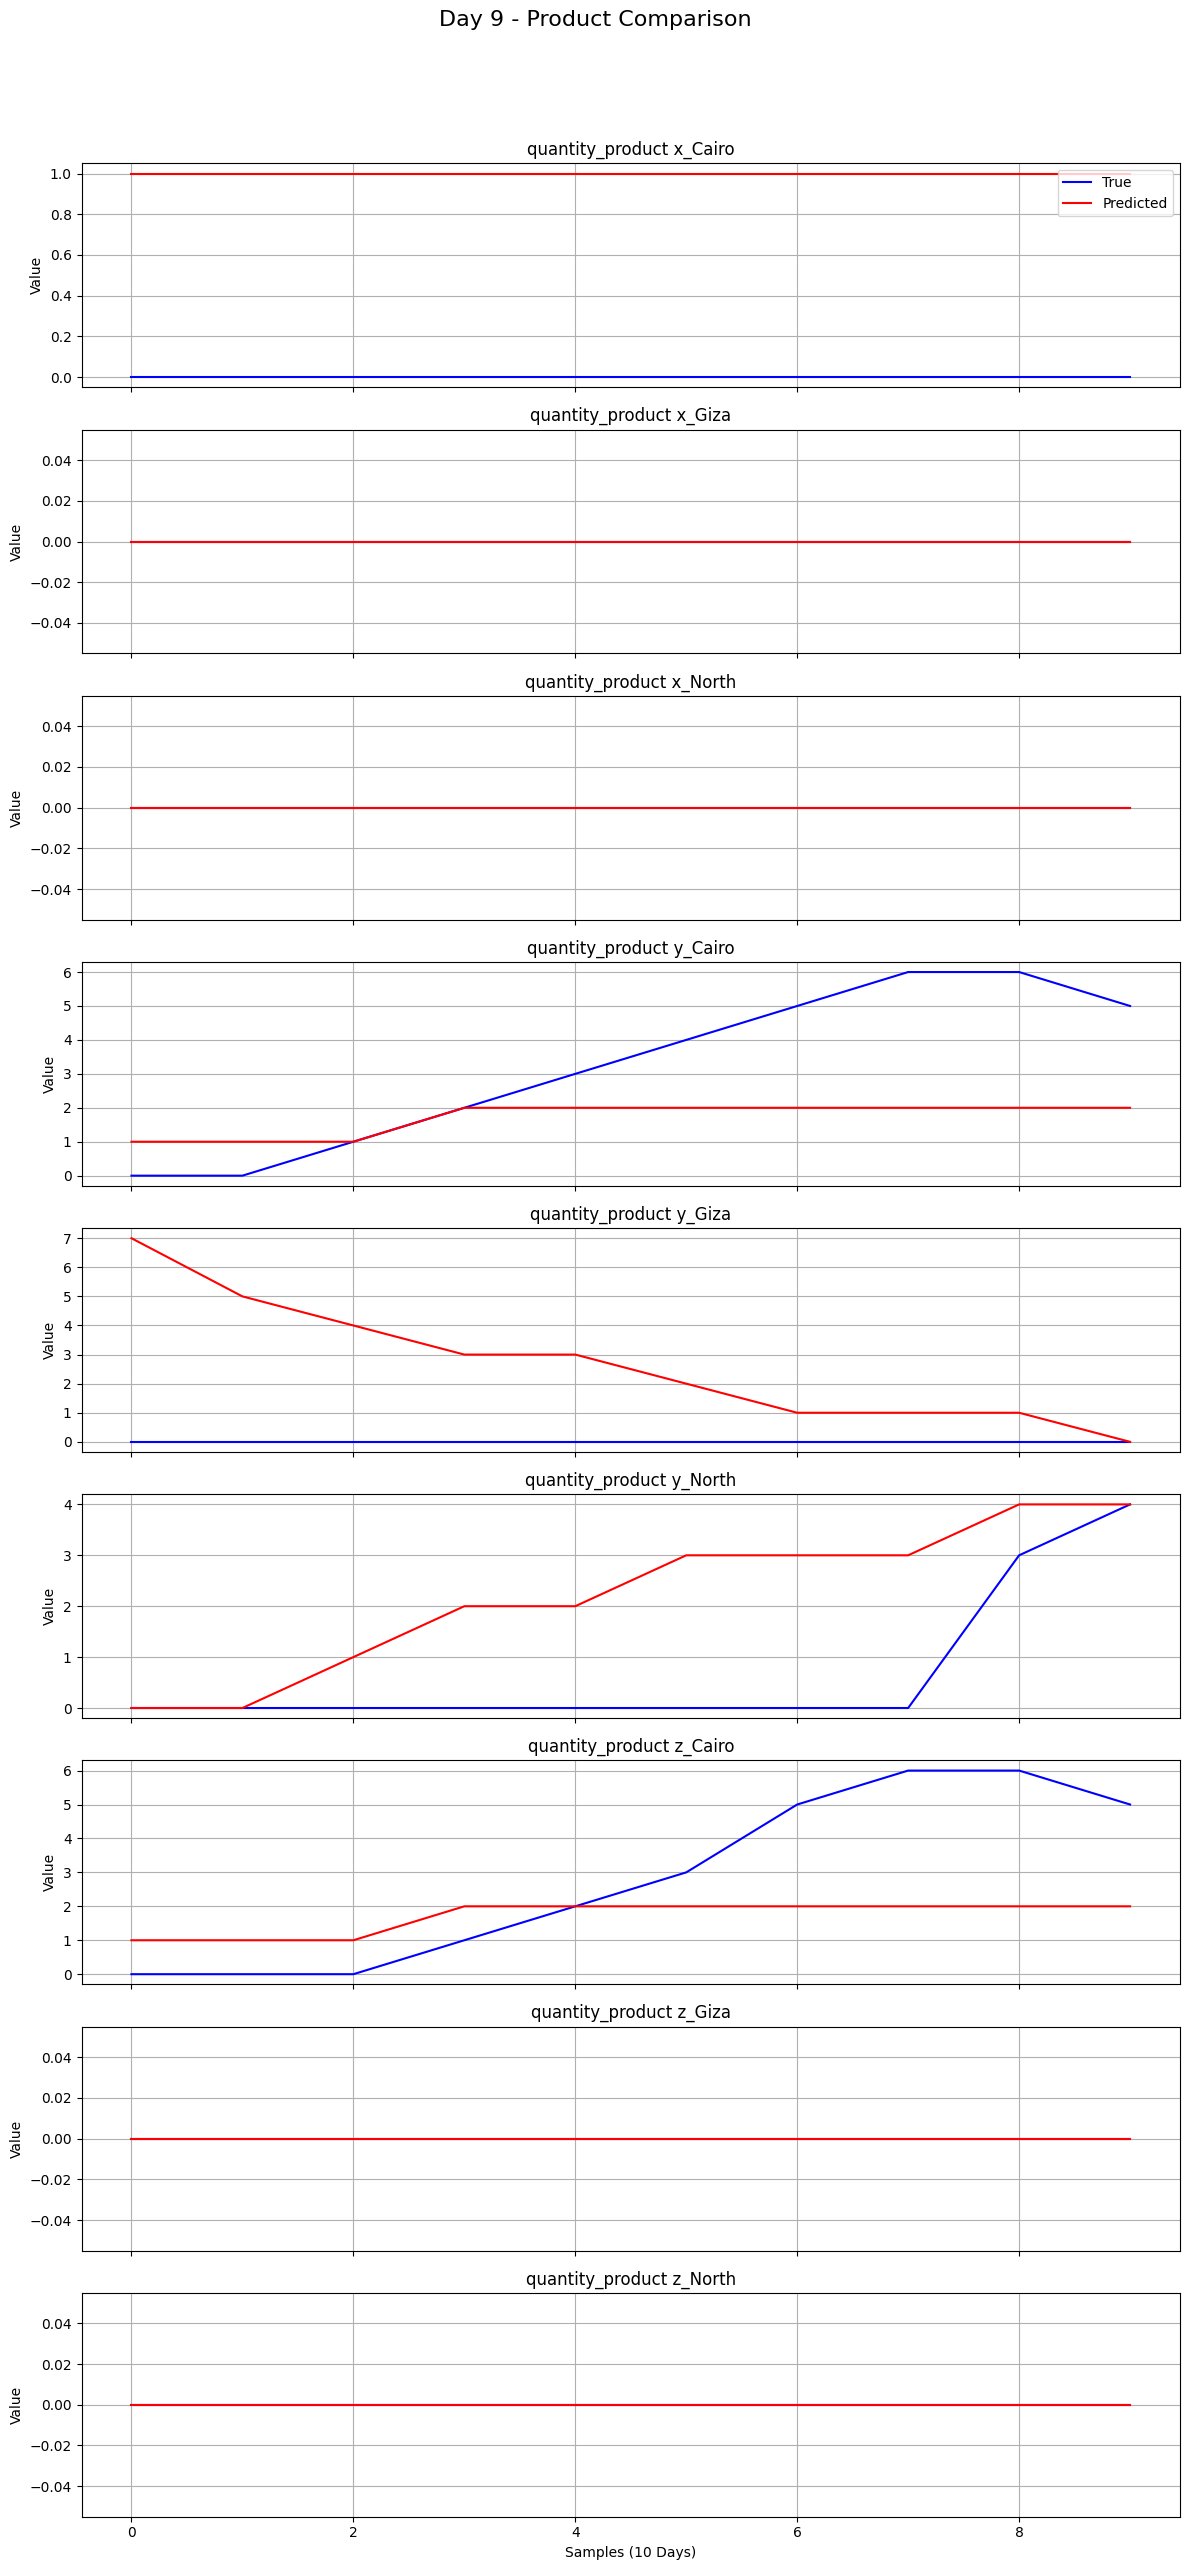


Visualizing results for Day 10 of 10


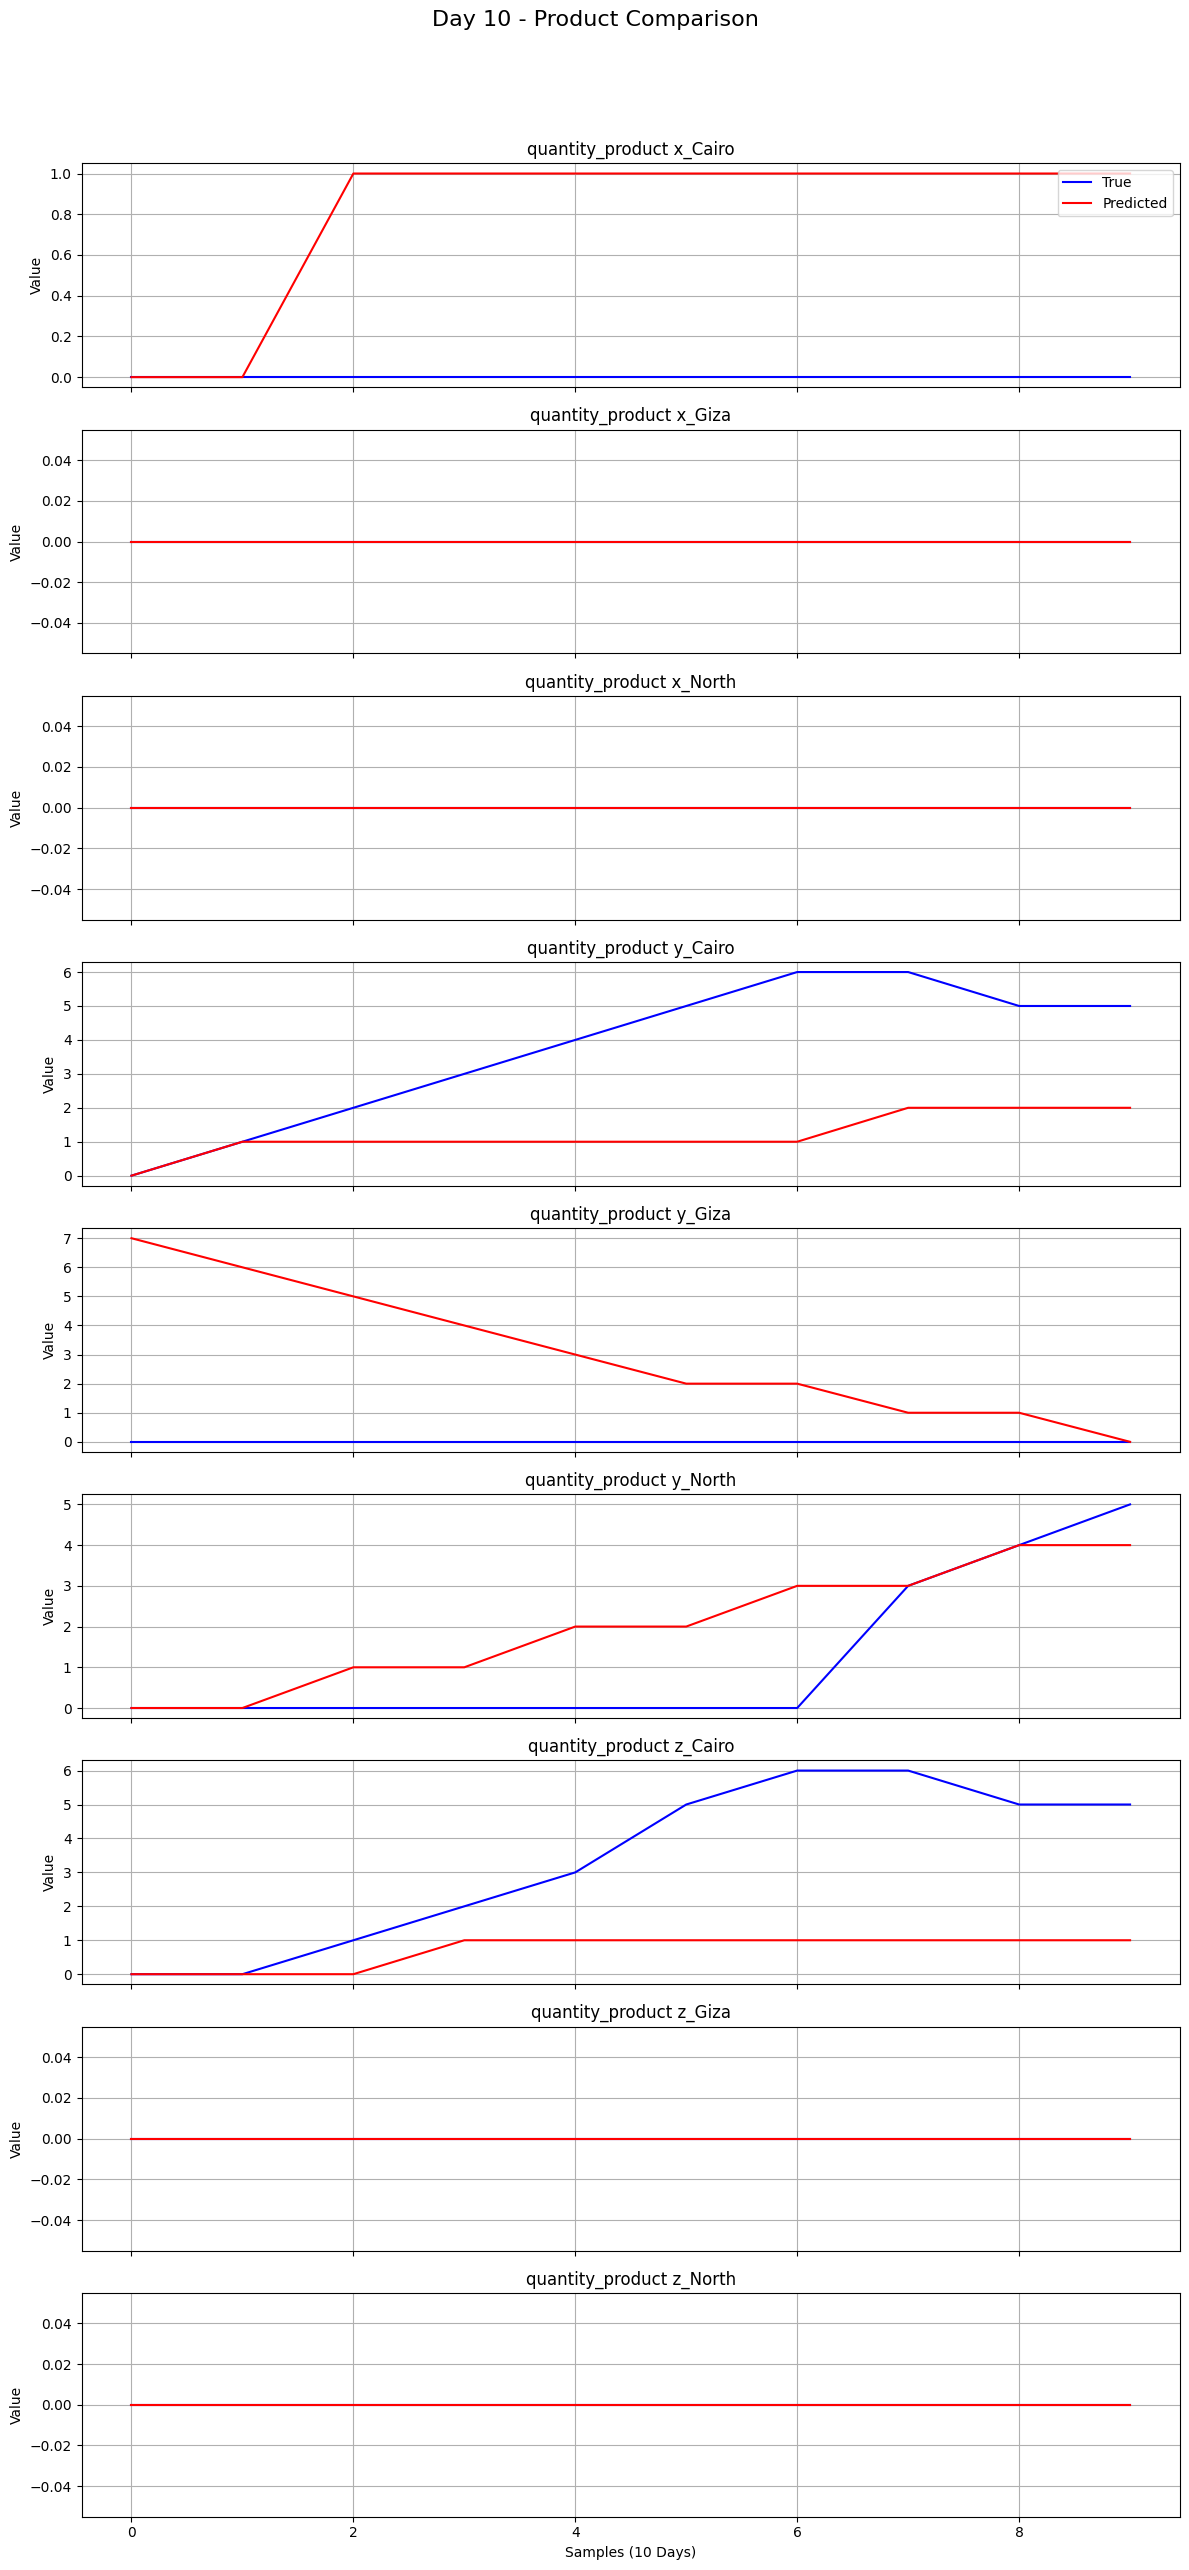

In [503]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'
]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute  Root Mean Squared Error (RMSE) for all samples, timesteps, and products
mse = mean_squared_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Root Mean Squared Error: {mse**0.5}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(
    y_test.reshape(-1, y_test.shape[-1]),
    y_pred.reshape(-1, y_pred.shape[-1]),
    multioutput='uniform_average'
)
print(f"Mean Absolute Error: {mae}")

# 4. Visualize comparison by day (all products per day)
samples = y_test.shape[0]  # Number of days
timesteps = y_test.shape[1]
products = y_test.shape[2]

for day in range(timesteps):  # Loop through all days
    print(f"\nVisualizing results for Day {day + 1} of {timesteps}")

    # Create a subplot for all products for the current day
    fig, axes = plt.subplots(nrows=products, ncols=1, figsize=(12, products * 3), sharex=True)
    fig.suptitle(f"Day {day + 1} - Product Comparison", fontsize=16)

    for product_idx, ax in enumerate(axes):  # Loop through all products
        # Plot True values
        ax.plot(range(samples), y_test[:, day, product_idx], label='True', color='blue')

        # Plot Predicted values
        ax.plot(range(samples), y_pred[:, day, product_idx], label='Predicted', color='red')

        # Title and Labels
        ax.set_title(f"{product_names[product_idx]}")
        ax.set_ylabel("Value")
        ax.grid()

    # Common labels
    axes[-1].set_xlabel("Samples (10 Days)")
    axes[0].legend(loc='upper right')

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title space
    plt.show()


### Evalution on non-zero metrices

In [488]:
# Check performance on non-zero sales days
non_zero_mask = y_test != 0
non_zero_mae = np.mean(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]))
print(f"Non-Zero MAE: {non_zero_mae:.2f}")

# Check performance on high-sales days (e.g., ≥5 units)
high_sales_mask = y_test >= 5
high_sales_mae = np.mean(np.abs(y_test[high_sales_mask] - y_pred[high_sales_mask]))
print(f"High-Sales MAE: {high_sales_mae:.2f}")

Non-Zero MAE: 1.63
High-Sales MAE: 3.10



Non-Zero MAE: 1.44
High-Sales MAE: 2.17

Non-Zero MAE: 1.44
High-Sales MAE: 1.27

Non-Zero MAE: 1.47
High-Sales MAE: 2.93


#### Interpretation

*    Model has Low MAE 0.6 and RMSE 1.1 which less LightGBM
RMSE > MAE                                                            
means high Impact of large errors and small general error across all predictions .

*   Model has Low Non-Zero MAE [ 1.46 ,1.44,1.5 ] and low High-Sales MAE [2.1 , 2.17 , 2.93 ]
means good balance with highly skewed data and show a tradeoff between high performence with actual sales events and sales spikes .




# References
